In [1]:
import os, sys
import numpy as np
import pandas as pd
from prody import *
from pylab import *
from Bio import Phylo
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import py3Dmol
#import py3Dmol
#from tqdm import tqdm as tqdm
%matplotlib inline
confProDy(auto_show=False)
confProDy(auto_secondary=True)

@> ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True


In [2]:
ion()
pathPDBFolder('./pdbs/')
#FIG = '../figures/ClassA/updates/'
#FIG = '/home/bentley/Dropbox/Pitt/Bahar/Defense/figures/GPCRs/'
FIG = '/Users/bentley/Dropbox/Pitt/Bahar/GPCRs/paper/Rewrites/Reviews/'
ref_pdb = '7DHI'

@> Local PDB folder is set: '/Users/bentley/Dropbox/Pitt/Bahar/GPCRs/scripts/pdbs'
@> A plain folder structure will be assumed.


In [3]:
prody.__version__

'2.0'

## Helper Functions

In [4]:
def getEnsModeFig(gnms, modenum, save, title):
    ax = showSignatureMode(gnms[:, modenum]);
    #plot(gnms[1,modenum].getArray(),color='r', linestyle='-', linewidth=0.5)
    #plt.ylim(-0.1,0.2)
    showDomainBar(resdomains,loc=1)
    if save:
        plt.savefig(FIG + 'GPCR_' + title + '_profile_mode' + str(modenum+1) + '.png',dpi=300)
    plt.show()
    plt.close()
    return

In [5]:
def getEnsFluctFig(gnms, mode1, mode2, save):
    showSignatureSqFlucts(gnms[:, mode1:mode2])
    plt.ylim(0,1.0)
    showDomainBar(resdomains,loc=1)
    plt.title('')
    plt.xlabel('', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if save:
        plt.savefig(FIG + 'GPCR_ensemble_MSFs_' + str(mode1) + '-' + str(mode2) + '.png', dpi=300)
    plt.show()
    plt.close()
    return

In [6]:
## Transmembrane only (Class A - 7DHI)
resdomains = ['' for x in range(268)]
for x in range(len(resdomains)):
    pos = x + 180
    if pos > 179 and pos < 213:
        resdomains[x] = 'TM1'
    elif pos > 219 and pos < 240:
        resdomains[x] = 'TM2'
    elif pos > 282 and pos < 307:
        resdomains[x] = 'TM3'
    elif pos > 320 and pos < 343:
        resdomains[x] = 'TM4'
    elif pos > 361 and pos < 383:
        resdomains[x] = 'TM5'
    elif pos > 409 and pos < 429:
        resdomains[x] = 'TM6'
    elif pos > 440 and pos < 464:
        resdomains[x] = 'TM7'

In [7]:
def showSignatureSqFluctsTest(mode_ensemble, **kwargs):
    """Show signature profile of square fluctations.

    :arg mode_ensemble: mode ensemble from which to calculate square fluctutations
    :type mode_ensemble: :class:`ModeEnsemble`    

    :arg atoms: atoms for showing residues along the x-axis
                Default option is to use mode_ensemble.getAtoms()
    :type atoms: :class:`Atomic`

    :arg scale: scaling factor. Default is 1.0
    :type scale: float

    :arg norm: whether to normalize the cross-correlations. Default is **True**
    :type norm: bool  

    :arg show_zero: where to show a grey line at y=0
                    Default is False
    :type show_zero: bool      
    """

    if not isinstance(mode_ensemble, ModeEnsemble):
        raise TypeError('mode_ensemble should be an instance of ModeEnsemble')

    if not mode_ensemble.isMatched():
        LOGGER.warn('modes in mode_ensemble did not match cross modesets. '
                    'Consider running mode_ensemble.match() prior to using this function')

    atoms = kwargs.pop('atoms', mode_ensemble.getAtoms())
    scale = kwargs.pop('scale', 1.0)
    pass_norm = kwargs.pop('norm', True)
    sqf = calcSignatureSqFluctsTest(mode_ensemble, norm=pass_norm) * scale
    show_zero = kwargs.pop('show_zero', False)
    return showSignature1D(sqf, atoms=atoms, show_zero=show_zero, **kwargs)

In [8]:
def calcSignatureSqFluctsTest(mode_ensemble, **kwargs):
    """
    Get the signature square fluctuations of *mode_ensemble*. 
    
    :arg mode_ensemble: an ensemble of ENMs 
    :type mode_ensemble: :class: `ModeEnsemble`

    :keyword norm: whether to normalize the square fluctuations. Default is **True**
    :type norm: bool

    :keyword scale: whether to rescale the square fluctuations based on the reference. 
                    Default is **False**
    :type scale: bool
    """

    if not isinstance(mode_ensemble, ModeEnsemble):
        raise TypeError('mode_ensemble should be an instance of ModeEnsemble')
    
    if not mode_ensemble.isMatched():
        LOGGER.warn('modes in mode_ensemble did not match cross modesets. '
                    'Consider running mode_ensemble.match() prior to using this function')

    ifnorm = kwargs.pop('norm', True)
    ifscale = kwargs.pop('scale', False)

    norm = importLA().norm

    V = []
    for i, modes in enumerate(mode_ensemble):
        sqfs = calcSqFlucts(modes)

        if ifnorm:
            sqfs = div0(sqfs, norm(sqfs))
        elif ifscale:
            if i == 0:
                norm0 = norm(sqfs)
            else:
                sqfs = div0(sqfs, norm(sqfs) * norm0)
        V.append(sqfs)
    V = np.vstack(V)

    title_str = '%d modes'%mode_ensemble.numModes()
    weights = mode_ensemble.getWeights()
    if weights is not None:
        weights = weights[:, :, 0]
    labels = mode_ensemble.getLabels()

    # even the original model is 3d, sqfs are still 1d
    sig = sdarray(V, title=title_str, weights=weights, labels=labels, is3d=False)

    return sig

In [9]:
def showDomainBarTest(domains, x=None, loc=0., axis='x', **kwargs):
    """
    Plot a bar on top of the current axis which is colored based 
    on domain separations.
    
    :arg domains: a list of domain labels 
    :type domains: list, tuple, :class:`~numpy.ndarray`

    :arg loc: relative position of the domain bar. **0** means at 
              bottom/left and **1** means at top/right
    :type loc: float

    :arg axis: on which axis the bar will be plotted. It can be 
               either **x** or **y**
    :type axis: str

    :keyword text: whether to show the text or not. Default is **True**
    :type text: bool

    :keyword text_loc: location of text labels. It can be either 
                   **above** or **below**
    :type text_loc: str

    :keyword text_color: color of the text labels
    :type text_color: str, tuple, list

    :keyword color: a dictionary of colors where keys are the domain names
    :type color: dict

    :keyword relim: whether to rescale the axes' limits after adding 
                    the bar. Default is **True**
    :type relim: bool
    """

    from matplotlib.pyplot import plot, text, xlim, ylim, gca

    show_text = kwargs.pop('show_text', True)
    show_text = kwargs.pop('text', show_text)
    text_color = kwargs.pop('text_color', 'k')
    text_color = kwargs.pop('textcolor', text_color)
    font_dict = kwargs.pop('font_dict', None)
    font_dict = kwargs.pop('fontdict', font_dict)

    barwidth = kwargs.pop('barwidth', 5)
    barwidth = kwargs.pop('bar_width', barwidth)

    color_dict = kwargs.pop('color', None)

    offset = kwargs.pop('offset', 0)

    is3d = kwargs.pop('is3d', False)

    relim = kwargs.pop('relim', True)

    text_loc = kwargs.pop('text_loc', 'above')
    if not isinstance(text_loc, str):
        raise TypeError('text_loc should be a str')
    
    text_loc = text_loc.lower().strip()
    if not text_loc in ['above', 'below']:
        raise ValueError('text_loc can only be either "above" or "below"')

    halign = 'right' if text_loc == 'below' else 'left'
    valign = 'top' if text_loc == 'below' else 'bottom'

    if len(domains) == 0:
        raise ValueError('domains should not be empty')

    if is3d:
        domains_ = []
        for d in domains:
            domains_.extend([d]*3)
        domains = domains_

    domains = np.asarray(domains, dtype=str)
    EMPTY_CHAR = domains[0][:0]

    uni_domids = np.unique(domains)
    uni_domids = uni_domids[uni_domids!=EMPTY_CHAR]

    if axis == 'y':
        lim = xlim
    elif axis == 'x':
        lim = ylim
    else:
        raise ValueError('axis can be either "x" or "y"')

    L = lim()
    d_loc = L[0] + loc * (L[1] - L[0])
    D = []
    bars = []
    texts = []

    color_order = []
    for domid in uni_domids:
        if color_dict is not None:
            color_order.append(color_dict[domid])
        d = domains == domid
        D.append(d)

    if not D:
        return bars, texts
    D = np.vstack(D).T
    F = np.zeros(D.shape)
    F[~D] = np.nan
    F[D] = d_loc

    if x is None:
        x = np.arange(len(domains), dtype=float)
    x = x + offset #+ 0.5
    X = np.tile(x, (len(uni_domids), 1)).T

    if show_text:
        for i, chid in enumerate(uni_domids):
            d = D[:, i].astype(int)
            d *= np.arange(len(d)) + 1
            # find the position for the texts
            #locs = np.where(d)[0]
            idx = np.where(d)[0]
            locs = np.split(d[idx], np.where(np.diff(idx)!=1)[0] + 1)

            for loc in locs:
                if len(loc) == 1:
                    i = int(loc)
                    pos = x[i-1] - offset
                else:
                    i = int(np.median(loc))
                    pos = x[i-1] - offset
                if axis == 'y':
                    txt = text(d_loc, pos, chid, rotation=-90, 
                                                color=text_color,
                                                horizontalalignment=halign, 
                                                verticalalignment='center',
                                                fontdict=font_dict)
                else:
                    txt = text(pos, d_loc, chid, color=text_color,
                                                horizontalalignment='center', 
                                                verticalalignment=valign,
                                                fontdict=font_dict)
                texts.append(txt)
    
    if len(color_order):
        gca().set_prop_cycle('color', color_order)
    else:
        gca().set_prop_cycle(None)

    if axis == 'y':
        dbars = plot(F, X, linewidth=barwidth, solid_capstyle='butt', drawstyle='steps')

        for bar in dbars:
            bar.set_clip_on(False)
    else:
        dbars = plot(X, F, linewidth=barwidth, solid_capstyle='butt', drawstyle='steps-post')
        for bar in dbars:
            bar.set_clip_on(False)

    gca().set_prop_cycle(None)
    bars.extend(dbars)
    if relim:
        gca().autoscale_view()

    start, stop = lim()
    lim(start, stop)
    
    return bars, texts

## Prepare Ensemble

In [ ]:
dali_rec = searchDali(ref_pdb,'R')

In [ ]:
dali_rec.fetch()

In [ ]:
pdb_ids = dali_rec.filter(cutoff_len=0.5, cutoff_rmsd=0.5, cutoff_Z=20, cutoff_identity=30)

In [ ]:
outfile = open('pdb_ids.pkl', "wb")
pickle.dump(pdb_ids, outfile)
outfile.close()

In [10]:
infile = open('pdb_ids.pkl', "rb")
pdb_ids = pickle.load(infile)
infile.close()

In [11]:
len(pdb_ids)

418

In [ ]:
mappings = dali_rec.getMappings()

In [ ]:
outfile = open('mappings.pkl', "wb")
pickle.dump(mappings, outfile)
outfile.close()

In [11]:
infile = open('mappings.pkl', "rb")
mappings = pickle.load(infile)
infile.close()

In [ ]:
dali_rec.getMappings?

In [ ]:
print(len(mappings.keys()), len(mappings['4mqsA']), len(mappings['7dhiR'][0]))

In [ ]:
print(mappings.keys())

In [ ]:
pdbs = parsePDB(*pdb_ids, subset='ca')

In [ ]:
dali_ens = buildPDBEnsemble(pdbs, mapping=mappings, seqid=20)

In [ ]:
saveEnsemble(dali_ens,'New_GPCR_ens-dali')
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce')
saveModeEnsemble(gnms, 'New_GPCR_gnms-dali', atoms=True)

In [ ]:
pdb_ids[:10]

In [ ]:
pdbs_classA, pdbs_classB, pdbs_classC, pdbs_classF = [], [], [], []

In [ ]:
pdb_classes = {}
for gpcr_class in classes:
    print(gpcr_class)
    temp_df = gpcr_df.loc[gpcr_df['Class'] == gpcr_class].loc[gpcr_df['Species'] == 'Human']
    class_pdbs = list(temp_df.PDB)
    pdb_classes[gpcr_class] = []
    for pdb in pdb_ids:
        pdbid = pdb[:4].upper()
        if pdbid in class_pdbs:
            pdb_classes[gpcr_class].append(pdbid)

In [ ]:
pdb_classes

### Ensemble using GPCRdb

In [12]:
gpcr_df = pd.read_csv('../GPCRdb_structures.csv')

In [13]:
gpcr_df.loc[gpcr_df['Class'] == 'A (Rhodopsin)']

UniProt     IUPHAR Receptor family          Class Species   Method   PDB  \
82     OPSD  Rhodopsin          Opsins  A (Rhodopsin)   Human    X-ray  5W0P   
83     OPSD  Rhodopsin          Opsins  A (Rhodopsin)   Human    X-ray  5DGY   
84     OPSD  Rhodopsin          Opsins  A (Rhodopsin)   Human    X-ray  4ZWJ   
85     OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  4PXF   
86    GPBAR       GPBA       Bile acid  A (Rhodopsin)   Human  cryo-EM  7CFM   
..      ...        ...             ...            ...     ...      ...   ...   
483    OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  1U19   
484    OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  1GZM   
485    OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  1L9H   
486    OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  1HZX   
487    OPSD  Rhodopsin          Opsins  A (Rhodopsin)  Bovine    X-ray  1F88   

    Refined_structure  Resolution Preferred_chain  ...            Type  \
82       5W0P_refined         3.0               D  ...            none   
83       5DGY_refined         7.7               A  ...            none   
84       4ZWJ_refined         3.3               A  ...            none   
85                  -         2.8               A  ...  small molecule   
86       7CFM_refined         3.0               R  ...            none   
..                ...         ...             ...  ...             ...   
483      1U19_refined         2.2               A  ...  small molecule   
484      1GZM_refined         2.7               A  ...  small molecule   
485                 -         2.6               A  ...  small molecule   
486                 -         2.8               A  ...  small molecule   
487                 -         2.8               A  ...  small molecule   

            Function                   Name.1          Type.1 D2x50-S3x39  \
82   Apo (no ligand)                  Retinal  small molecule          No   
83   Apo (no ligand)                  Retinal  small molecule          No   
84   Apo (no ligand)                  Retinal  small molecule          No   
85           unknown                  Retinal  small molecule          No   
86           Agonist  chenodeoxycholic aci...  small molecule          No   
..               ...                      ...             ...         ...   
483  Inverse agonist                  Retinal  small molecule          No   
484  Inverse agonist                  Retinal  small molecule          No   
485  Inverse agonist                  Retinal  small molecule          No   
486  Inverse agonist                  Retinal  small molecule          No   
487  Inverse agonist                  Retinal  small molecule          No   

    Sodium in structure   Last author                      Reference  \
82                   No         Xu HE    10.1016/J.CELL.2017.07.002    
83                   No         Xu HE         10.1038/SDATA.2016.21    
84                   No         Xu HE           10.1038/NATURE14656    
85                   No    Scheerer P            10.1038/NCOMMS5801    
86                   No       Zhang Y     10.1038/S41586-020-2569-1    
..                  ...           ...                            ...   
483                  No        Buss V     10.1016/J.JMB.2004.07.044    
484                  No  Schertler GF     10.1016/J.JMB.2004.08.090    
485                  No    Shichida Y        10.1073/PNAS.082666399    
486                  No   Stenkamp RE             10.1021/BI0155091    
487                  No  Palczewski K  10.1126/SCIENCE.289.5480.739    

     PDB Date Annotated  
82     8/9/17       Yes  
83    3/23/16       Yes  
84    7/29/15       Yes  
85    9/17/14        No  
86     9/9/20       Yes  
..        ...       ...  
483  10/12/04       Yes  
484  11/20/03       Yes  
485   5/15/02        No  
486    7/4/01        No  
487    8/4/00        No  

[406 rows x 29 columns]

In [14]:
gpcr_df.head()

UniProt IUPHAR Receptor family         Class Species   Method   PDB  \
0     SMO    SMO        Frizzled  F (Frizzled)   Human  cryo-EM  6XBK   
1     SMO    SMO        Frizzled  F (Frizzled)   Human  cryo-EM  6XBJ   
2     SMO    SMO        Frizzled  F (Frizzled)   Human  cryo-EM  6XBM   
3     SMO    SMO        Frizzled  F (Frizzled)   Human  cryo-EM  6XBL   
4     SMO    SMO        Frizzled  F (Frizzled)   Human  cryo-EM  6OT0   

  Refined_structure  Resolution Preferred_chain  ...            Type Function  \
0      6XBK_refined         3.2               R  ...             NaN  Agonist   
1      6XBJ_refined         3.9               R  ...             NaN  Agonist   
2      6XBM_refined         3.2               R  ...  small molecule  Agonist   
3      6XBL_refined         3.9               R  ...  small moelcule      PAM   
4      6OT0_refined         3.9               R  ...  small molecule  Agonist   

         Name.1        Type.1 D2x50-S3x39 Sodium in structure Last author  \
0  constitutive  constitutive          No                  No        Li X   
1  constitutive  constitutive          No                  No        Li X   
2  constitutive  constitutive          No                  No        Li X   
3  constitutive  constitutive          No                  No        Li X   
4  constitutive  constitutive          No                  No        Li X   

                    Reference PDB Date Annotated  
0  10.1038/S41589-020-0646-2   9/30/20       Yes  
1  10.1038/S41589-020-0646-2   9/30/20       Yes  
2  10.1038/S41589-020-0646-2   9/30/20       Yes  
3  10.1038/S41589-020-0646-2   9/30/20       Yes  
4  10.1038/S41586-019-1286-0   6/12/19       Yes  

[5 rows x 29 columns]

In [15]:
gpcr_df = gpcr_df[['UniProt', 'Receptor family', 'Class', 'Species', 'PDB', 'Preferred_chain', 'State', 'Family', 'Subtype']]
gpcr_df.head()

UniProt Receptor family         Class Species   PDB Preferred_chain   State  \
0     SMO        Frizzled  F (Frizzled)   Human  6XBK               R  Active   
1     SMO        Frizzled  F (Frizzled)   Human  6XBJ               R  Active   
2     SMO        Frizzled  F (Frizzled)   Human  6XBM               R  Active   
3     SMO        Frizzled  F (Frizzled)   Human  6XBL               R  Active   
4     SMO        Frizzled  F (Frizzled)   Human  6OT0               R  Active   

  Family Subtype  
0   Gi/o     αi1  
1   Gi/o     αi1  
2   Gi/o     αi1  
3   Gi/o     αi1  
4   Gi/o     αi1

In [16]:
gpcr_df['PDBch'] = gpcr_df['PDB'] + gpcr_df['Preferred_chain']
gpcr_df.head()

UniProt Receptor family         Class Species   PDB Preferred_chain   State  \
0     SMO        Frizzled  F (Frizzled)   Human  6XBK               R  Active   
1     SMO        Frizzled  F (Frizzled)   Human  6XBJ               R  Active   
2     SMO        Frizzled  F (Frizzled)   Human  6XBM               R  Active   
3     SMO        Frizzled  F (Frizzled)   Human  6XBL               R  Active   
4     SMO        Frizzled  F (Frizzled)   Human  6OT0               R  Active   

  Family Subtype  PDBch  
0   Gi/o     αi1  6XBKR  
1   Gi/o     αi1  6XBJR  
2   Gi/o     αi1  6XBMR  
3   Gi/o     αi1  6XBLR  
4   Gi/o     αi1  6OT0R

In [17]:
gpcr_df['Class_letter'] = gpcr_df['Class'][:][0]
gpcr_df.head()

UniProt Receptor family         Class Species   PDB Preferred_chain   State  \
0     SMO        Frizzled  F (Frizzled)   Human  6XBK               R  Active   
1     SMO        Frizzled  F (Frizzled)   Human  6XBJ               R  Active   
2     SMO        Frizzled  F (Frizzled)   Human  6XBM               R  Active   
3     SMO        Frizzled  F (Frizzled)   Human  6XBL               R  Active   
4     SMO        Frizzled  F (Frizzled)   Human  6OT0               R  Active   

  Family Subtype  PDBch  Class_letter  
0   Gi/o     αi1  6XBKR  F (Frizzled)  
1   Gi/o     αi1  6XBJR  F (Frizzled)  
2   Gi/o     αi1  6XBMR  F (Frizzled)  
3   Gi/o     αi1  6XBLR  F (Frizzled)  
4   Gi/o     αi1  6OT0R  F (Frizzled)

In [18]:
pdbids = []
for index, row in gpcr_df.iterrows():
    #if row['Species'] == "Human":
    pdbids.append(str(row['PDBch']))

In [ ]:
pdbs = []
for pdbid in pdbids:
    try:
        pdb = parsePDB(pdbid, subset='ca')
        pdbs.append(pdb)
    except OSError:
        print("Error: " + str(pdbid))

In [20]:
len(pdbs)

486

In [21]:
classes = list(gpcr_df['Class'])
classes = list(set(classes))
classes

['F (Frizzled)', 'C (Glutamate)', 'B1 (Secretin)', 'A (Rhodopsin)']

In [22]:
states = list(gpcr_df['State'])
states = list(set(states))
states

['Inactive', 'Other', 'Intermediate', 'Active']

In [23]:
for gpcr_class in classes:
    for state in states:
        temp_df = gpcr_df.loc[gpcr_df['Class'] == gpcr_class].loc[gpcr_df['State'] == state].loc[gpcr_df['Species'] == 'Human']
        print(gpcr_class, state, temp_df.shape)

F (Frizzled) Inactive (11, 11)
F (Frizzled) Other (0, 11)
F (Frizzled) Intermediate (0, 11)
F (Frizzled) Active (5, 11)
C (Glutamate) Inactive (14, 11)
C (Glutamate) Other (0, 11)
C (Glutamate) Intermediate (0, 11)
C (Glutamate) Active (3, 11)
B1 (Secretin) Inactive (14, 11)
B1 (Secretin) Other (0, 11)
B1 (Secretin) Intermediate (1, 11)
B1 (Secretin) Active (30, 11)
A (Rhodopsin) Inactive (193, 11)
A (Rhodopsin) Other (1, 11)
A (Rhodopsin) Intermediate (42, 11)
A (Rhodopsin) Active (62, 11)


In [24]:
temp_df = gpcr_df.loc[gpcr_df['Class'] == 'A (Rhodopsin)']
temp_df.head()

UniProt Receptor family          Class Species   PDB Preferred_chain  \
82    OPSD          Opsins  A (Rhodopsin)   Human  5W0P               D   
83    OPSD          Opsins  A (Rhodopsin)   Human  5DGY               A   
84    OPSD          Opsins  A (Rhodopsin)   Human  4ZWJ               A   
85    OPSD          Opsins  A (Rhodopsin)  Bovine  4PXF               A   
86   GPBAR       Bile acid  A (Rhodopsin)   Human  7CFM               R   

     State  Family     Subtype  PDBch  Class_letter  
82  Active  Visual  S-arrestin  5W0PD  F (Frizzled)  
83  Active  Visual  S-arrestin  5DGYA  F (Frizzled)  
84  Active  Visual  S-arrestin  4ZWJA  F (Frizzled)  
85  Active  Visual  S-arrestin  4PXFA  F (Frizzled)  
86  Active      Gs          αs  7CFMR  F (Frizzled)

In [25]:
temp_df.PDB[:10]

82    5W0P
83    5DGY
84    4ZWJ
85    4PXF
86    7CFM
87    7CFN
88    7JJO
89    7BW0
90    7BZ2
91    6LI3
Name: PDB, dtype: object

In [26]:
temp_df.State.value_counts()

Inactive        247
Active          112
Intermediate     46
Other             1
Name: State, dtype: int64

In [27]:
classA = list(temp_df.PDBch)
print(classA)

['5W0PD', '5DGYA', '4ZWJA', '4PXFA', '7CFMR', '7CFNR', '7JJOR', '7BW0R', '7BZ2R', '6LI3R', '6NI3R', '6E+067B', '6GDGA', '5G53A', '3SN6R', '6WHAA', '6OIJR', '6LFMR', '6LFOR', '6PGSA', '6PH7A', '6WWZR', '6PELA', '6VMSR', '6K42R', '6K41R', '6OMMR', '6KPGR', '6PT0R', '6KPFR', '6NWEA', '6OY9R', '6OYAR', '6OS9R', '6OSAR', '6QNOR', '6OIKR', '6N4BR', '6FUFA', '6G79S', '6D9HR', '6CMOR', '6DDFR', '6DDER', '5WKTA', '5EN0A', '4X1HA', '4J4QA', '4BEYA', '4A4MA', '2X72A', '3PQRA', '3DQBA', '6TKOA', '6U1NR', '6UP7R', '6PWCR', '7BR3A', '6WH4C', '6WGTB', '6ZDVA', '6ZDRA', '6Z10A', '6LFLA', '6KO5A', '6TPKA', '7C61A', '7C6AA', '6S0QA', '6V9SA', '6WJCA', '6W25A', '6OBAA', '6LW5A', '6VI4B', '6KP6A', '6LUQA', '6LI1A', '6LI2A', '6LI0A', '6OS0A', '6OS2A', '6OS1A', '6KPCA', '6LRYA', '6KNMB', '6JODA', '6TOSB', '6TOTB', '6TQ7A', '6TP3A', '6TP4B', '6TO7A', '6TP6B', '6TODA', '6TQ9B', '6TQ6B', '6TQ4B', '6TPGA', '6TPJA', '6TPNA', '6OL9A', '6RZ7A', '6RZ8A', '6RZ9A', '6RZ6A', '6PT2A', '6PT3A', '6KUYA', '6KUXA', '6KUWA'

In [ ]:
classA_pdbs = []
for pdbid in classA:
    try:
        temp = parsePDB(pdbid, subset='ca')
        classA_pdbs.append(temp)
    except OSError:
        continue
print(classA_pdbs)

### Whole ensemble analysis

In [34]:
ref_structure = parsePDB(ref_pdb, subset='ca', chain='R')

@> PDB file is found in working directory (7dhi.pdb).
@> 290 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> Secondary structures were assigned to 207 residues.


In [ ]:
#ens = buildPDBEnsemble(pdbs, ref=ref_structure, seqid=20)
ens = buildPDBEnsemble(classA_pdbs, ref=ref_structure, seqid=20)

In [ ]:
ens

In [ ]:
#saveEnsemble(ens,'New_GPCRA_ens')
gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce')
#saveModeEnsemble(gnms, 'New_GPCRA_gnms', atoms=True)

In [ ]:
gnms

### Reorder Ensemble

In [30]:
FIG = '/home/bentley/Dropbox/Pitt/Bahar/GPCRs/paper/figures/'

#### Reorder based on sequence similarity

In [80]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
gnms = loadModeEnsemble('New_GPCR_gnms-dali.modeens.npz')

In [81]:
new_labels = ens.getLabels()
msa = ens.getMSA()

seqids = buildSeqidMatrix(msa)
seq_tree = calcTree(new_labels, 1. - seqids, method='upgma')


reordered_seqids, seqid_reordering_indices = reorderMatrix(new_labels, seqids, seq_tree)


ens = ens[seqid_reordering_indices]
saveEnsemble(ens, 'New_GPCR-dali_reordered-seq')
writePDB('New_GPCR-dali_reordered-seq', ens)

gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce')
saveModeEnsemble(gnms, 'New_GPCR-dali_reordered-seq', atoms=True)

@> Sequence identity matrix was calculated in 0.02s.
@> Calculating 20 GNM modes for 224 conformations... [ 12%] 4s@> WARNING More than 1 (2) zero eigenvalues were calculated.
@> Calculating 20 GNM modes for 224 conformations... [ 13%] 4s@> WARNING More than 1 (2) zero eigenvalues were calculated.
@> Calculating 20 GNM modes for 224 conformations... [ 62%] 2s@> WARNING More than 1 (2) zero eigenvalues were calculated.
@> Calculating 20 GNM modes for 224 conformations... [ 64%] 2s@> WARNING More than 1 (2) zero eigenvalues were calculated.
@> Calculating 20 GNM modes for 224 conformations... [ 65%] 2s@> WARNING More than 1 (2) zero eigenvalues were calculated.
@> 20 GNM modes were calculated for each of the 224 conformations in 4.72s.
@> 20 modes across 224 modesets were matched in 0.32s.
/home/bentley/anaconda3/envs/prody/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists

'New_GPCR-dali_reordered-seq.modeens.npz'

In [82]:
msa.getArray()

array([[b'E', b'V', b'W', ..., b'L', b'L', b'C'],
       [b'P', b'W', b'Q', ..., b'L', b'L', b'L'],
       [b'T', b'F', b'E', ..., b'L', b'L', b'M'],
       ...,
       [b'E', b'P', b'W', ..., b'T', b'L', b'C'],
       [b'E', b'P', b'W', ..., b'T', b'L', b'C'],
       [b'E', b'P', b'W', ..., b'T', b'L', b'C']], dtype='|S1')

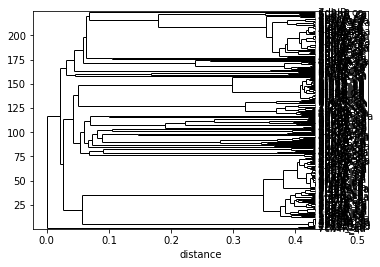

In [85]:
showTree(seq_tree, format='plt')

In [25]:
ens = loadEnsemble('New_GPCR-dali_reordered-seq.ens.npz')
gnms = loadModeEnsemble('New_GPCR-dali_reordered-seq.modeens.npz')

In [28]:
labels = [x.split('_')[0][:-1] for x in ens.getLabels()]
labels[:10]

['7cx4',
 '7cx3',
 '2ziy',
 '4ww3',
 '2z73',
 '3ayn',
 '4ww3',
 '3aym',
 '3ayn',
 '2z73']

In [29]:
print(labels[27], labels[54])

2i37 3cap


In [30]:
activity_labels = []
species_labels = []

for pdb in labels:
    temp = gpcr_df.loc[gpcr_df['PDB'] == pdb.upper()]
    if temp.shape[0] > 0:
        activity_labels.append(temp.State.values[0][0])
        species_labels.append(temp.Species.values[0][:3])
    else:
        activity_labels.append('N')
        species_labels.append('X')
        
activity_labels[:10]

['N', 'N', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I']

In [34]:
species_labels[:10]

['X', 'X', 'Jap', 'Jap', 'Jap', 'Jap', 'Jap', 'Jap', 'Jap', 'Jap']

In [ ]:
set(gpcr_df.Species.values)

In [ ]:
gpcr_df.loc[gpcr_df['PDB'] == '4zwj'.upper()].State.values[0][0]

In [ ]:
gpcr_df.loc[gpcr_df['PDB'] == '2i37'.upper()]#.State.values[0][0]

In [79]:
msa.getArray()

array([[b'-', b'-', b'-', ..., b'-', b'-', b'-'],
       [b'-', b'-', b'-', ..., b'-', b'-', b'-'],
       [b'P', b'D', b'A', ..., b'T', b'F', b'P'],
       ...,
       [b'S', b'A', b'F', ..., b'I', b'W', b'N'],
       [b'-', b'A', b'F', ..., b'-', b'-', b'-'],
       [b'E', b'V', b'W', ..., b'L', b'L', b'C']], dtype='|S1')

@> Sequence identity matrix was calculated in 0.02s.


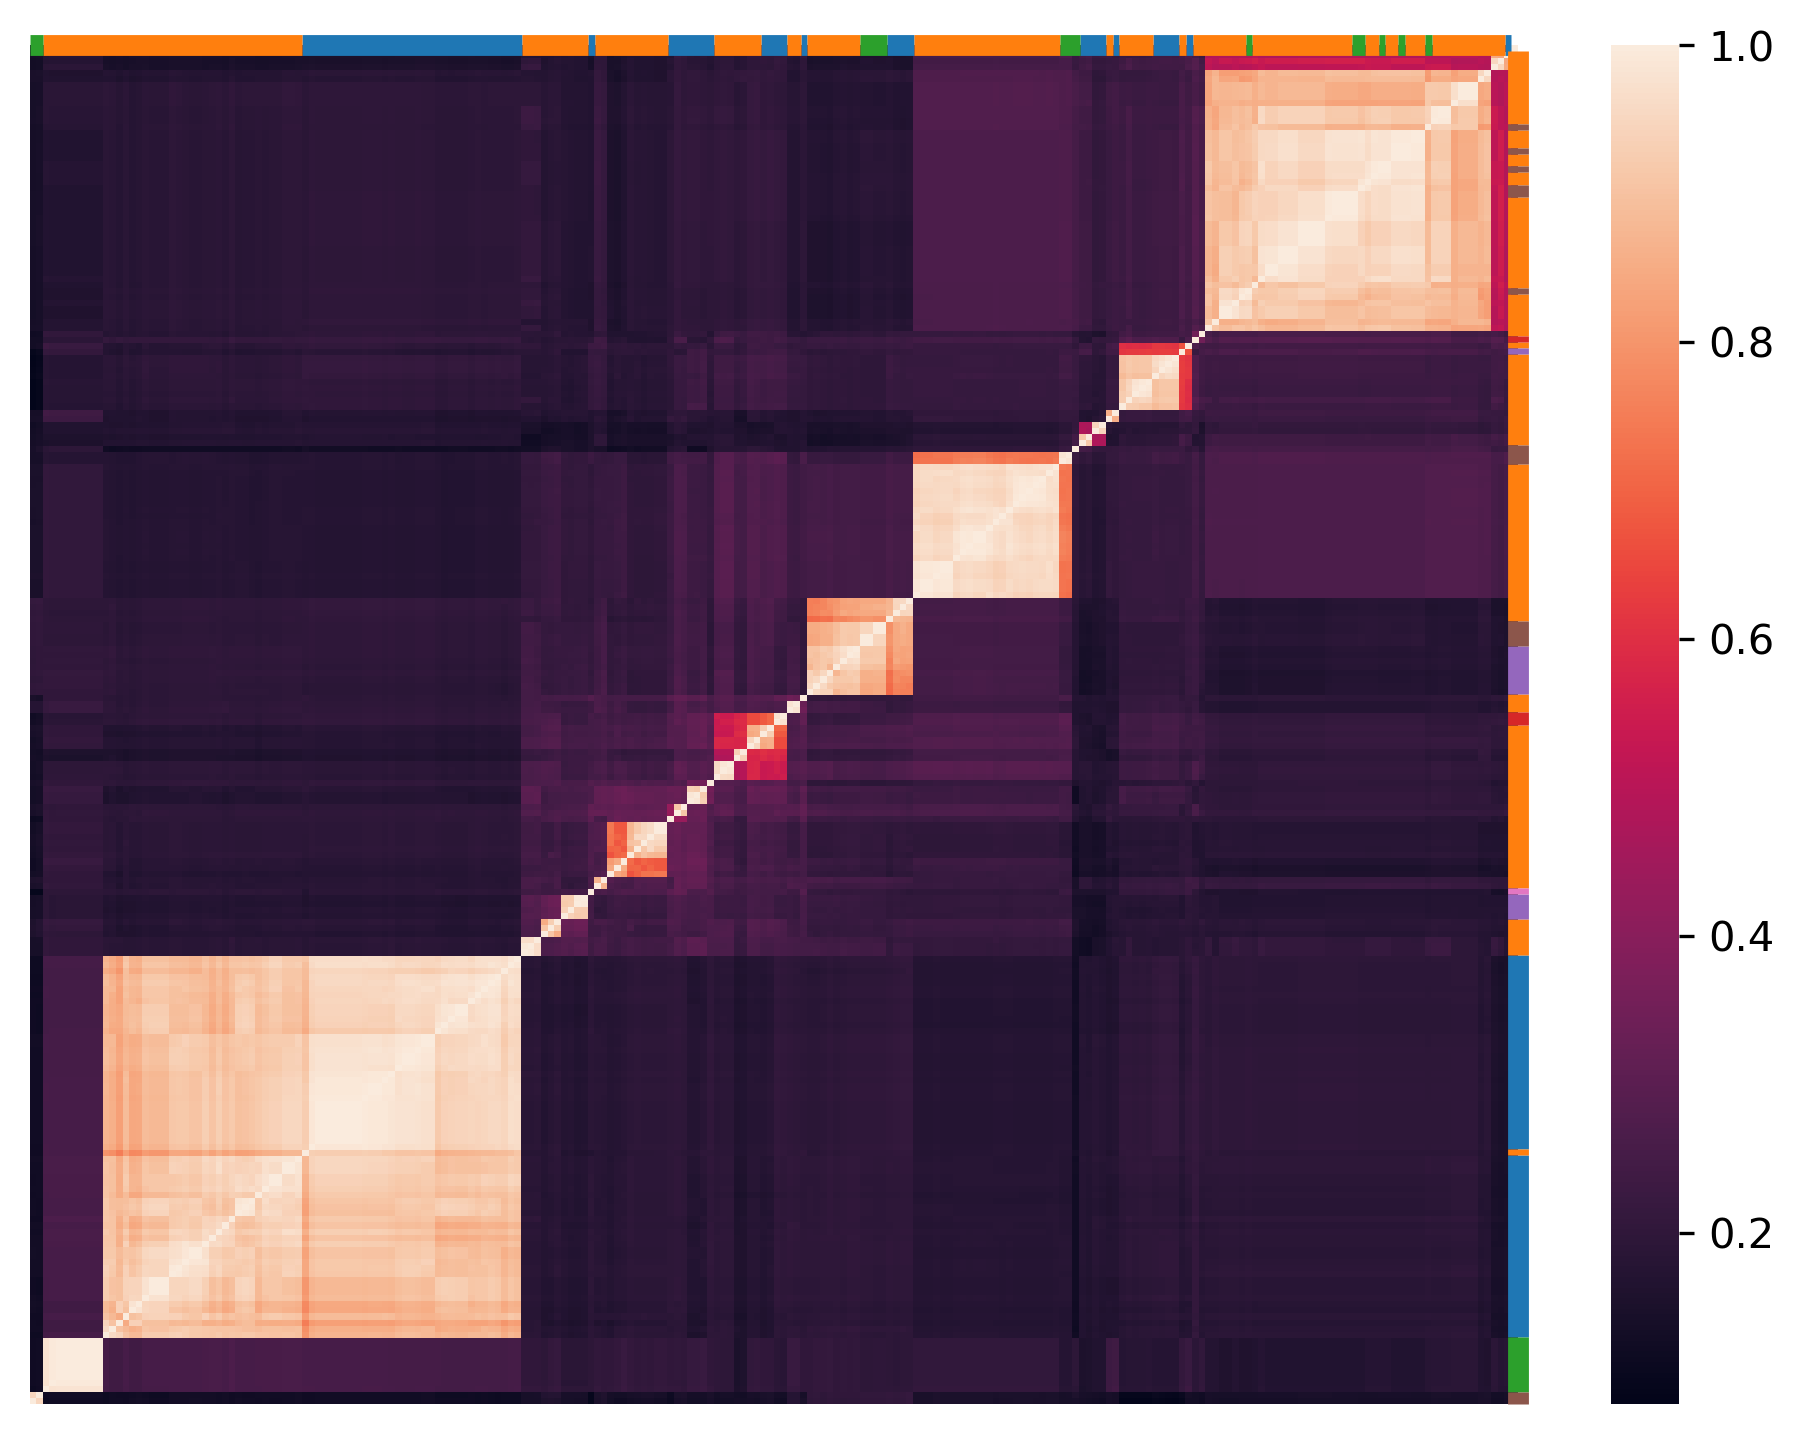

In [36]:
msa = ens.getMSA()
seqid_matrix = buildSeqidMatrix(msa)
figure(figsize=(8, 6), dpi=300)
ax = sns.heatmap(data=seqid_matrix)
plt.ylim(0,len(seqid_matrix))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
showDomainBar(activity_labels,loc=1,text=False)
showDomainBar(species_labels,loc=1,axis='y',text=False)
plt.savefig(FIG + 'New_GPCR-dali_reordered-seq_sequence.png',dpi=300)

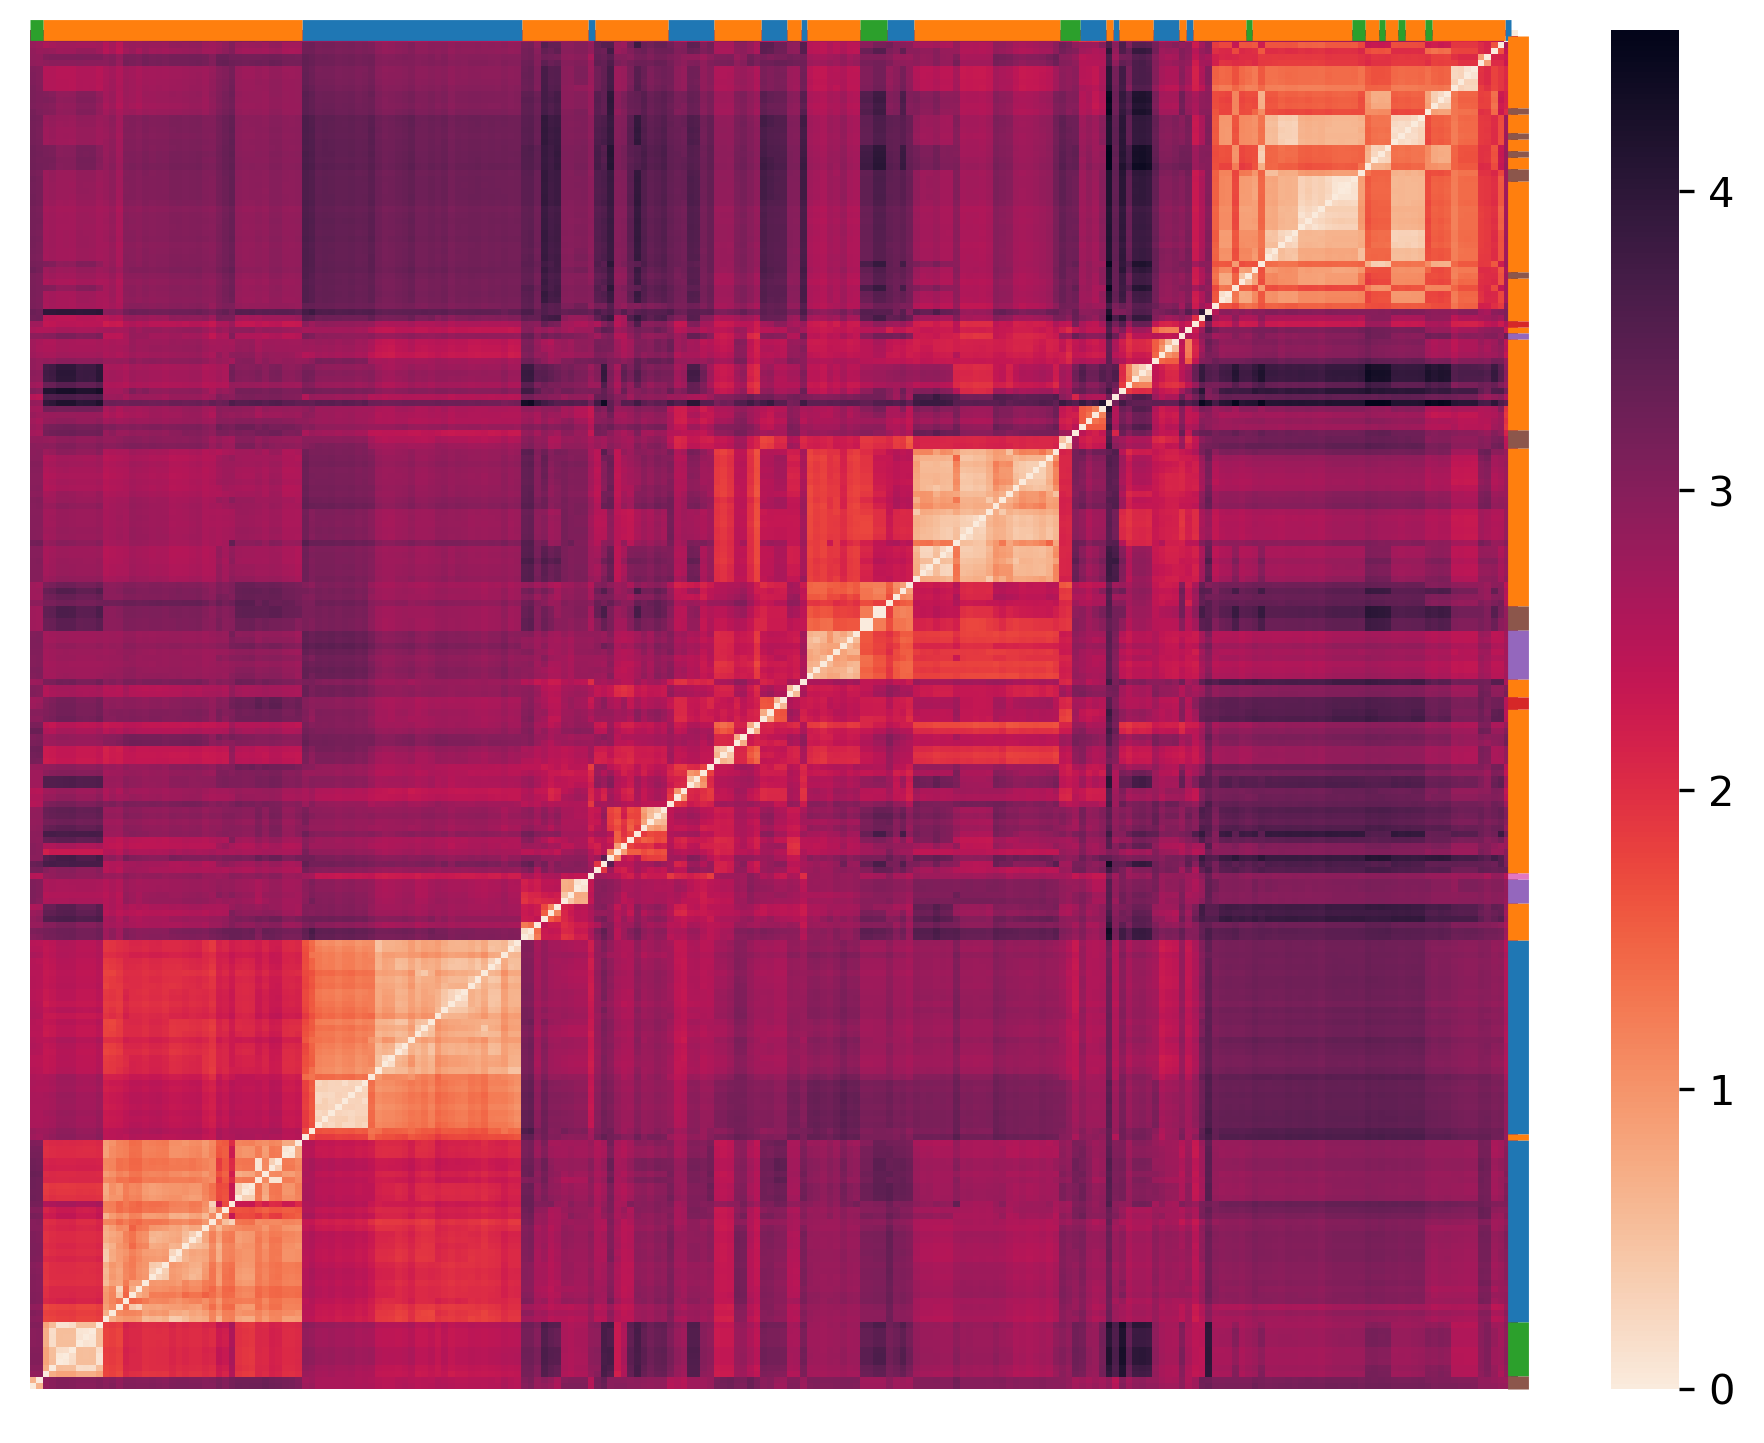

In [37]:
rmsds = ens.getRMSDs(pairwise=True)
rmsd_df = pd.DataFrame(ens.getRMSDs(pairwise=True))
cmap = sns.cm.rocket_r
figure(figsize=(8, 6), dpi=300)
ax = sns.heatmap(data=rmsd_df, cmap=cmap)
plt.ylim(0,len(seqid_matrix))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
showDomainBar(activity_labels,loc=1,text=False)
showDomainBar(species_labels,loc=1,axis='y',text=False)
plt.savefig(FIG + 'New_GPCR-dali_reordered-seq_rmsds.png',dpi=300)

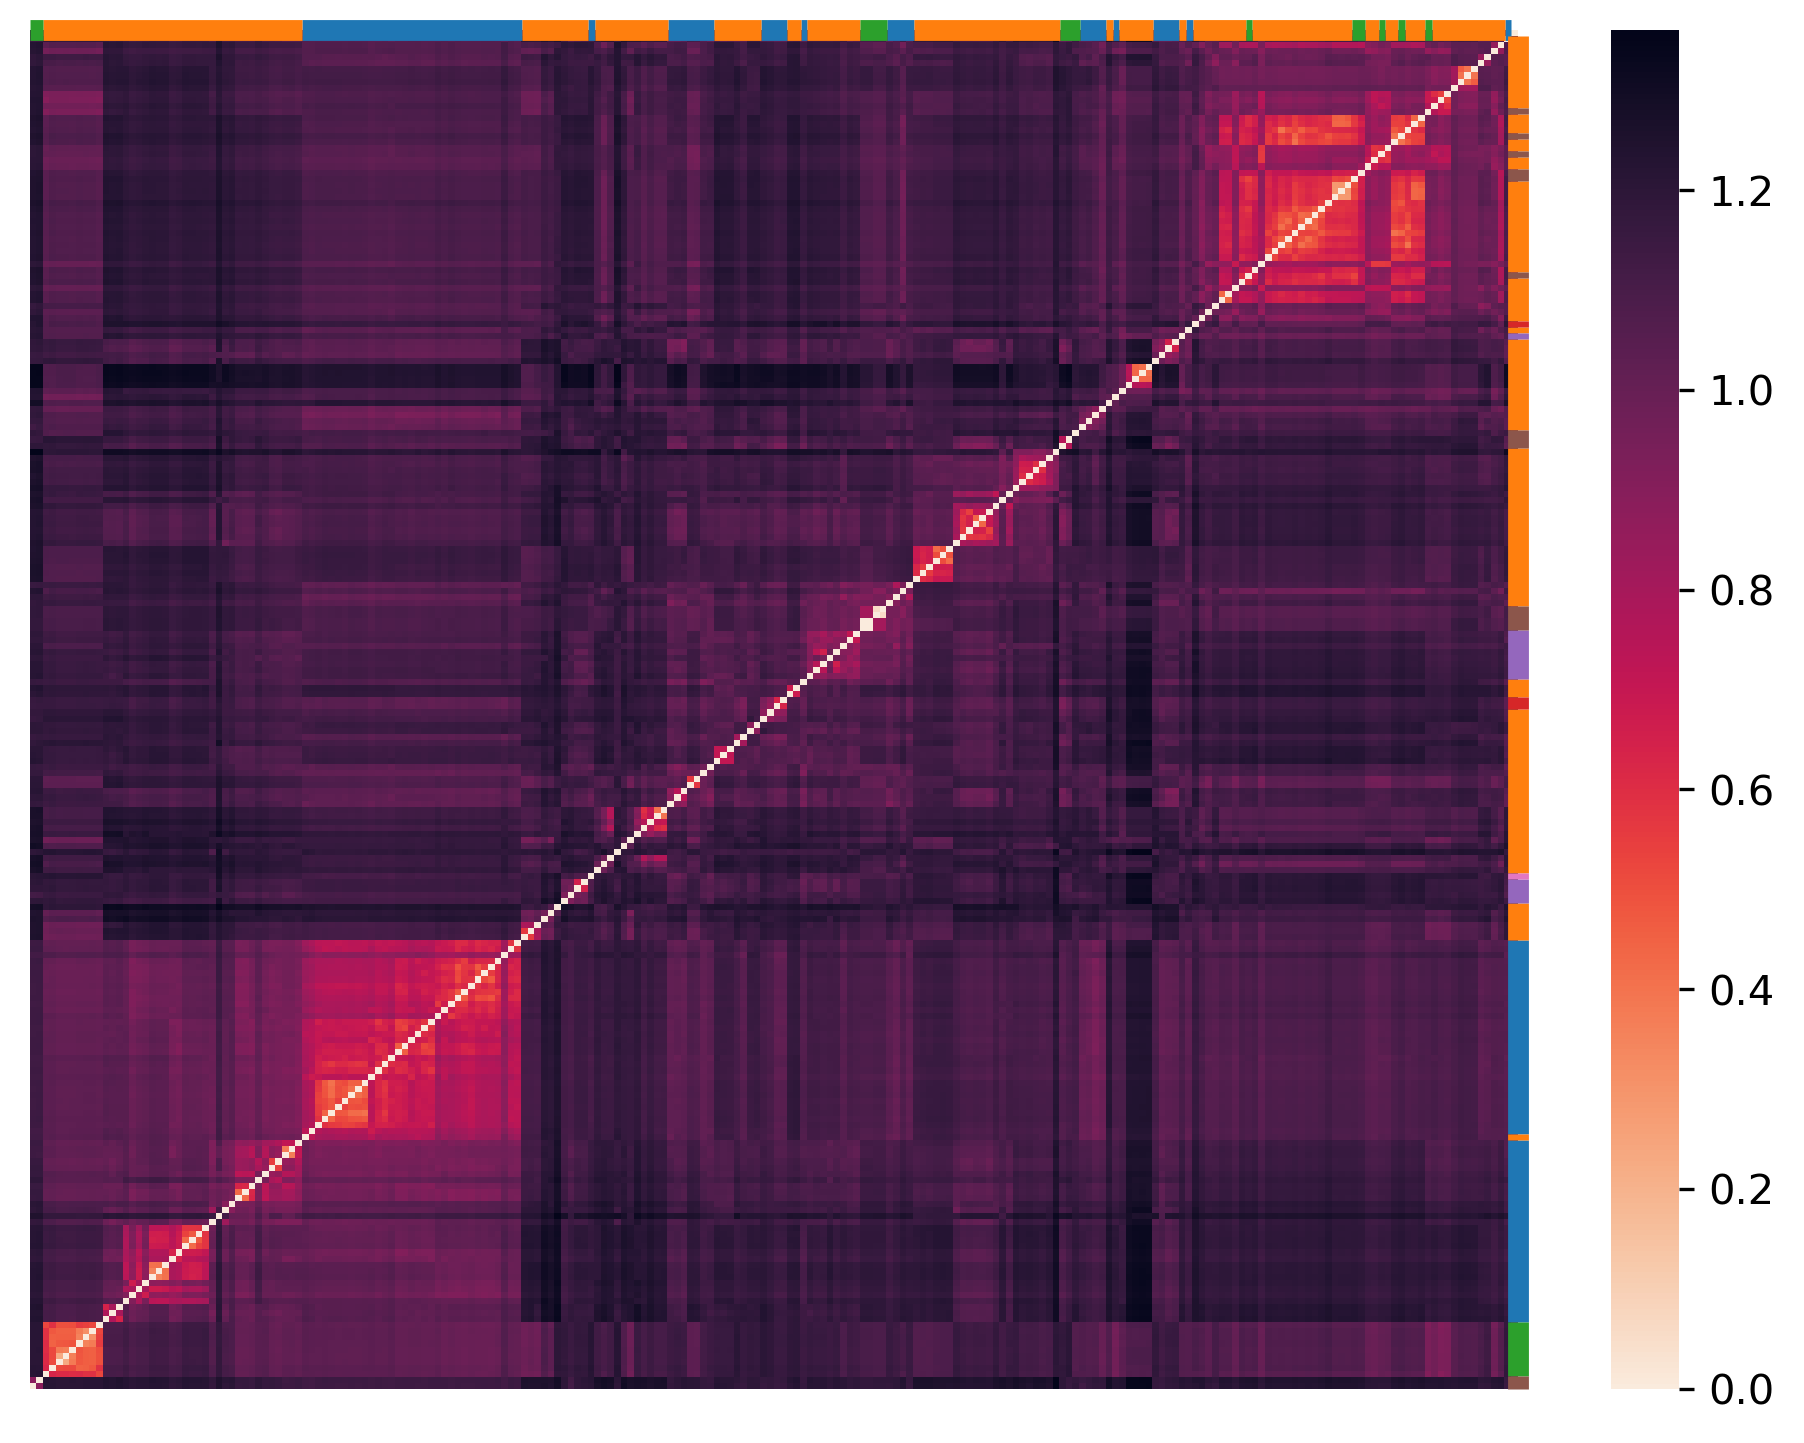

In [38]:
overlap_df = pd.DataFrame(calcEnsembleSpectralOverlaps(gnms,distance=True))
cmap = sns.cm.rocket_r
figure(figsize=(8, 6), dpi=300)
ax = sns.heatmap(data=overlap_df, cmap=cmap)
plt.ylim(0,len(seqid_matrix))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
showDomainBar(activity_labels,loc=1,text=False)
showDomainBar(species_labels,loc=1,axis='y',text=False)
plt.savefig(FIG + 'New_GPCR-dali_reordered-seq_dynamics.png',dpi=300)

#### Reorder ensemble based on structural similarity (RMSD)

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
gnms = loadModeEnsemble('New_GPCR_gnms-dali.modeens.npz')

In [ ]:
new_labels = ens.getLabels()

rmsds = ens.getRMSDs(pairwise=True)
rmsd_tree = calcTree(new_labels, 1. - rmsds, method='upgma')


reordered_seqids, seqid_reordering_indices = reorderMatrix(new_labels, rmsds, rmsd_tree)


new_labels = list(np.array(new_labels)[seqid_reordering_indices])

ens = ens[seqid_reordering_indices]
saveEnsemble(ens, 'New_GPCR-dali_reordered-rmsd')
writePDB('New_GPCR-dali_reordered-rmsd', ens)

gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce')
saveModeEnsemble(gnms, 'New_GPCR-dali_reordered-rmsd', atoms=True)

In [ ]:
msa = ens.getMSA()
seqid_matrix = buildSeqidMatrix(msa)
sns.heatmap(data=seqid_matrix)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-rmsd_sequence.png',dpi=300)

In [ ]:
rmsds = ens.getRMSDs(pairwise=True)
rmsd_df = pd.DataFrame(ens.getRMSDs(pairwise=True))
cmap = sns.cm.rocket_r
sns.heatmap(data=rmsd_df, cmap=cmap)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-rmsd_rmsds.png',dpi=300)

In [ ]:
overlap_df = pd.DataFrame(calcEnsembleSpectralOverlaps(gnms,distance=True))
sns.heatmap(data=overlap_df)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-rmsd_dynamics.png',dpi=300)

#### Reorder ensemble based on dynamic similarity (spectral overlap)

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
gnms = loadModeEnsemble('New_GPCR_gnms-dali.modeens.npz')

In [ ]:
new_labels = ens.getLabels()

overlap_df = pd.DataFrame(calcEnsembleSpectralOverlaps(gnms,distance=True))
overlaps = overlap_df.to_numpy()
overlap_tree = calcTree(new_labels, 1. - overlaps, method='upgma')


reordered_seqids, seqid_reordering_indices = reorderMatrix(new_labels, overlaps, overlap_tree)


new_labels = list(np.array(new_labels)[seqid_reordering_indices])

ens = ens[seqid_reordering_indices]
saveEnsemble(ens, 'New_GPCR-dali_reordered-overlap')
writePDB('New_GPCR-dali_reordered-overlap', ens)

gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce')
saveModeEnsemble(gnms, 'New_GPCR-dali_reordered-overlap', atoms=True)

In [ ]:
msa = ens.getMSA()
seqid_matrix = buildSeqidMatrix(msa)
sns.heatmap(data=seqid_matrix)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-overlap_sequence.png',dpi=300)

In [ ]:
rmsds = ens.getRMSDs(pairwise=True)
rmsd_df = pd.DataFrame(ens.getRMSDs(pairwise=True))
cmap = sns.cm.rocket_r
sns.heatmap(data=rmsd_df, cmap=cmap)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-overlap_rmsds.png',dpi=300)

In [ ]:
overlap_df = pd.DataFrame(calcEnsembleSpectralOverlaps(gnms,distance=True))
sns.heatmap(data=overlap_df)
plt.ylim(0,len(seqid_matrix))
plt.savefig(FIG + 'New_GPCR-dali_reordered-overlap_dynamics.png',dpi=300)

## Collectivity & conservation calculation

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce', n_modes=None)
saveModeEnsemble(gnms, 'New_GPCR_gnms-dali-full', atoms=True)
gnms = loadModeEnsemble('New_GPCR_gnms-dali-full.modeens.npz')

In [ ]:
# Get mode conservation values
sig_overlaps = calcSignatureOverlaps(gnms)
r, c = np.triu_indices(sig_overlaps.shape[1], k=1)
overlap_triu = sig_overlaps[:, r, c]

meanV = overlap_triu.mean(axis=1)
stdV = overlap_triu.std(axis=1)

In [ ]:
# Get mode collectivity values
coll = calcSignatureCollectivity(gnms)
mode_coll = [ coll[:,x].mean() for x in range(len(coll[0]))]

In [ ]:
plot(meanV, label='conservation',color='green')
plot(mode_coll, label='collectivity',color='red')
plt.xlabel('Mode index', fontsize=14)
#plt.xticks([0,10,20,30,40,50,60,70],['1','11','21','31','41','51','61','71'],fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.savefig(FIG + 'New_GPCR-dali_mode_conservation.png', dpi=300)

## Ensemble Analysis

In [ ]:
## Transmembrane only (Class A - 7DHI)
resdomains = ['' for x in range(290)]
for x in range(len(resdomains)):
    pos = x+30
    if pos < 35:
        resdomains[x] = 'EC1'
    elif pos > 34 and pos < 59:
        resdomains[x] = 'TM1'
    elif pos > 58 and pos < 72:
        resdomains[x] = 'IC1'
    elif pos > 71 and pos < 96:
        resdomains[x] = 'TM2'
    elif pos > 95 and pos < 107:
        resdomains[x] = 'EC2'
    elif pos > 106 and pos < 130:
        resdomains[x] = 'TM3'
    elif pos > 129 and pos < 151:
        resdomains[x] = 'IC2'
    elif pos > 150 and pos < 175:
        resdomains[x] = 'TM4'
    elif pos > 174 and pos < 197:
        resdomains[x] = 'EC3'
    elif pos > 196 and pos < 221:
        resdomains[x] = 'TM5'
    elif pos > 220 and pos < 275:
        resdomains[x] = 'IC3'
    elif pos > 274 and pos < 299:
        resdomains[x] = 'TM6'
    elif pos > 298 and pos < 306:
        resdomains[x] = 'EC4'
    elif pos > 305 and pos < 330:
        resdomains[x] = 'TM7'
    elif pos > 329:
        resdomains[x] = 'Cyto'

In [40]:
## Transmembrane only (Class A - 7DHI)
resdomains = ['' for x in range(290)]
for x in range(len(resdomains)):
    pos = x+30
    if pos < 35:
        resdomains[x] = 'EC1'
    elif pos > 34 and pos < 59:
        resdomains[x] = 'TM1'
    elif pos > 58 and pos < 72:
        resdomains[x] = 'IC1'
    elif pos > 71 and pos < 96:
        resdomains[x] = 'TM2'
    elif pos > 95 and pos < 107:
        resdomains[x] = 'EC2'
    elif pos > 106 and pos < 130:
        resdomains[x] = 'TM3'
    elif pos > 129 and pos < 151:
        resdomains[x] = 'IC2'
    elif pos > 150 and pos < 175:
        resdomains[x] = 'TM4'
    elif pos > 174 and pos < 197:
        resdomains[x] = 'EC3'
    elif pos > 196 and pos < 221:
        resdomains[x] = 'TM5'
    elif pos > 220 and pos < 242:
        resdomains[x] = 'IC3'
    elif pos > 241 and pos < 266:
        resdomains[x] = 'TM6'
    elif pos > 265 and pos < 273:
        resdomains[x] = 'EC4'
    elif pos > 272 and pos < 297:
        resdomains[x] = 'TM7'
    elif pos > 296:
        resdomains[x] = 'Cyto'

In [32]:
## Transmembrane only (Class A - 7DHI)
resdomains = ['' for x in range(290)]
for x in range(len(resdomains)):
    pos = x+30
    if pos < 35:
        resdomains[x] = 'EC'
    elif pos > 34 and pos < 59:
        resdomains[x] = 'TM'
    elif pos > 58 and pos < 72:
        resdomains[x] = 'IC'
    elif pos > 71 and pos < 96:
        resdomains[x] = 'TM'
    elif pos > 95 and pos < 107:
        resdomains[x] = 'EC'
    elif pos > 106 and pos < 130:
        resdomains[x] = 'TM'
    elif pos > 129 and pos < 151:
        resdomains[x] = 'IC'
    elif pos > 150 and pos < 175:
        resdomains[x] = 'TM'
    elif pos > 174 and pos < 197:
        resdomains[x] = 'EC'
    elif pos > 196 and pos < 221:
        resdomains[x] = 'TM'
    elif pos > 220 and pos < 242:
        resdomains[x] = 'IC'
    elif pos > 241 and pos < 266:
        resdomains[x] = 'TM'
    elif pos > 265 and pos < 273:
        resdomains[x] = 'EC'
    elif pos > 272 and pos < 297:
        resdomains[x] = 'TM'
    elif pos > 296:
        resdomains[x] = 'IC'

In [ ]:
showSignatureSqFlucts?

In [ ]:
gnms.getAtoms()

In [ ]:
gnms.getAtoms()

In [3]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
ens.getIndices()

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali.ens.npz')
gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce', n_modes=None)

In [ ]:
for i in range(len(ens)):
    gnm = calcENM(ens[i], model='GNM', trim='reduce', n_modes=None)[0]
    print(ens[i].getLabel() + ' ' + str(gnm.getEigvals()[:5]))

In [154]:
gnm = calcENM(ens[0], model='GNM', trim='reduce', n_modes=None)

@> Kirchhoff was built in 0.01s.
@> 289 modes were calculated in 0.02s.


In [60]:
gnms[:,:3]

<ModeEnsemble: 224 modesets (3 modes, 290 atoms)>

In [65]:
gnms[:,:3].getEigvals().shape

(224, 3)

In [66]:
np.savetxt(FIG + "gnm_eigvals_1-3.csv", gnms[:,:3].getEigvals(), delimiter=",")

In [67]:
np.savetxt(FIG + "gnm_eigvals_4-20.csv", gnms[:,3:20].getEigvals(), delimiter=",")

In [68]:
np.savetxt(FIG + "gnm_eigvals_last10.csv", gnms[:,-10:].getEigvals(), delimiter=",")

In [136]:
# Check ensemble for structures with multiple zero eigenvalues
for i in range(len(gnms)):
    print(str(i) + ' ' + str(len(gnms[i].getEigvals())) + ' ' + str(gnms[i].getEigvals()[:3]))

0 233 [0.3716416  0.68491315 0.97314188]
1 233 [0.47799601 0.79870666 0.9336852 ]
2 233 [23.4461677   0.70288705  1.03281973]
3 233 [24.02651502  0.71071016  1.06519232]
4 233 [0.60173092 0.87196597 1.11250128]
5 233 [0.08984487 0.73753583 0.92194717]
6 233 [0.48294134 0.80456841 1.15319339]
7 233 [0.33678054 0.79475537 0.95713875]
8 233 [0.59219956 0.87271061 1.30679068]
9 233 [0.62391969 0.98371701 1.91228967]
10 233 [0.3225056  0.76858717 0.89710016]
11 233 [0.3960703  0.78534939 1.03887974]
12 233 [23.75503612  0.67347188  0.90965055]
13 233 [0.57052268 0.91741305 1.25285222]
14 233 [22.69605275  0.68090513  1.02324914]
15 233 [22.95792015  0.67126454  1.3203882 ]
16 233 [0.09031441 0.70495444 0.95401571]
17 233 [0.48365882 0.79061696 1.25037306]
18 233 [0.59727382 1.06324507 1.39183913]
19 233 [ 0.7238678   1.06558375 24.46750919]
20 233 [0.41517136 0.89978132 1.40196051]
21 233 [0.61914509 1.11200335 1.5257859 ]
22 233 [24.20595195  0.65765708  1.97472196]
23 233 [0.62977457 0.98

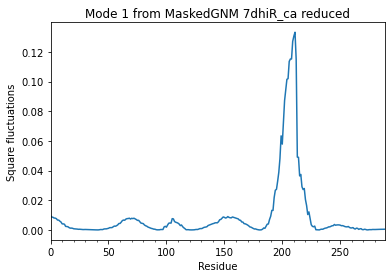

In [137]:
showSqFlucts(gnms[0][0]);

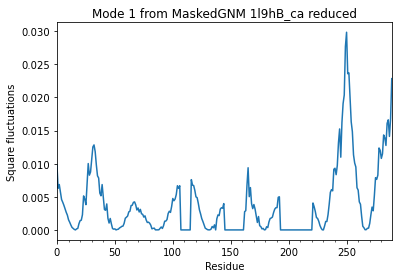

In [165]:
showSqFlucts(gnms[-1][1]);

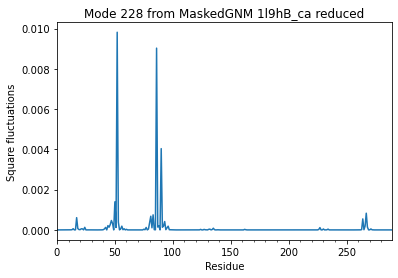

In [138]:
showSqFlucts(gnms[-1][0]);

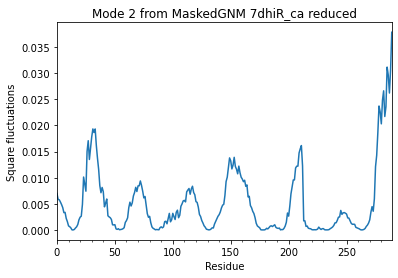

In [139]:
showSqFlucts(gnms[0][1]);

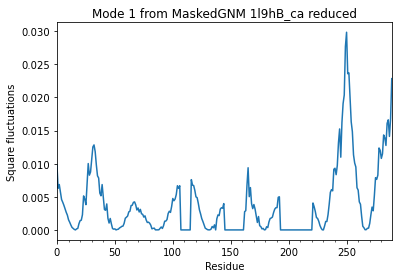

In [140]:
showSqFlucts(gnms[-1][1]);

In [164]:
gnms[-1][1].getEigvec()

array([ 0.09486051,  0.07593098,  0.0792556 ,  0.0725037 ,  0.06482193,
        0.06187404,  0.05834927,  0.05381921,  0.04936156,  0.04517432,
        0.03746731,  0.03264512,  0.02608037,  0.01869634,  0.01408752,
        0.00812866, -0.00208695, -0.01204367, -0.01453421, -0.02940719,
       -0.03590204, -0.03660593, -0.04578297, -0.06859773, -0.06526894,
       -0.05912833, -0.07891228, -0.09583798, -0.08705069, -0.08953031,
       -0.09887425, -0.10714192, -0.10846485, -0.10409369, -0.09487099,
       -0.08651947, -0.084754  , -0.07142467, -0.068717  , -0.07921643,
       -0.06695444, -0.05309669, -0.05214986, -0.05997742, -0.04011422,
       -0.03082082, -0.0398045 , -0.02875872, -0.01360883, -0.01027833,
       -0.01209814,  0.00021896,  0.008146  ,  0.00991793,  0.01653225,
        0.01916525,  0.02223118,  0.02291968,  0.03026141,  0.04016068,
        0.04192121,  0.04384971,  0.04991829,  0.05084633,  0.05804978,
        0.05840852,  0.06174989,  0.062272  ,  0.05889816,  0.05

(0, 3)


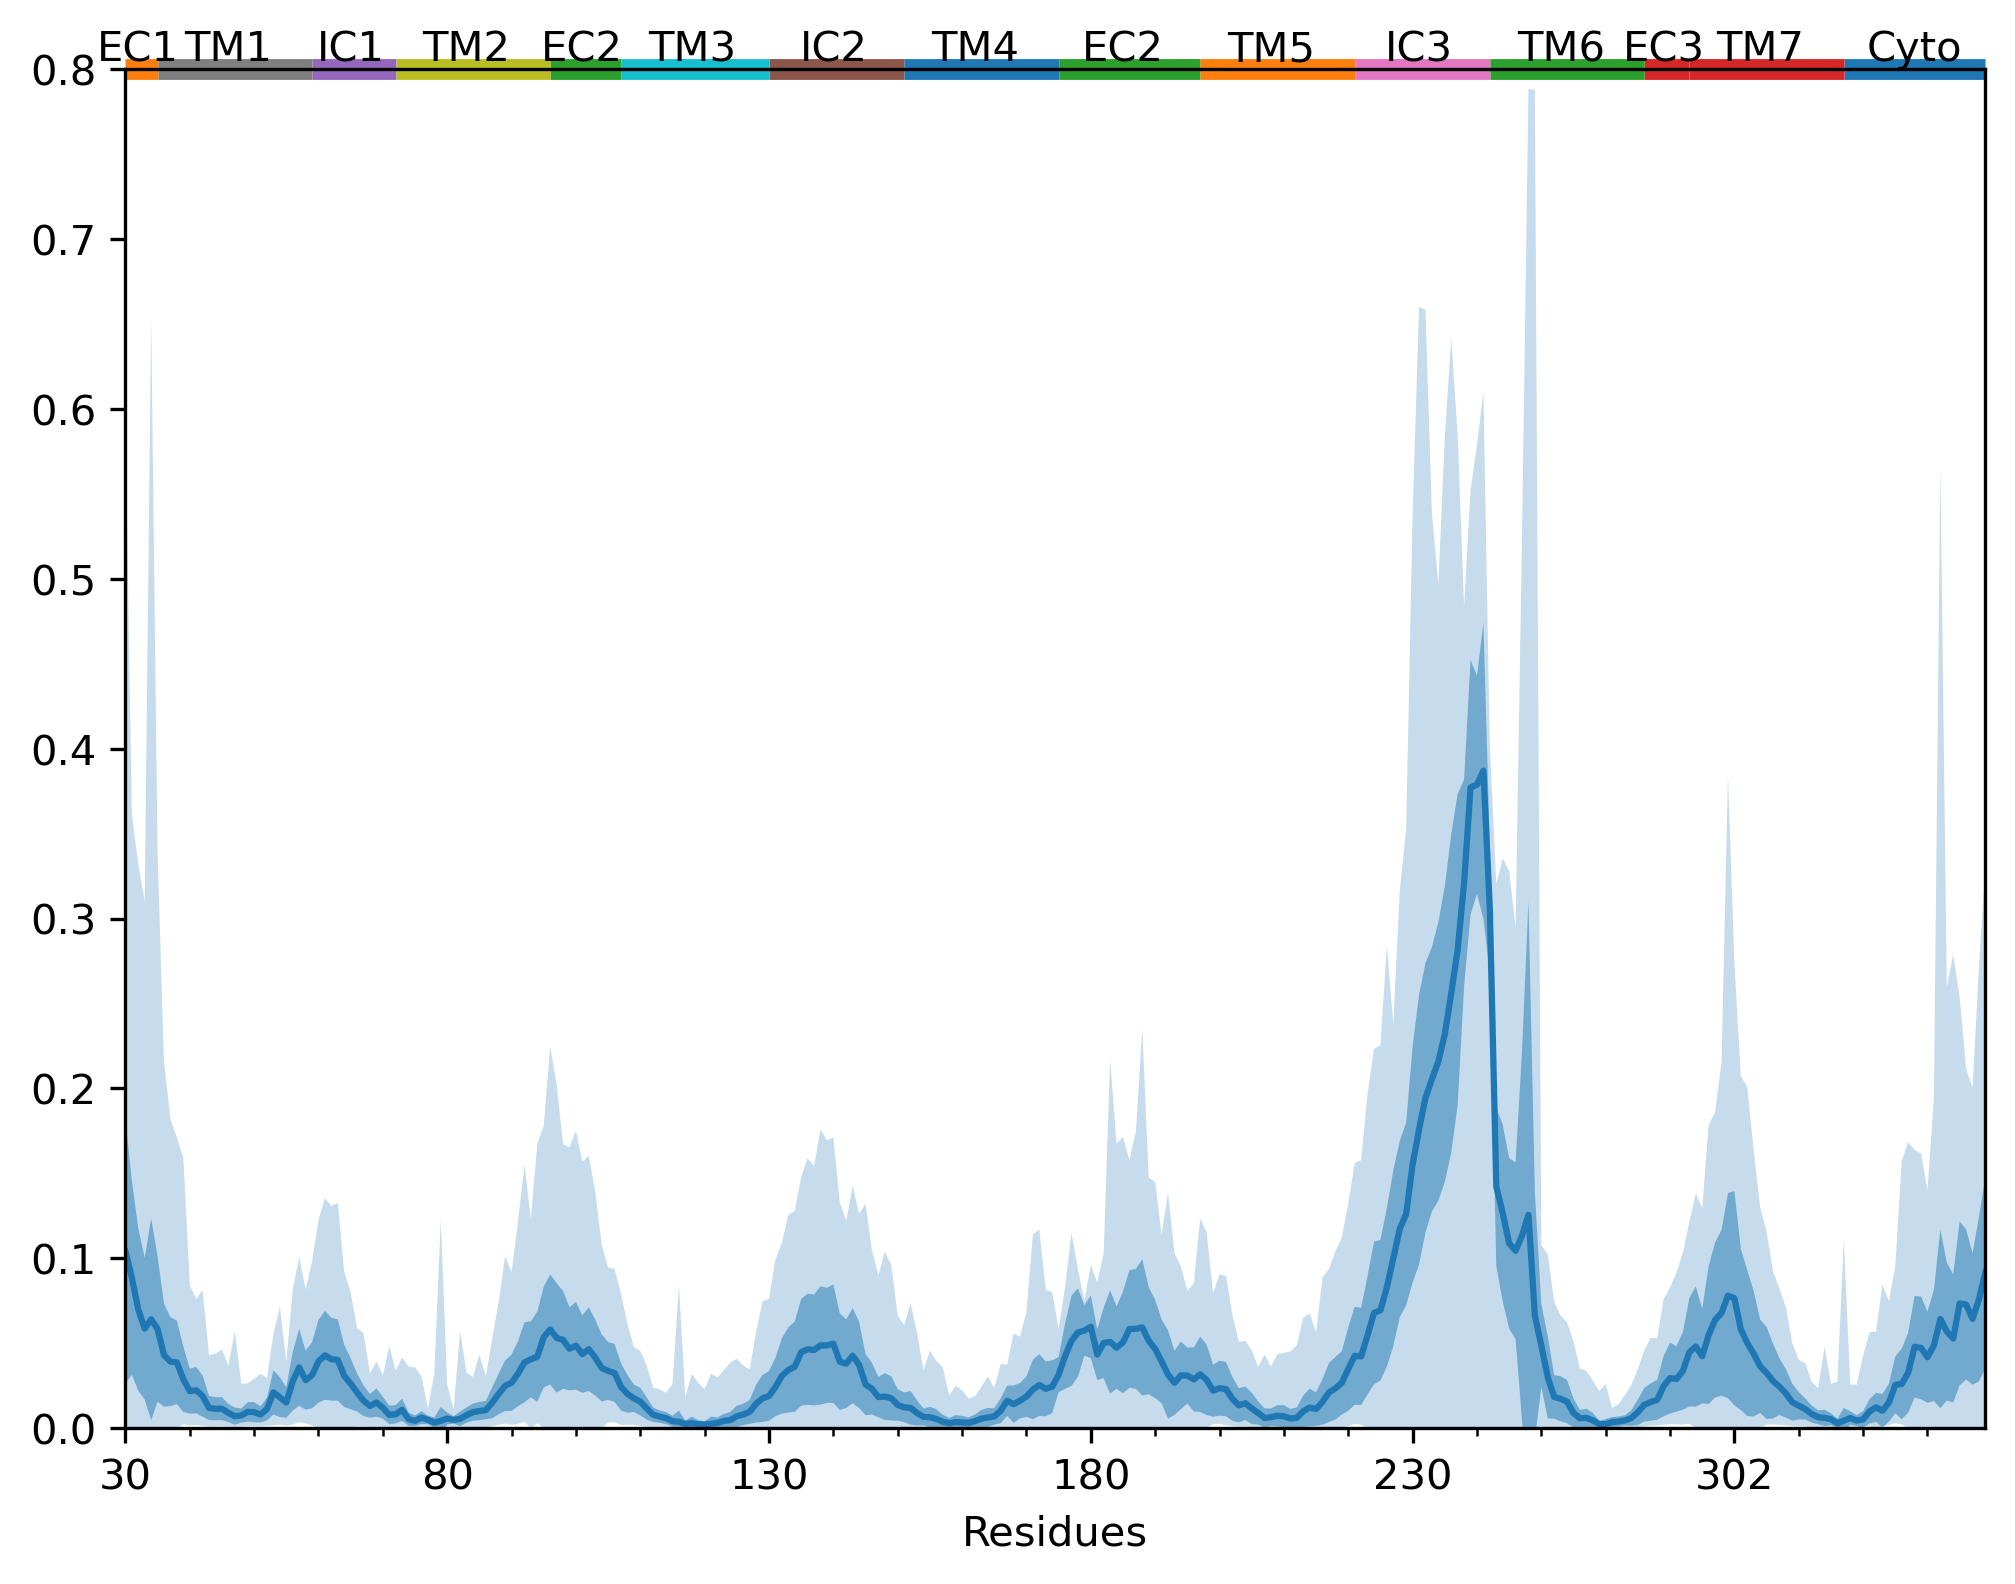

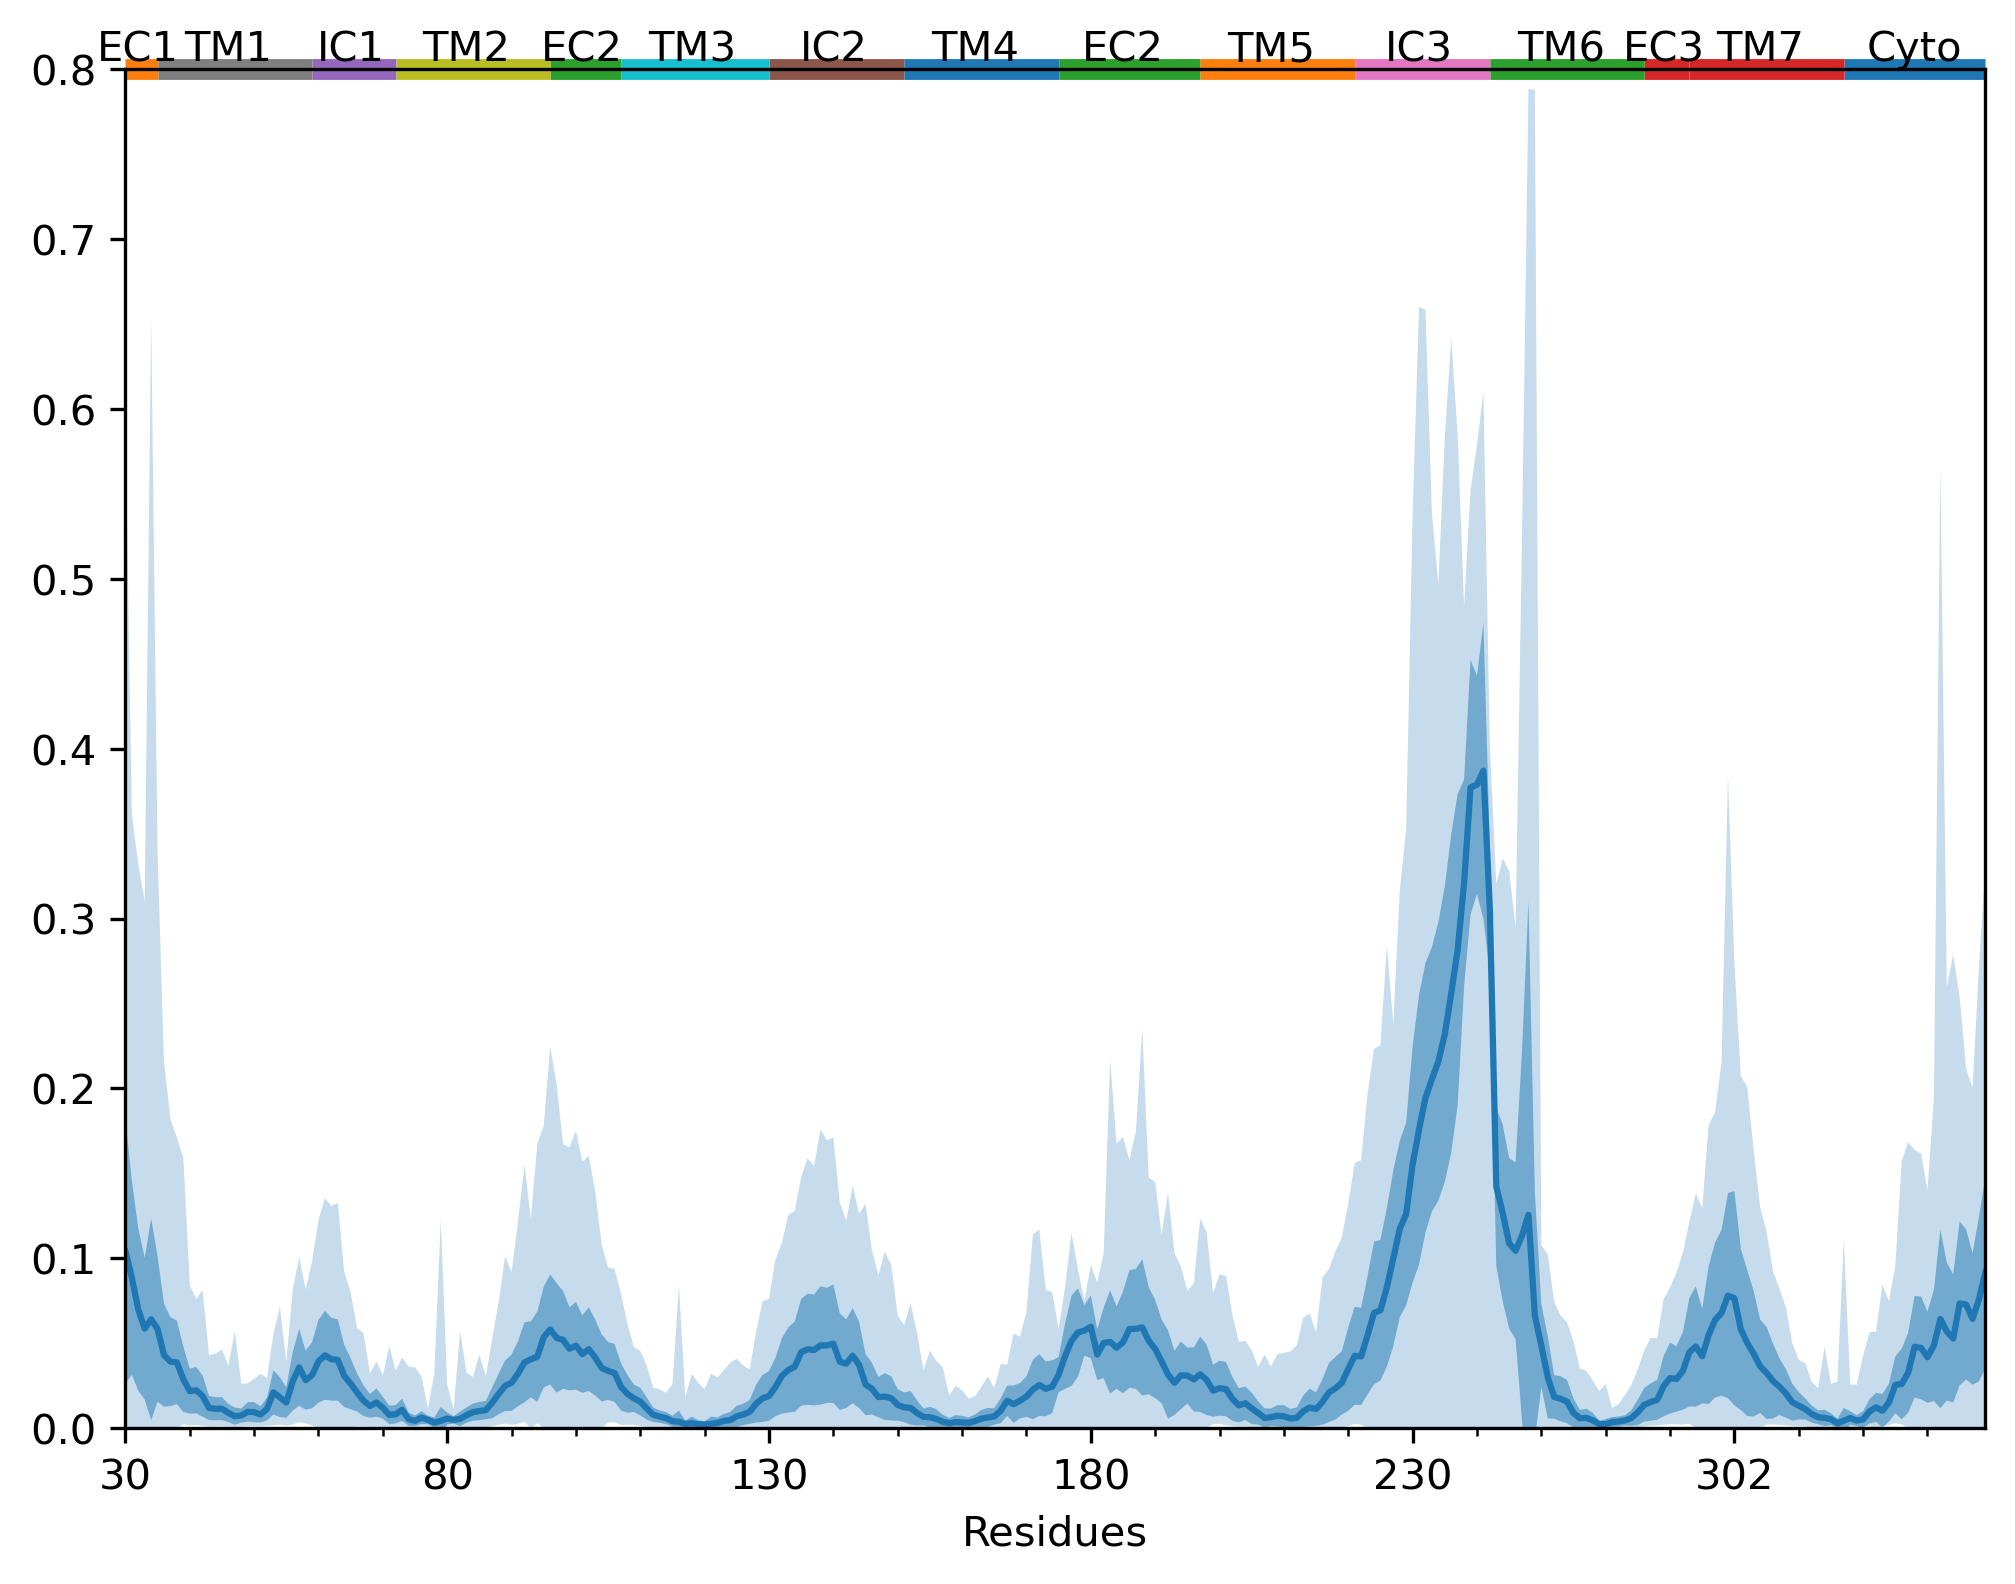

(3, 20)


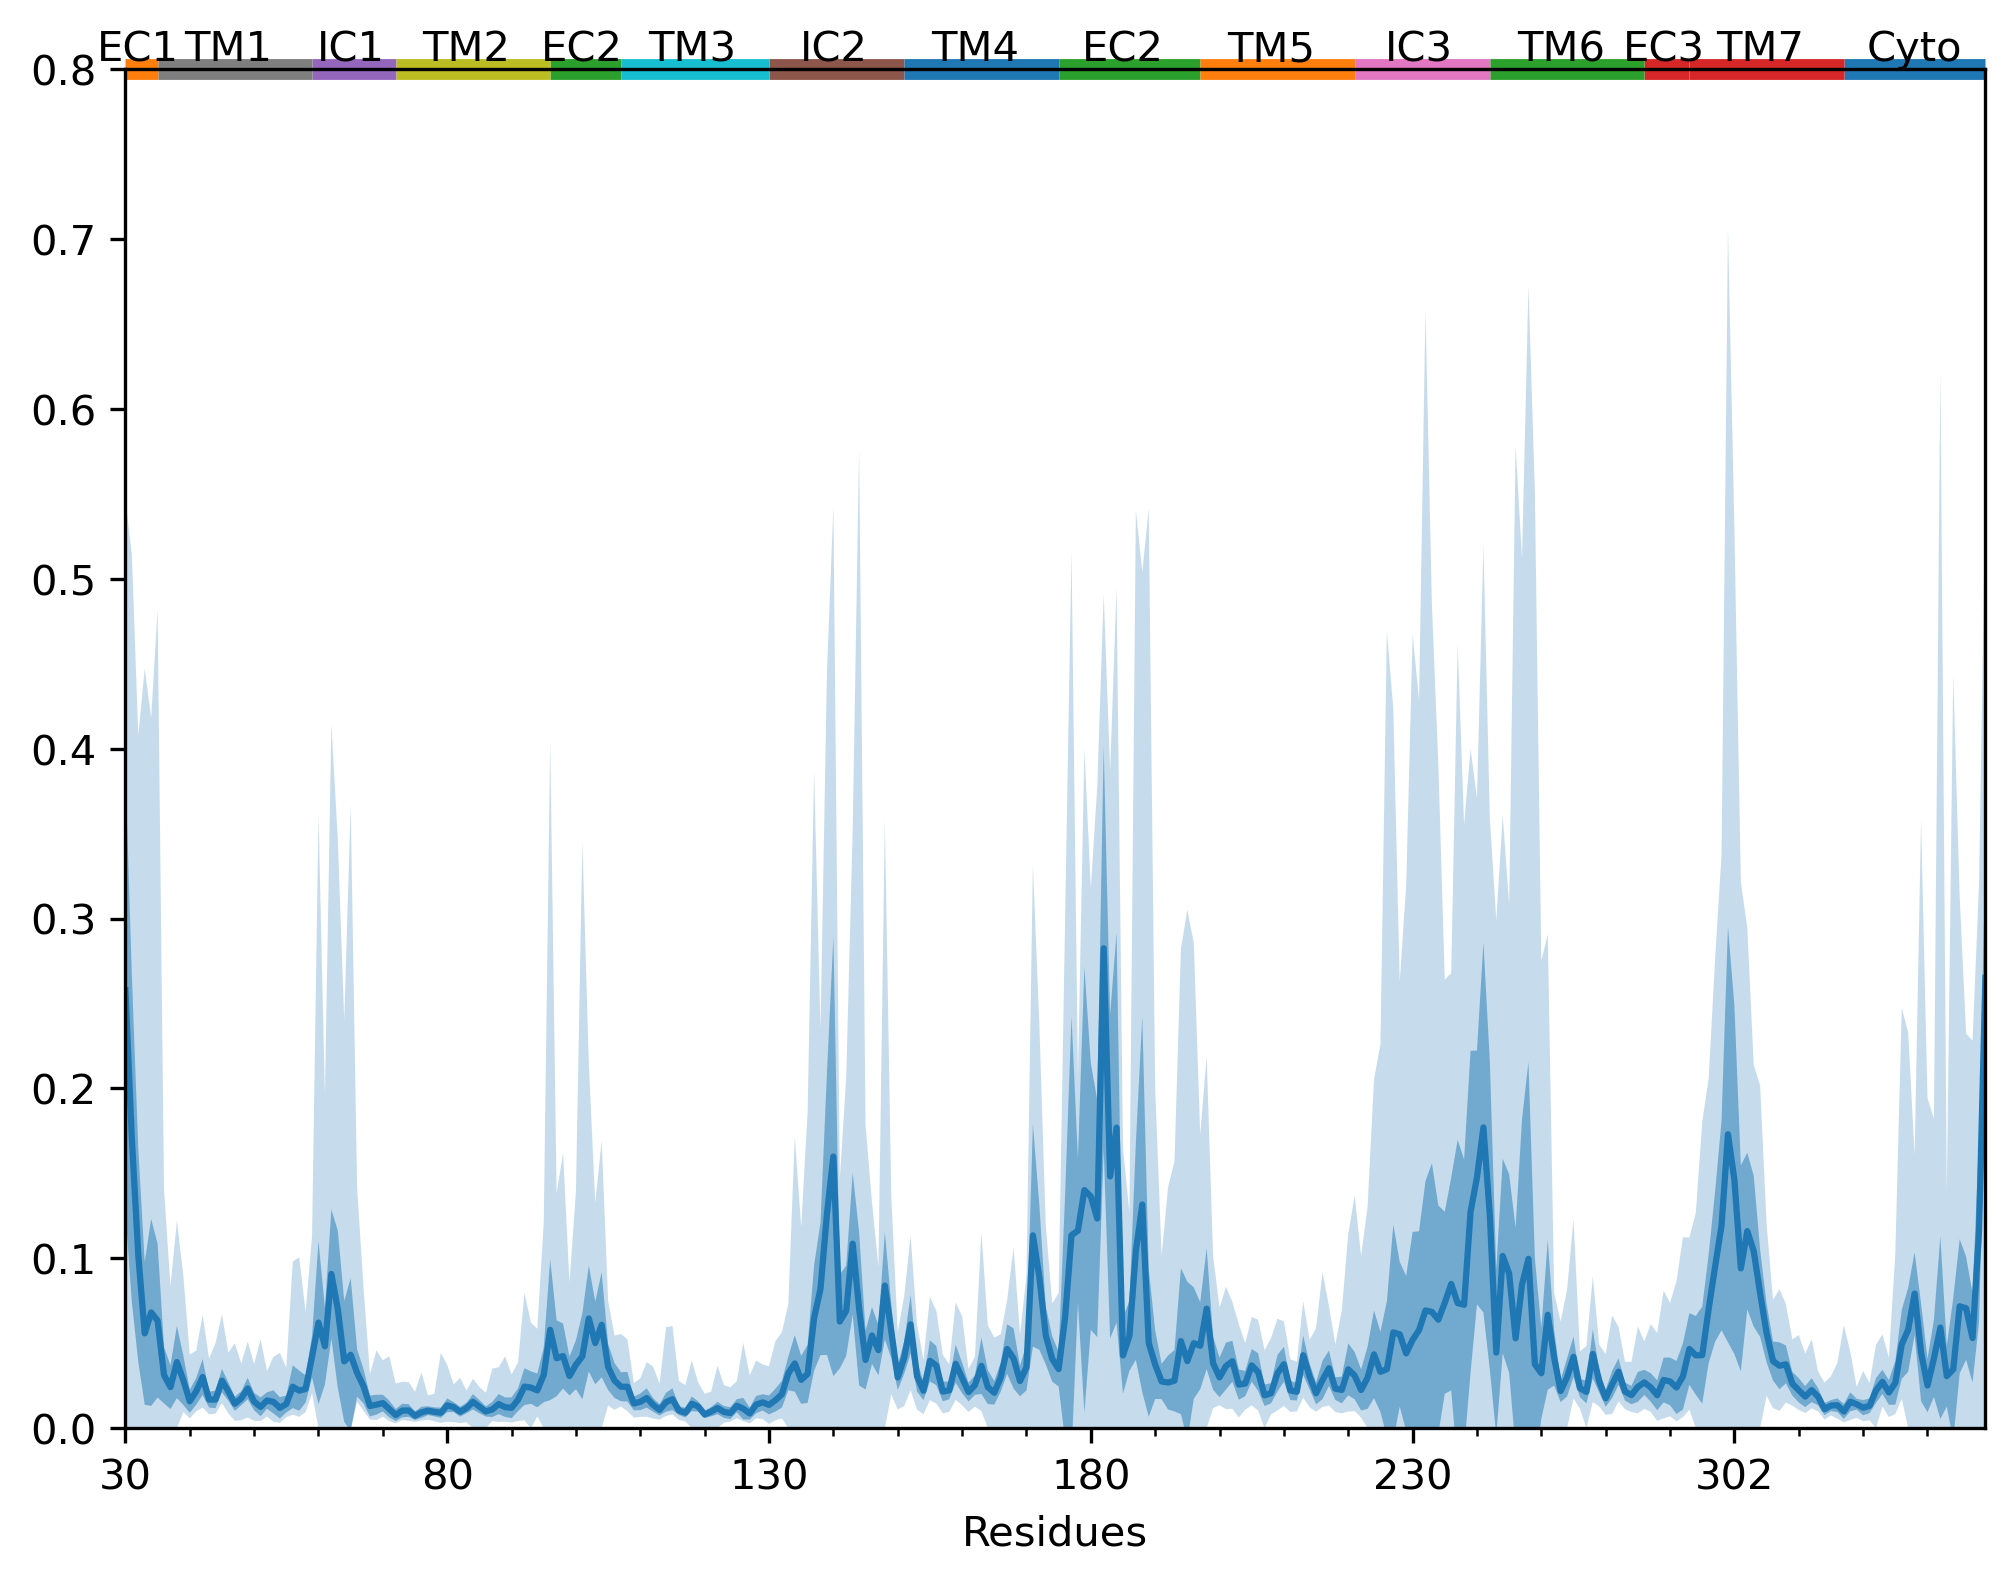

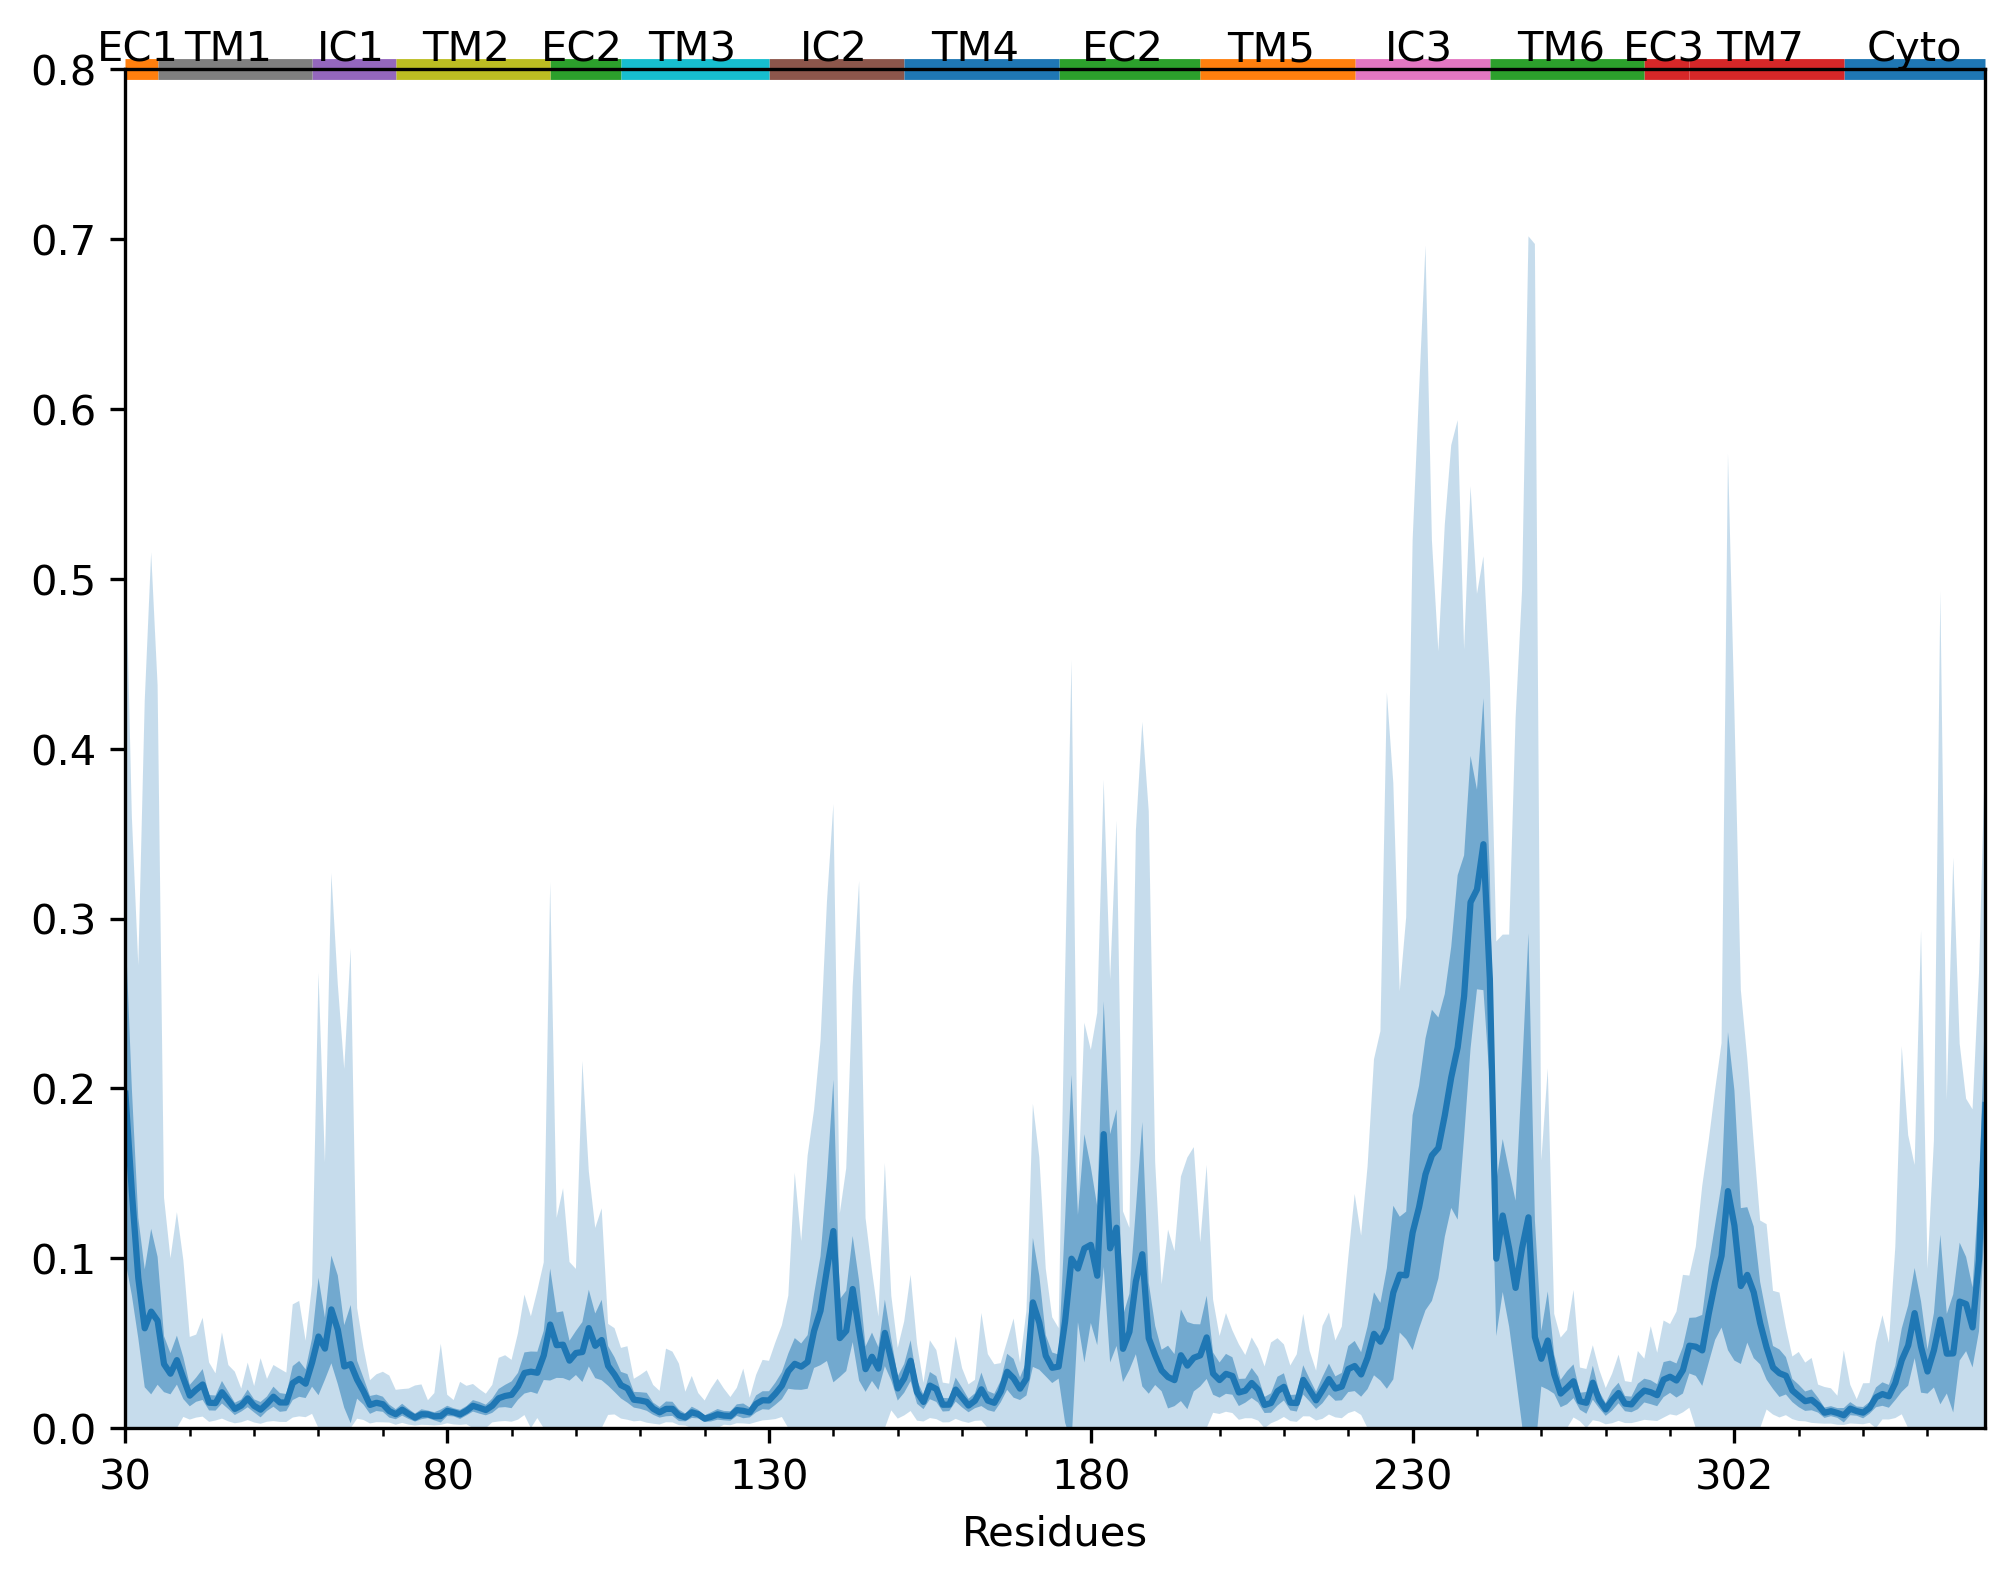

(20, 60)


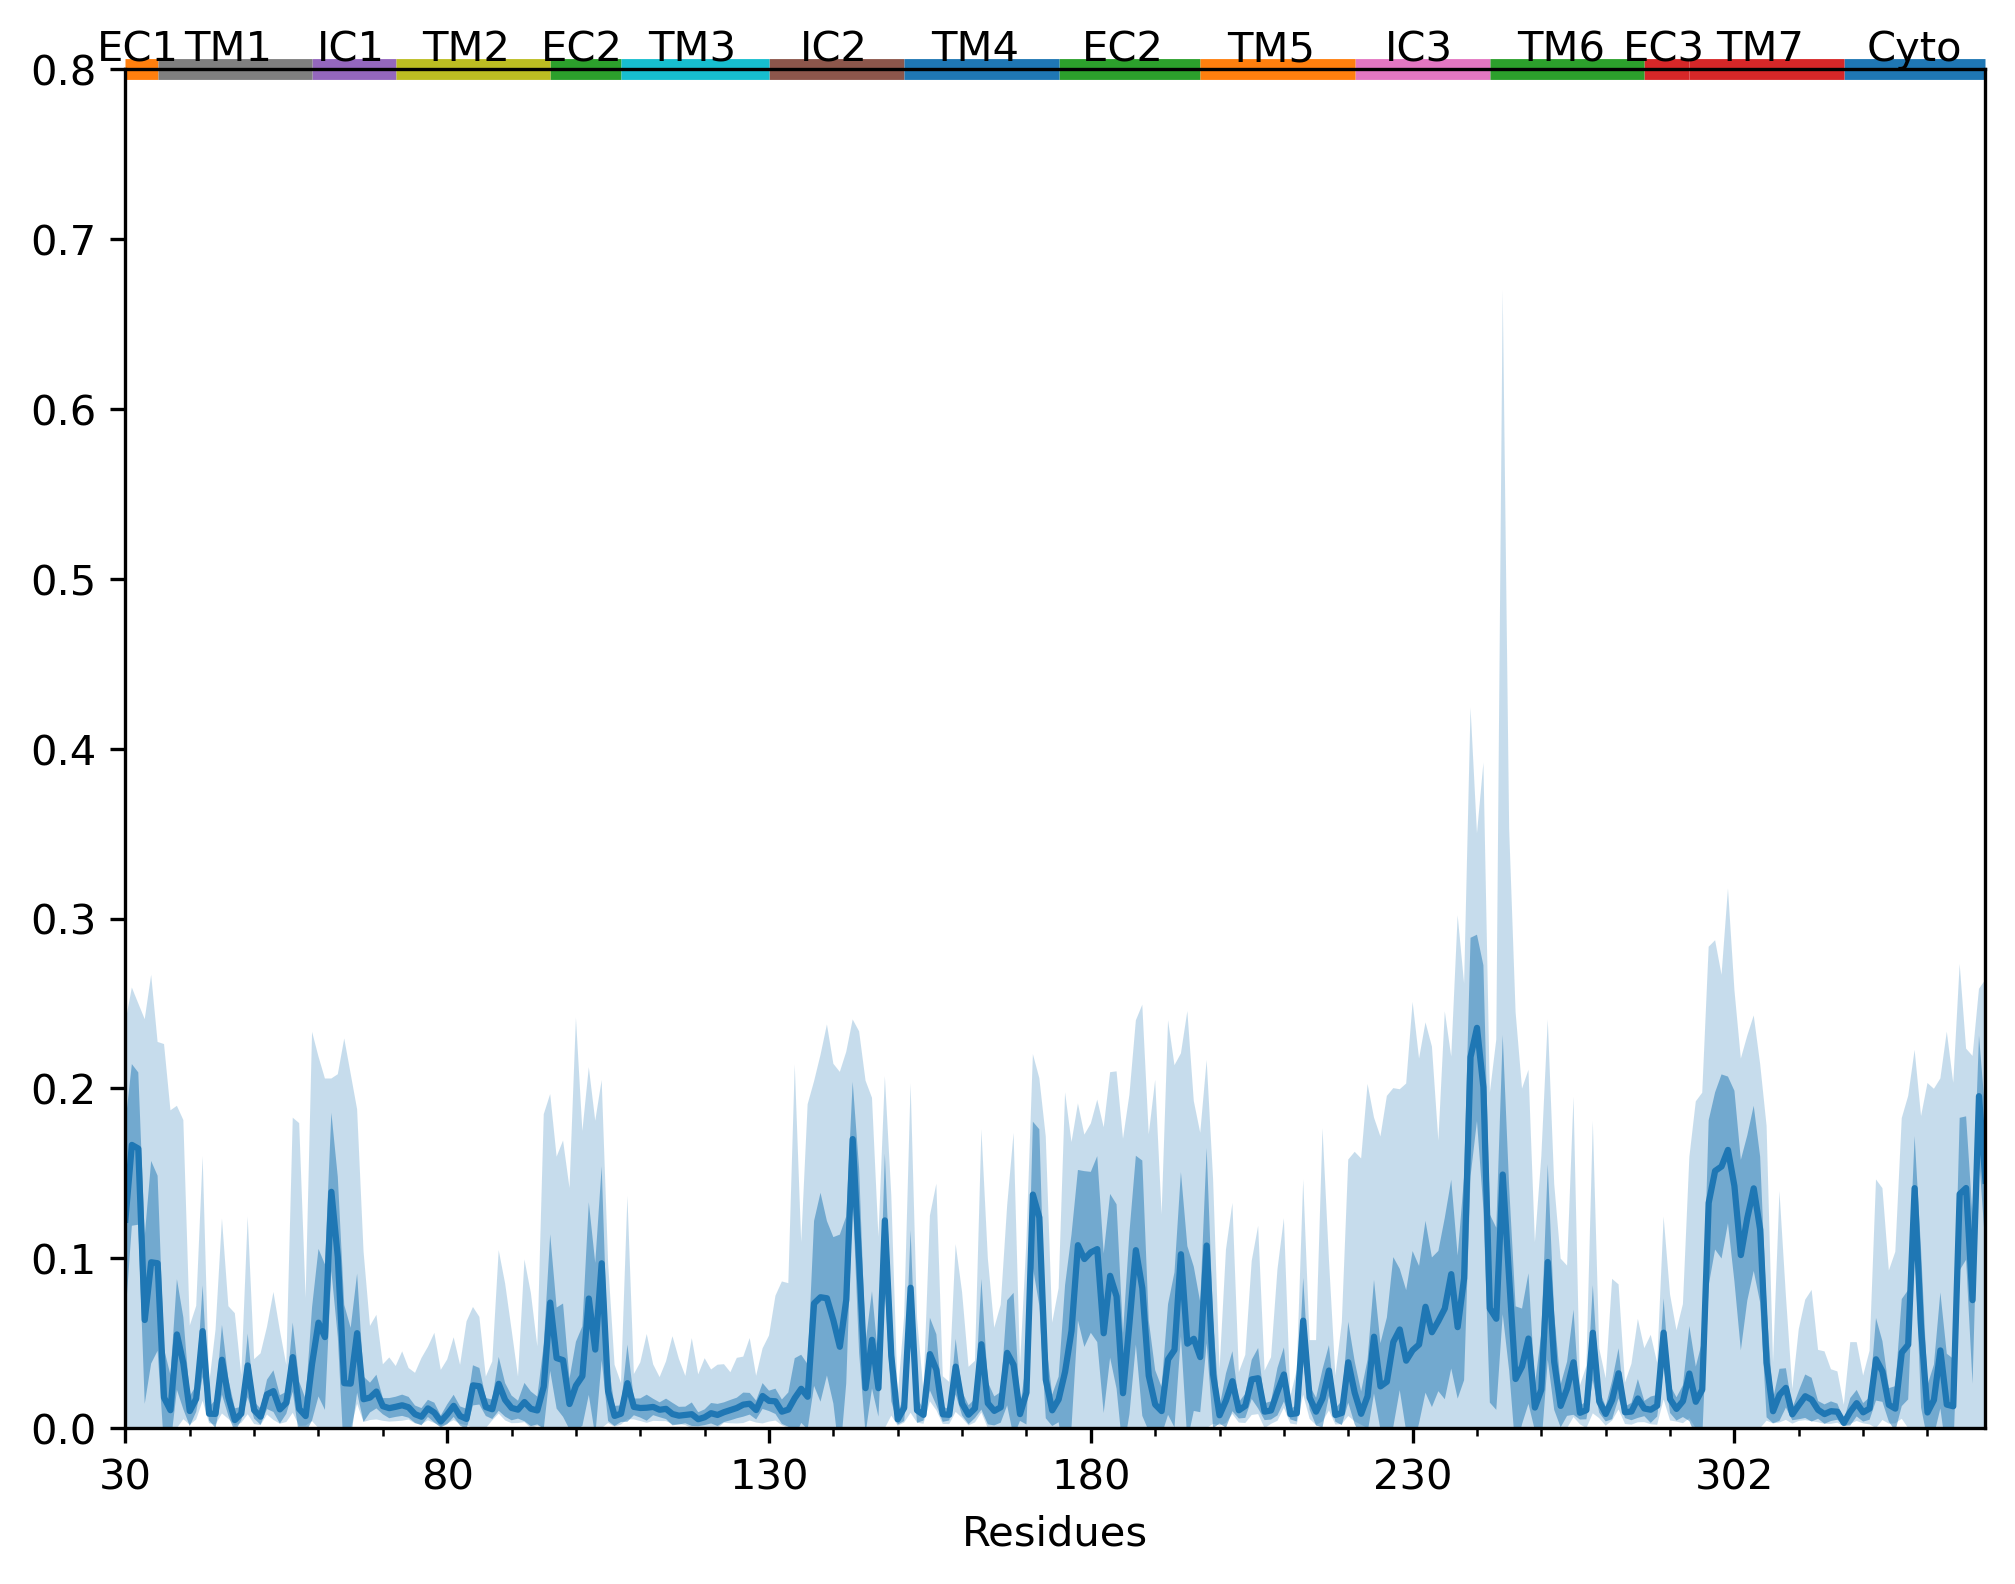

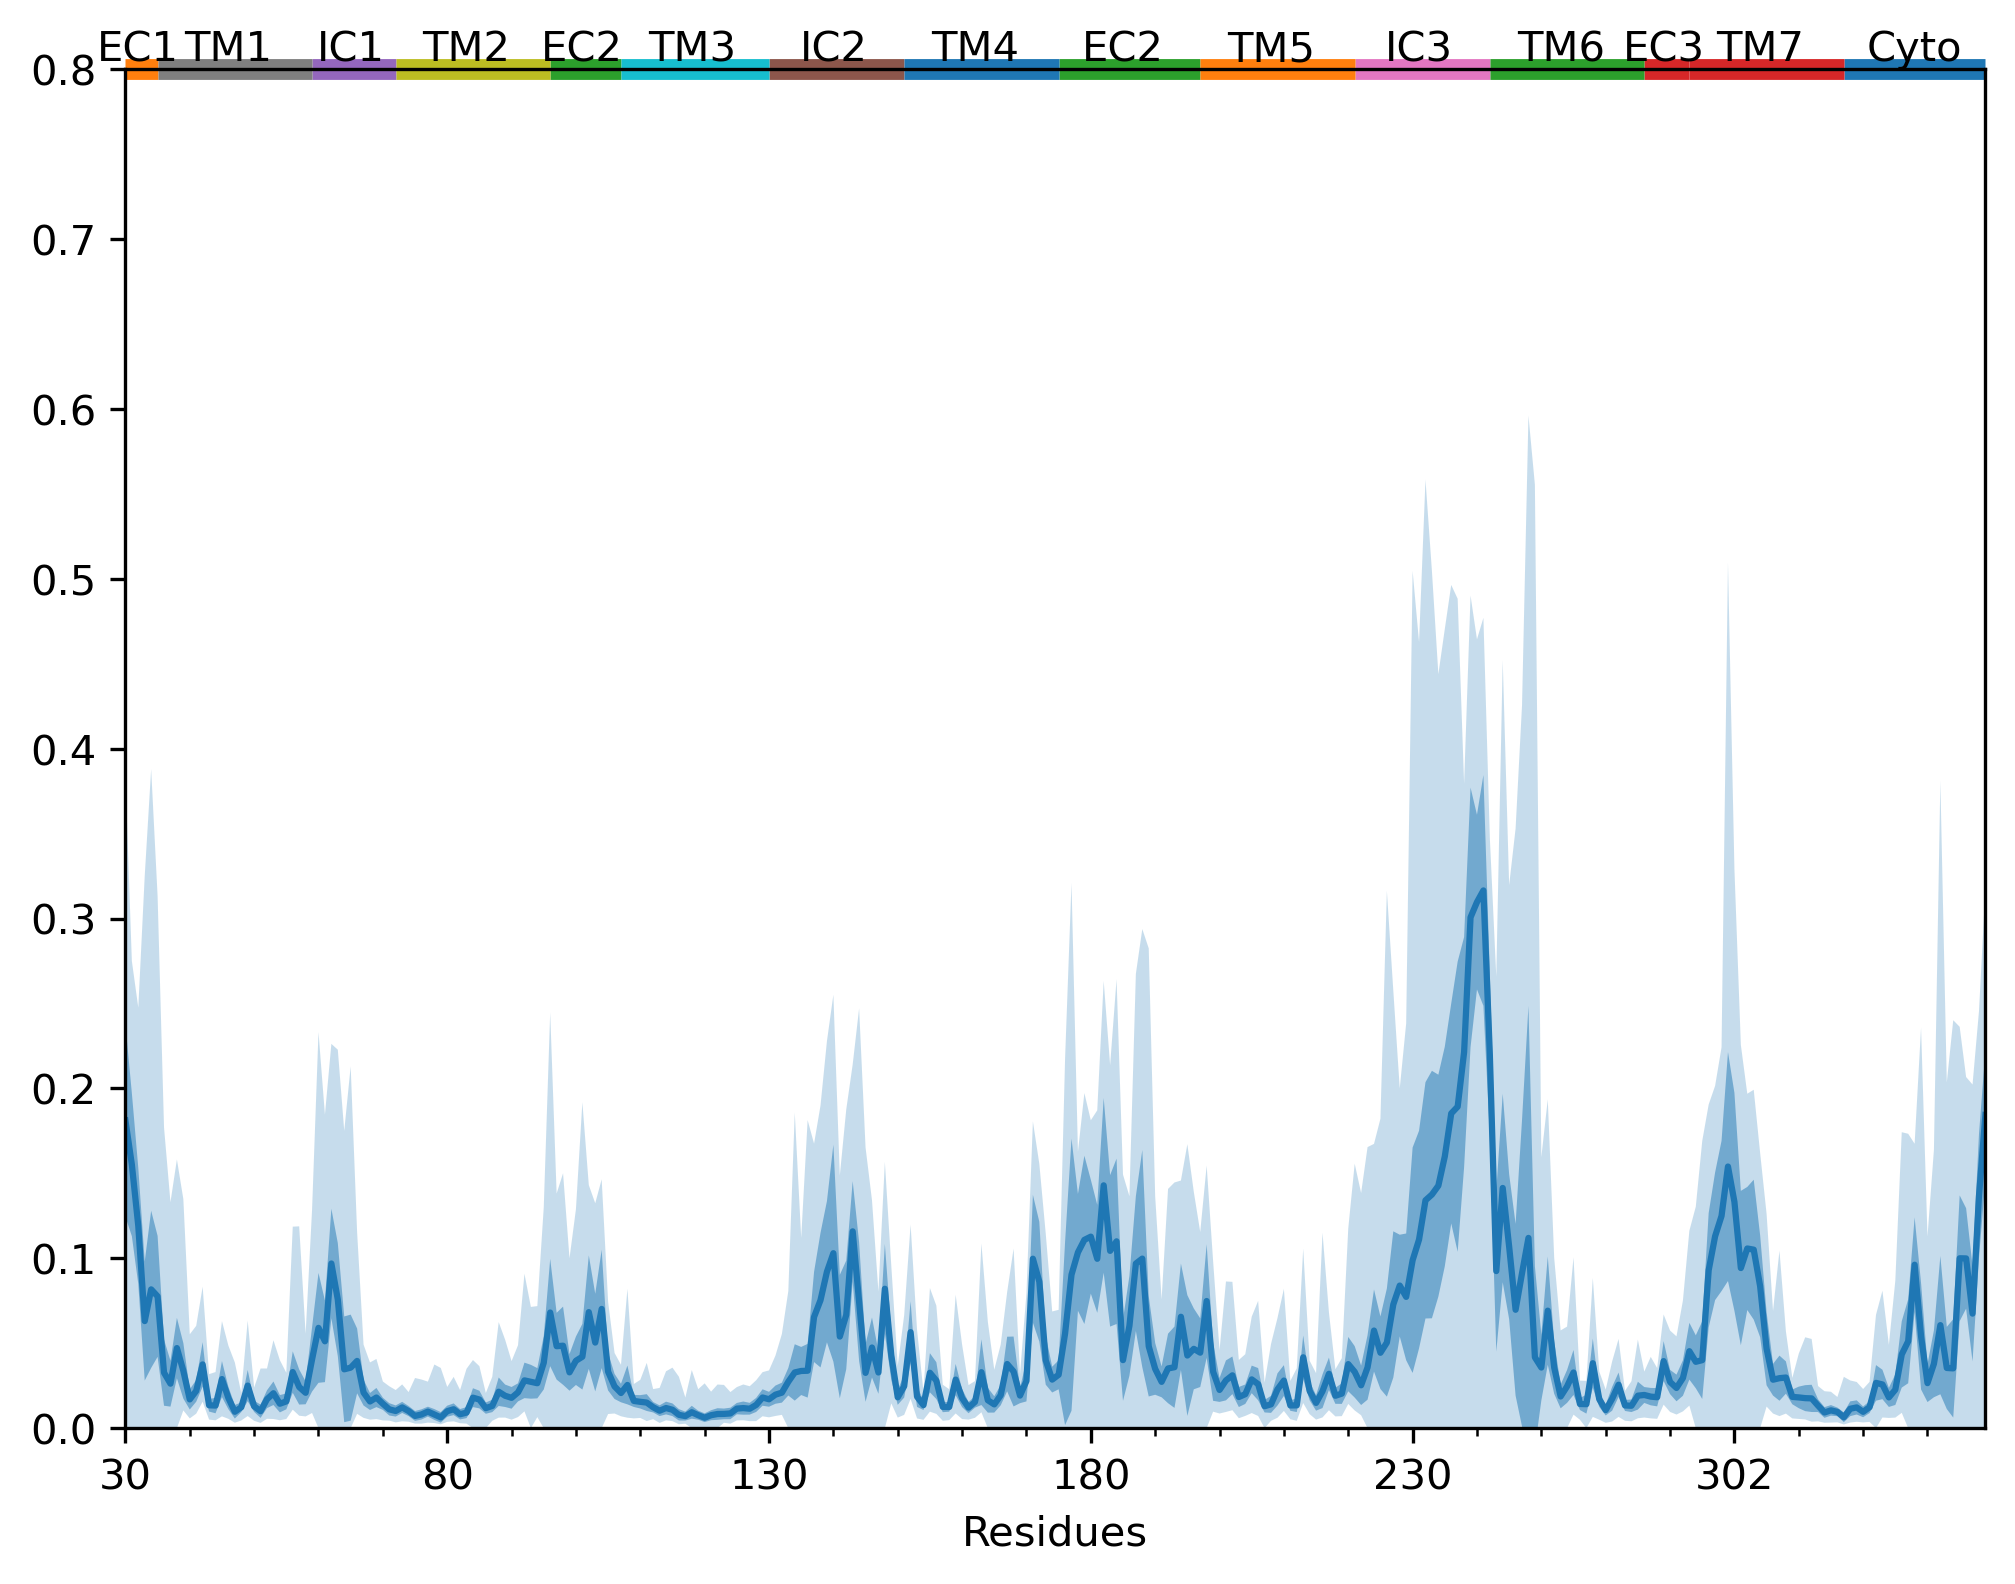

(223, 233)


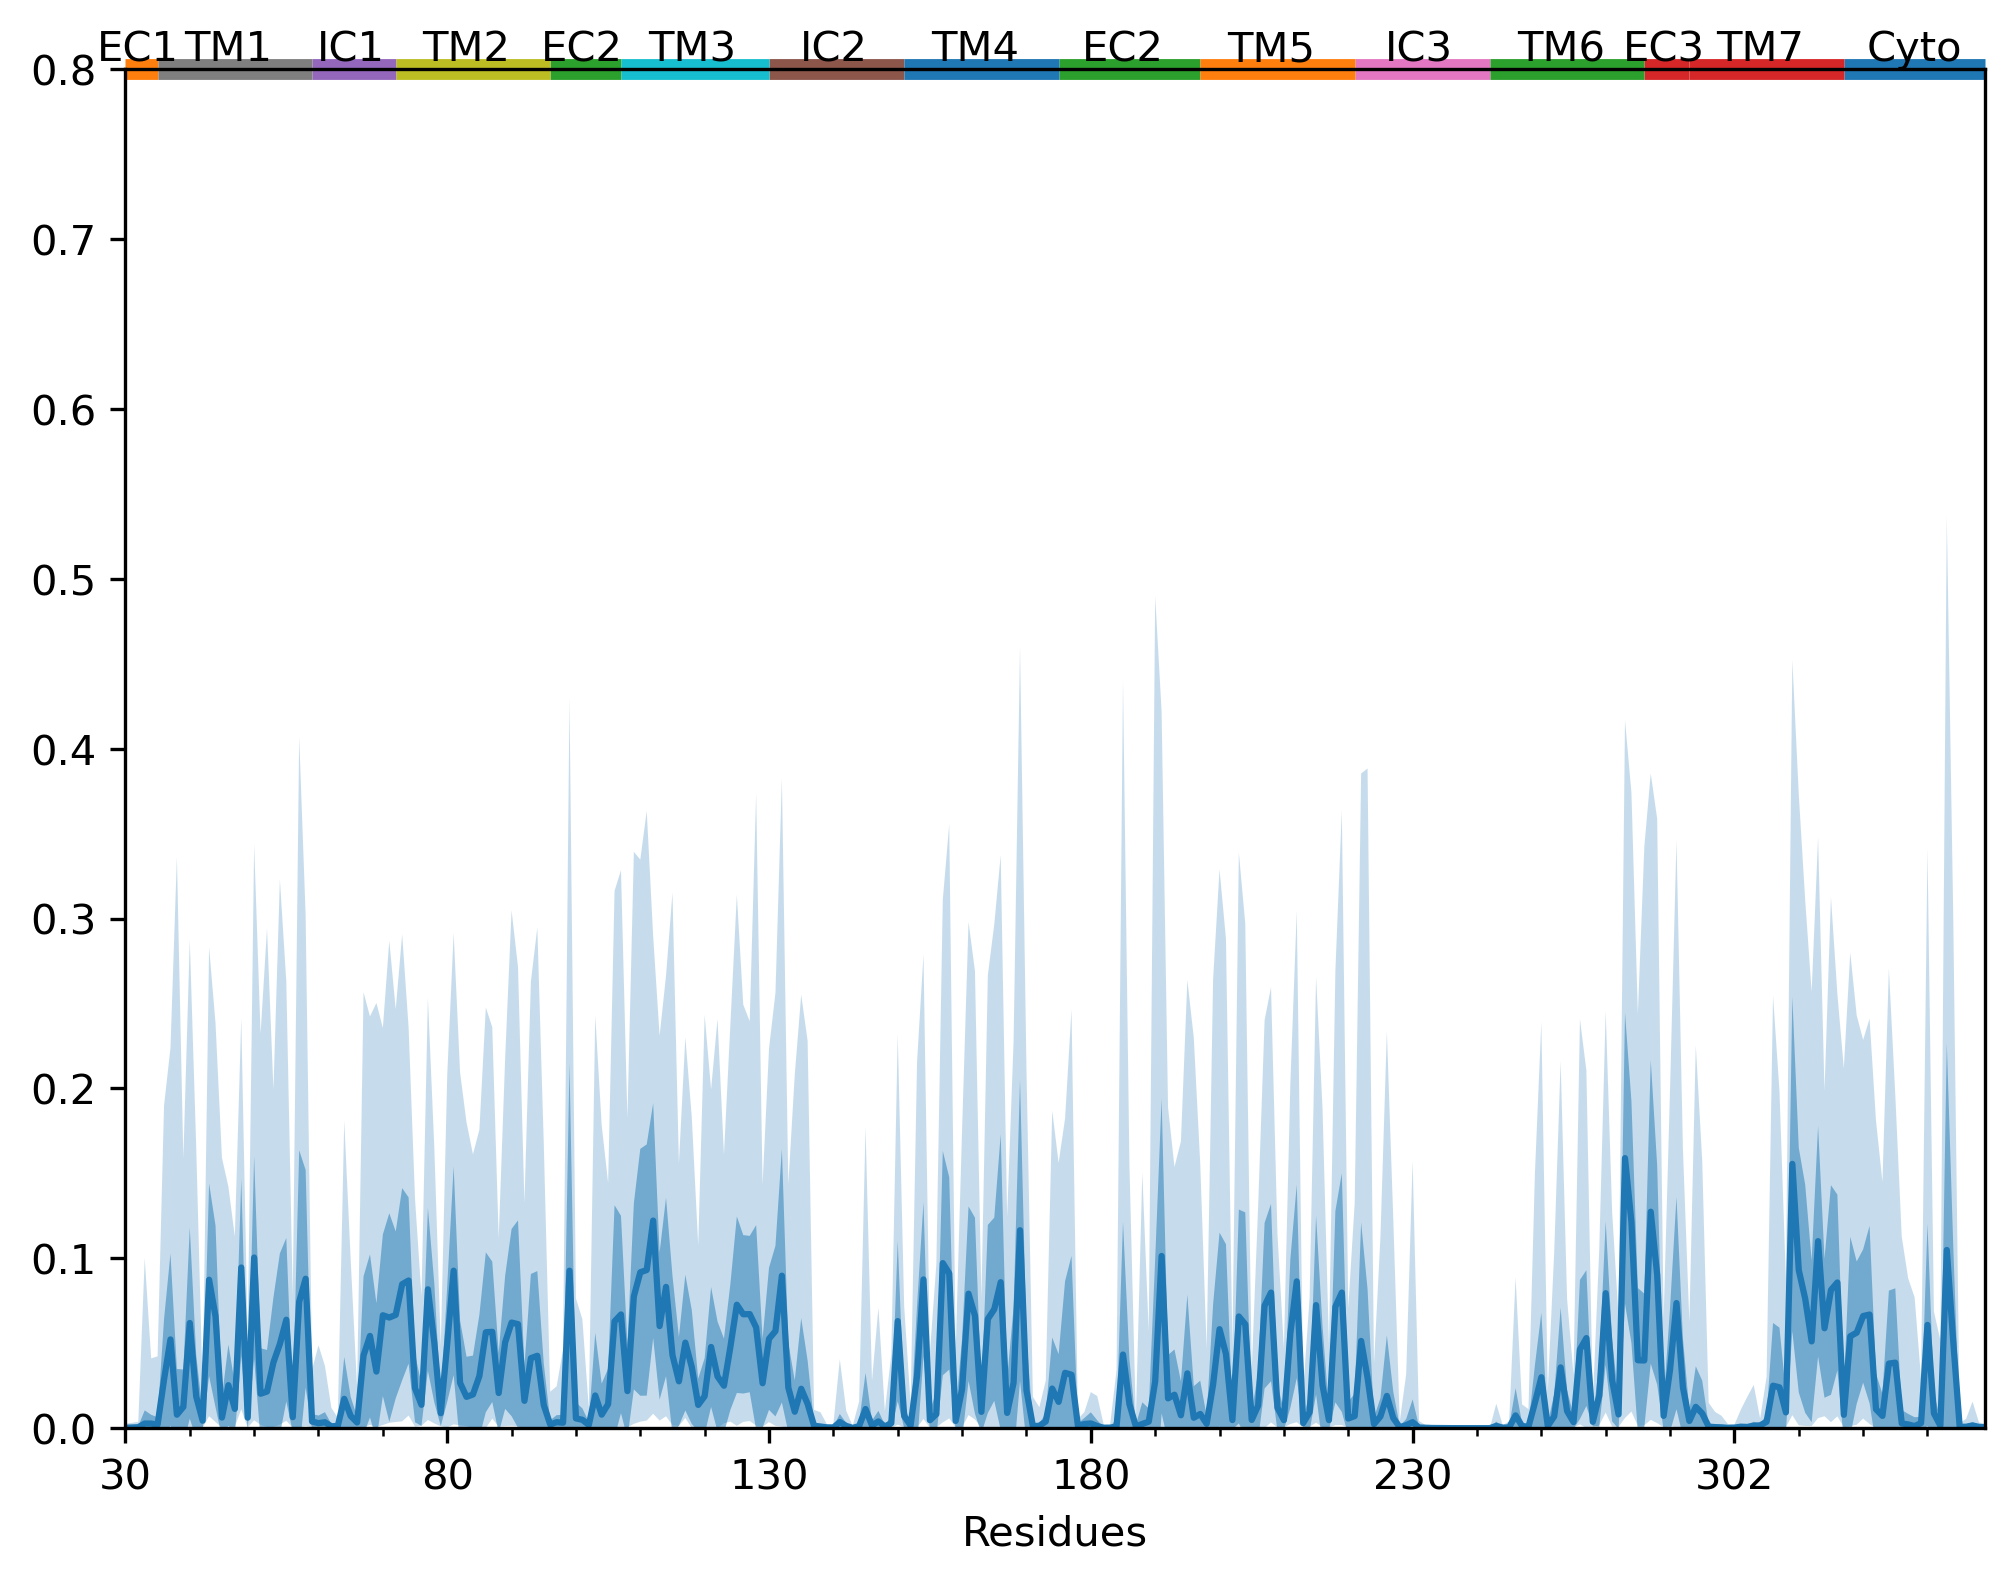

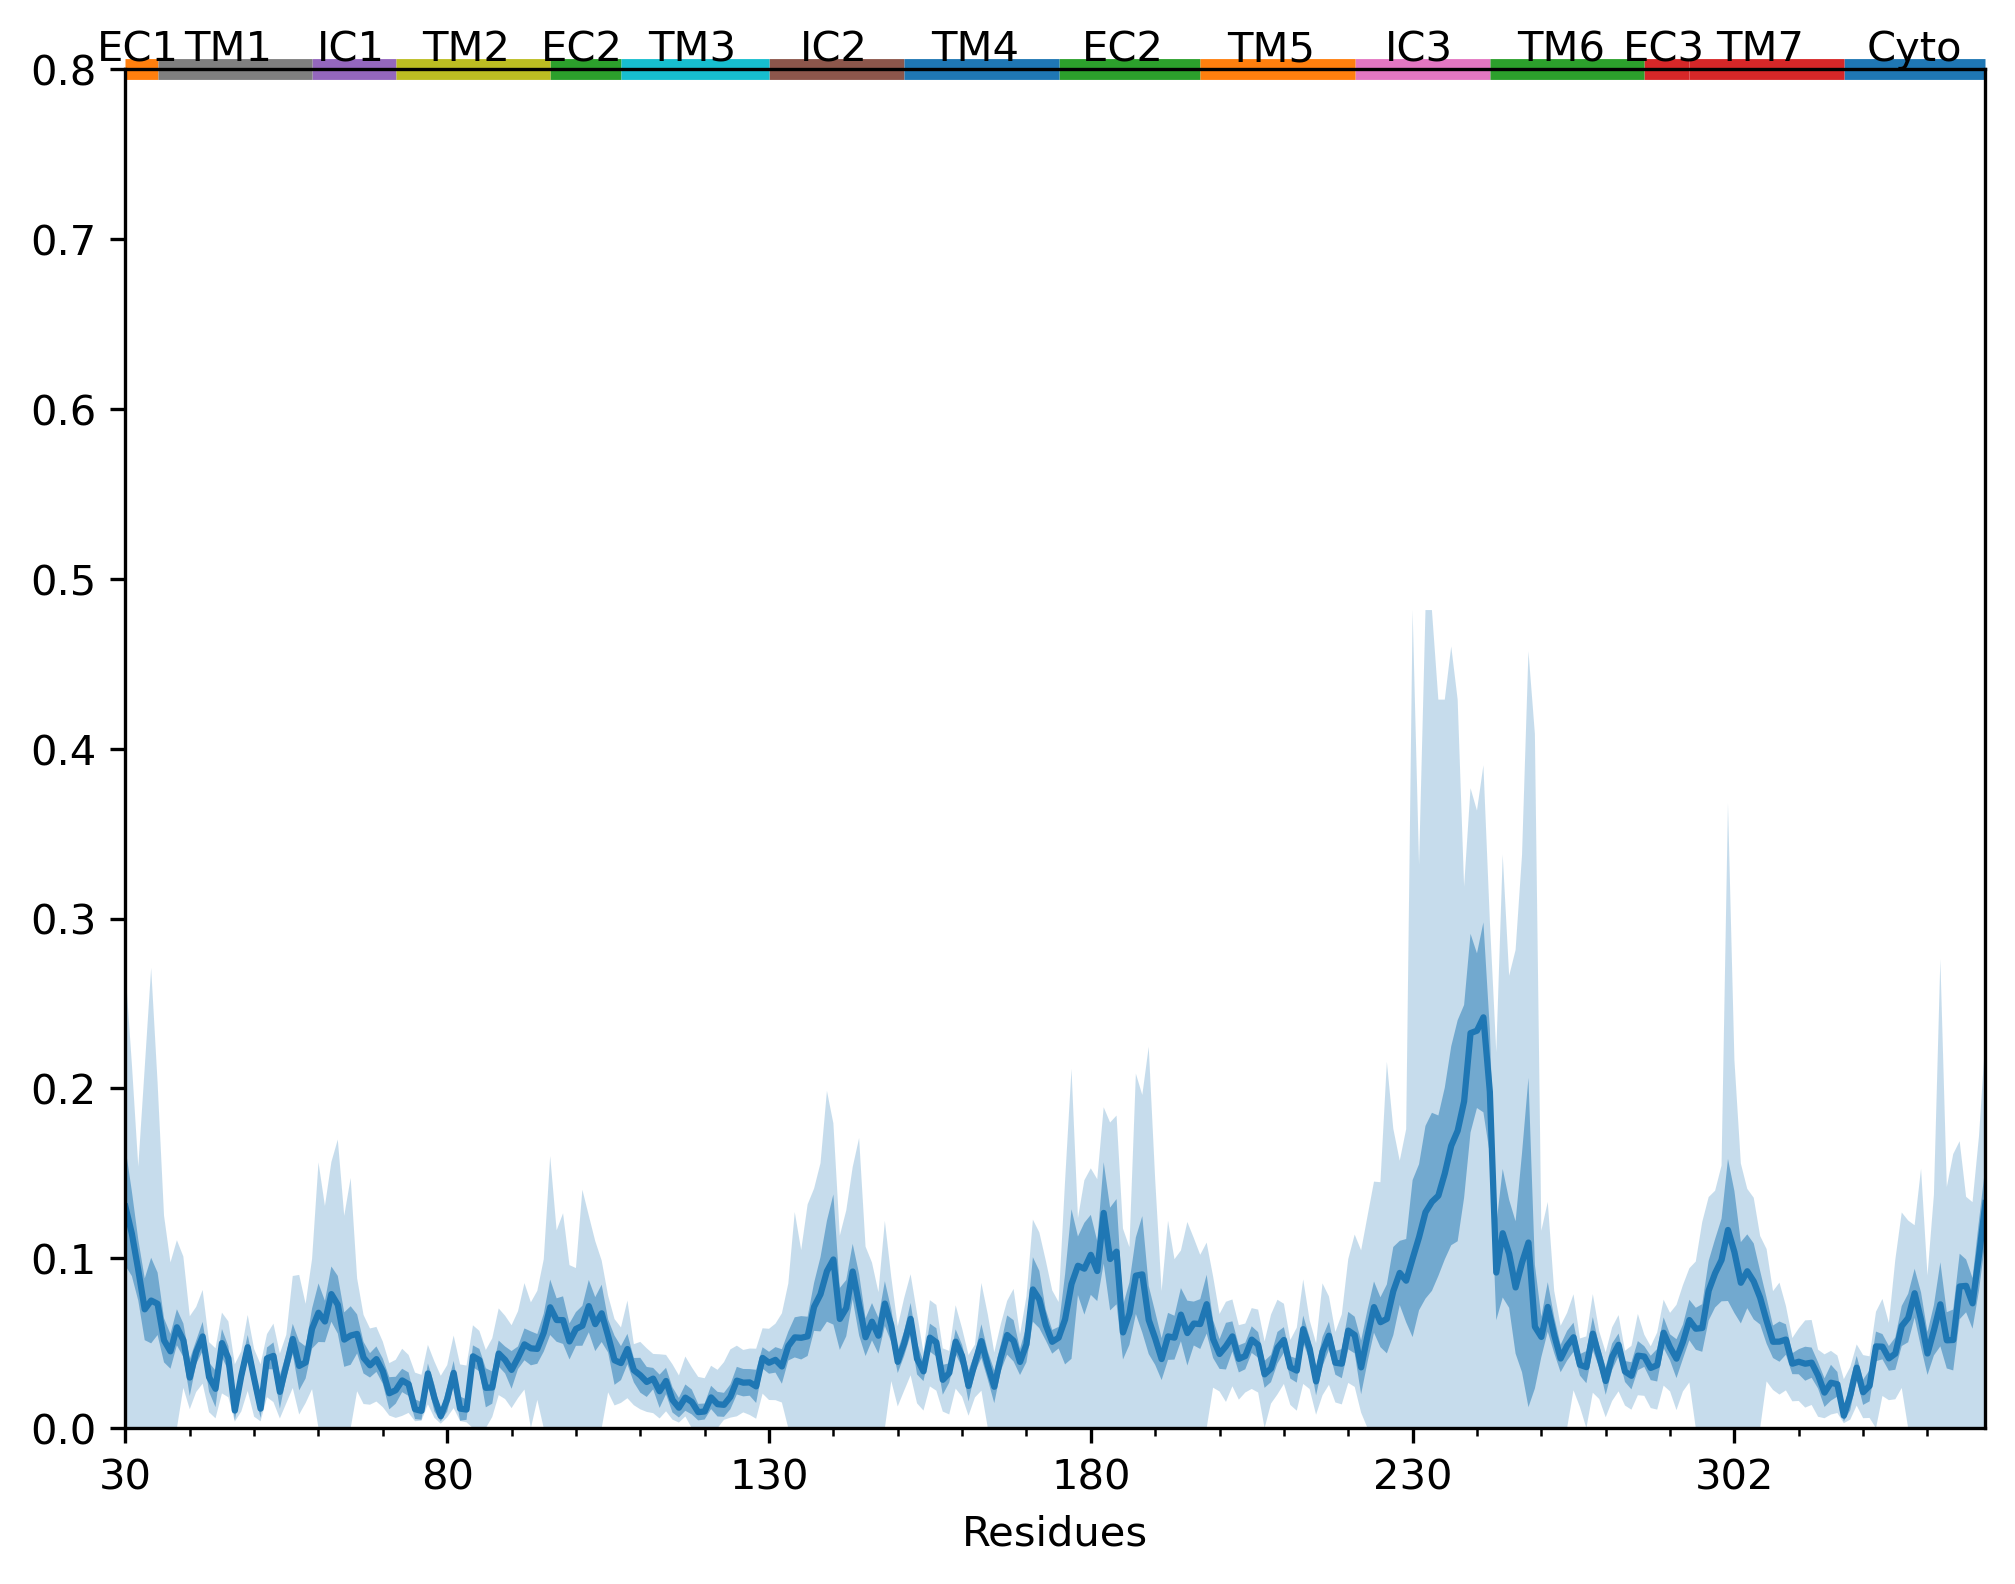

In [57]:
#n_atoms = ens.numAtoms()
#n_modes = gnms.numModeSets()
gnms = loadModeEnsemble('New_GPCR_gnms-dali-full.modeens.npz')
n_modes = gnms[0].numModes()

windows = [(0,3),(3,20),(20,60),(int(n_modes-10),int(n_modes))]

for window in windows:
    #ax = showSignatureMode(gnms[:, :3]);
    print(window)
    figure(figsize=(8, 6), dpi=300)
    showSignatureSqFlucts(gnms[:,window[0]:window[1]])
    plt.ylim(0,0.8)
    showDomainBar(resdomains,loc=1)
    plt.title('')
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A_profile_modes_' + str(window[0]) + '-' + str(window[1]) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()
    
    figure(figsize=(8, 6), dpi=300)
    showSignatureSqFlucts(gnms[:,0:window[1]])
    plt.ylim(0,0.8)
    showDomainBar(resdomains,loc=1)
    plt.title('')
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A_profile_modes-whole_' + str(window[1]) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()

In [58]:
gnms_full = loadModeEnsemble('New_GPCR_gnms-dali-full.modeens.npz')
n_modes = gnms_full[0].numModes()
windows = [(0,3),(3,20),(20,60),(int(n_modes-10),int(n_modes))]

for x in windows:
    print(x, n_modes)
    means = calcSignatureSqFlucts(gnms_full[:,x[0]:x[1]]).mean()
    sd = calcSignatureSqFlucts(gnms_full[:,x[0]:x[1]]).std()
    full_means = []
    full_vars = []
    full_resnums = list(ens[0].getAtoms().getResnums())
    for res in ref_structure.getResnums():
            if res in full_resnums:
                full_means.append(means[full_resnums.index(res)])
                full_vars.append(sd[full_resnums.index(res)])
            else:
                full_means.append(0.0)
                full_vars.append(0.0)
    writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts_means-' + str(x) + '.pdb', ref_structure, beta=full_means)
    writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts_devs-' + str(x) + '.pdb', ref_structure, beta=full_vars)

(0, 3) 233
(3, 20) 233
(20, 60) 233
(223, 233) 233


### Do PCA/ANM analysis to look at overlap

In [5]:
pca = PCA('GPCR Class A')
pca.buildCovariance(ens)
pca.calcModes()

@> Covariance is calculated using 224 coordinate sets.
@> Covariance matrix calculated in 0.085817s.
@> 20 modes were calculated in 0.97s.


In [6]:
for mode in pca[:5]:
    var = calcFractVariance(mode)*100
    print('{0:s} % variance = {1:.2f}'.format(repr(mode), var))

<Mode: 1 from PCA GPCR Class A> % variance = 30.76
<Mode: 2 from PCA GPCR Class A> % variance = 13.95
<Mode: 3 from PCA GPCR Class A> % variance = 11.57
<Mode: 4 from PCA GPCR Class A> % variance = 8.42
<Mode: 5 from PCA GPCR Class A> % variance = 7.23


In [168]:
anm = ANM('7dhi')
anm.buildHessian(ref_short)
anm.calcModes()

NameError: name 'ref_short' is not defined

In [169]:
showOverlapTable(pca[:10], anm[:10])
title('')

ValueError: ANM 7dhi modes are not calculated, use calcModes() method

In [170]:
showProjection?

In [7]:
ens_labels = [x.split('_')[0] for x in ens.getLabels()]
print(ens_labels[:10])

['7dhiR', '6oijR', '4mqsA', '4mqtA', '6oikR', '5zk8A', '6pt0R', '4u15A', '6kpfR', '6d9hR']


In [8]:
print(len(ens), len(ens_labels))

224 224


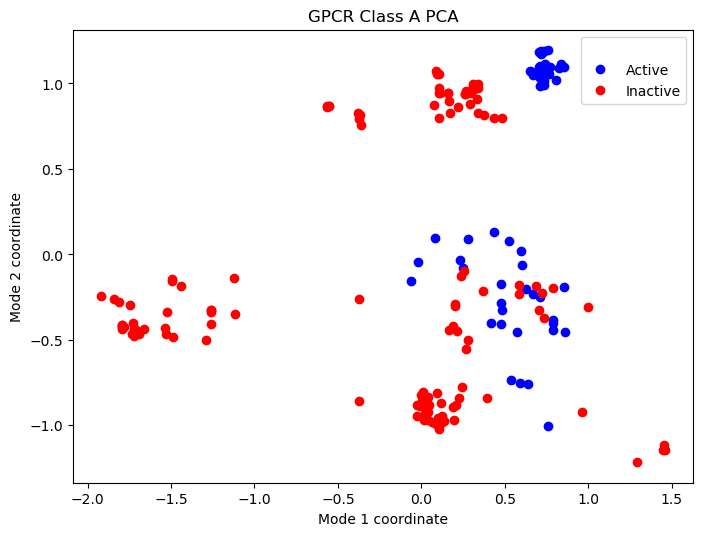

In [43]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[0,1], color=colors);
plt.title('GPCR Class A PCA');
plt.legend(['','Active', 'Inactive']);
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-states-1,2.png',dpi=300,transparent=False)

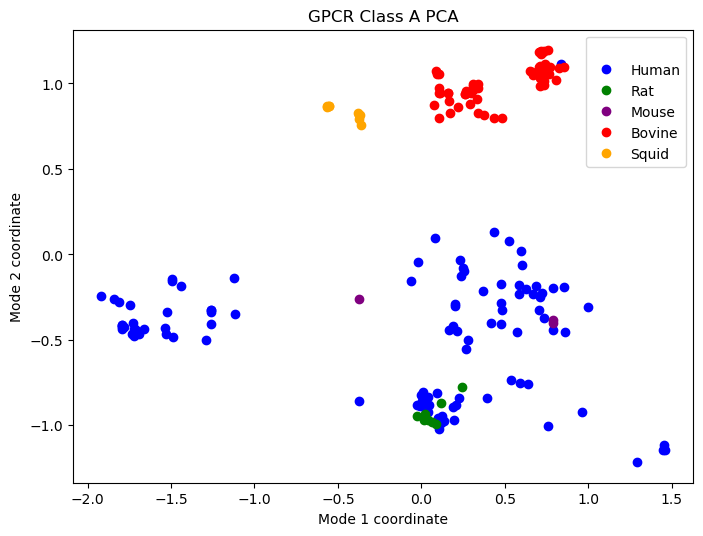

In [44]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[0,1], color=labels);
plt.title('GPCR Class A PCA');
plt.legend(['', 'Human', 'Rat', 'Mouse', 'Bovine', 'Squid']);
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-1,2.png',dpi=300,transparent=False)

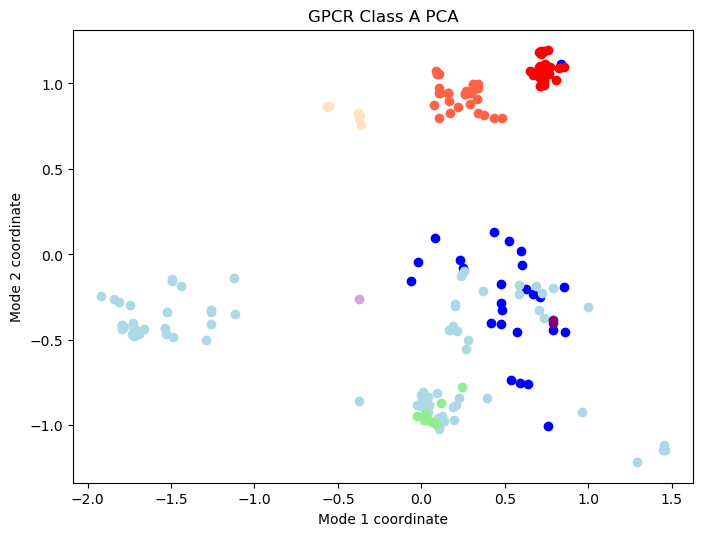

In [45]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[0,1], color=colors_split);
plt.title('GPCR Class A PCA');
#plt.legend(['NA', 'Human', 'Rat', 'Mouse', 'Bovine', 'Squid']);
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-1,2-split.png',dpi=300,transparent=False)

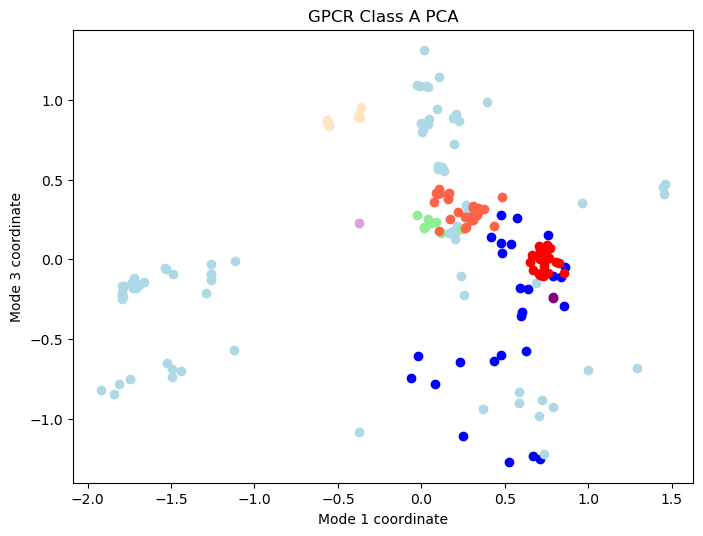

In [46]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[0,2], color=colors_split);
plt.title('GPCR Class A PCA');
#plt.legend(['NA', 'Human', 'Rat', 'Mouse', 'Bovine', 'Squid']);
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-1,3-split.png',dpi=300,transparent=False)

In [ ]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[1,2], color=colors_split);
plt.title('GPCR Class A PCA');
#plt.legend(['NA', 'Human', 'Rat', 'Mouse', 'Bovine', 'Squid']);
plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-2,3-split.png',dpi=300,transparent=False)

In [ ]:
showProjection(ens, pca[:3], color=colors);
plt.title('GPCR Class A PCA')
plt.legend(['NA', 'Active', 'Inactive'])
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-states-3d.png',dpi=300,transparent=False)

In [ ]:
showProjection(ens, pca[:3], color=labels);
plt.title('GPCR Class A PCA')
plt.legend(['NA', 'Human', 'Rat', 'Mouse', 'Bovine', 'Squid'])
#plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-3d.png',dpi=300,transparent=False)

In [ ]:
figure(figsize=(8, 6), dpi=100)
showProjection(ens, pca[:3], color=colors_split);
plt.title('GPCR Class A PCA')
#plt.legend(['NA', 'Active', 'Inactive'])
plt.savefig(FIG + 'New_GPCR-Dali-Class-A_PCA-species-3d-split.png',dpi=300,transparent=False)

In [ ]:
showProjection?

In [37]:
active_df = gpcr_df.loc[gpcr_df['State'] == 'Active']
state_pdbs = list(temp_df.PDB)

In [40]:
names = [x[:4].upper() for x in ens.getLabels()]
colors = []
labels = []
shapes = []
colors_split = []

for name in names:
    if name in classA_states['Active']:
        colors.append('blue')
        shapes.append('o')
    elif name in classA_states['Inactive']:
        colors.append('red')
        shapes.append('x')
    else:
        colors.append('white')
        shapes.append('.')
        
    if name in classA_species['Human']:
        if name in classA_states['Active']:
            labels.append('blue')
            colors_split.append('blue')
        elif name in classA_states['Inactive']:
            labels.append('blue')
            colors_split.append('lightblue')
        else:
            labels.append('white')
            colors_split.append('white')
    elif name in classA_species['Bovine']:
        if name in classA_states['Active']:
            labels.append('red')
            colors_split.append('red')
        elif name in classA_states['Inactive']:
            labels.append('red')
            colors_split.append('tomato')
        else:
            labels.append('white')
            colors_split.append('white')
    elif name in classA_species['Rat']:
        if name in classA_states['Active']:
            labels.append('green')
            colors_split.append('green')
        elif name in classA_states['Inactive']:
            labels.append('green')
            colors_split.append('lightgreen')
        else:
            labels.append('white')
            colors_split.append('white')
    elif name in classA_species['Mouse']:
        if name in classA_states['Active']:
            labels.append('purple')
            colors_split.append('purple')
        elif name in classA_states['Inactive']:
            labels.append('purple')
            colors_split.append('plum')
        else:
            labels.append('white')
            colors_split.append('white')
    elif name in classA_species['Japanese flying squid']:
        if name in classA_states['Active']:
            labels.append('orange')
            colors_split.append('darkorange')
        elif name in classA_states['Inactive']:
            labels.append('orange')
            colors_split.append('bisque')
        else:
            labels.append('white')
            colors_split.append('white')
    else:
        labels.append('white')
        colors_split.append('white')

In [ ]:
print(len(names), len(colors), len(labels), len(colors_split))

In [35]:
classA_species = {}
for state in list(set(list(gpcr_df.Species))):
    print(state)
    temp_df = gpcr_df.loc[gpcr_df['Species'] == state]
    state_pdbs = list(temp_df.PDB)
    classA_species[state] = []
    for pdb in pdb_ids:
        pdbid = pdb[:4].upper()
        if pdbid in state_pdbs:
            classA_species[state].append(pdbid)

Rabbit
Bovine
Rat
Guinea pig
Japanese flying squid
Human
Wild turkey
strain AD169
Mouse
African clawed frog
Zebrafish
Hasarius adansoni


In [ ]:
for species in classA_species:
    print(species, len(classA_species[species]))

#### Try with just other active structures

In [ ]:
pca_a = PCA('GPCR Class A Active')
pca_a.buildCovariance(ens_a)
pca_a.calcModes()

In [ ]:
for mode in pca_a[:5]:
    var = calcFractVariance(mode)*100
    print('{0:s} % variance = {1:.2f}'.format(repr(mode), var))

In [ ]:
pca_a.getCovariance()

In [ ]:
pca_a.calcModes()

In [ ]:
list_a = [ens[x].getAtoms() for x in range(len(ens)) if ens[12].getLabel()[:4].upper() in classA_states['Active']]

In [ ]:
list_a[0].getAtoms()

In [ ]:
ens_a = buildPDBEnsemble(list_a)

In [ ]:
pca_i = PCA('GPCR Class A Inactive')
pca_i.buildCovariance(ens_i)
pca_i.calcModes()

In [ ]:
for mode in pca_i[:5]:
    var = calcFractVariance(mode)*100
    print('{0:s} % variance = {1:.2f}'.format(repr(mode), var))

### Split Class A into active/inactive and redo analysis

In [39]:
classA_states = {}
for state in ['Active', 'Inactive']:
    print(state)
    temp_df = gpcr_df.loc[gpcr_df['State'] == state]
    state_pdbs = list(temp_df.PDB)
    classA_states[state] = []
    for pdb in pdb_ids:
        pdbid = pdb[:4].upper()
        if pdbid in state_pdbs:
            classA_states[state].append(pdbid)

Active
Inactive


In [ ]:
print(len(classA_states['Active']), len(classA_states['Inactive']))

In [51]:
ref_active = parsePDB('7dhi', subset='ca', chain='R')
ref_inactive = parsePDB('7dhi', subset='ca', chain='R')

@> PDB file is found in working directory (7dhi.pdb).
@> 290 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Secondary structures were assigned to 207 residues.
@> PDB file is found in working directory (7dhi.pdb).
@> 290 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Secondary structures were assigned to 207 residues.


In [ ]:
for state in ['Active', 'Inactive']:
    print(state)
    pdbs = parsePDB(*classA_states[state], subset='ca')
    if state == 'Active':
        dali_ens = buildPDBEnsemble(pdbs, ref=ref_active, mapping=mappings, seqid=20)
    else:
        dali_ens = buildPDBEnsemble(pdbs, ref=ref_inactive, mapping=mappings, seqid=20)
    saveEnsemble(dali_ens,'New_GPCR_ens-dali-' + state)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce')
    saveModeEnsemble(gnms, 'New_GPCR_gnms-dali-' + state, atoms=True)

In [ ]:
for state in ['Active', 'Inactive']:
    print(state)
    ens = loadEnsemble('New_GPCR_ens-dali-' + state + '.ens.npz')
    gnms = calcEnsembleENMs(ens, model='GNM', trim='reduce', n_modes=None)
    saveModeEnsemble(gnms, 'New_GPCR_gnms-dali-' + state + '-full', atoms=True)
    gnms = loadModeEnsemble('New_GPCR_gnms-dali-' + state + '-full.modeens.npz')
    
    print(gnms.numModeSets())
    n_modes = gnms[0].numModes()
    print(n_modes)

    windows = [(0,3),(3,20),(20,60),(int(n_modes-10),int(n_modes))]

    for window in windows:
        try:
            #ax = showSignatureMode(gnms[:, :3]);
            print(window)
            showSignatureSqFlucts(gnms[:,window[0]:window[1]])
            plt.ylim(0,0.8)
            showDomainBar(resdomains,loc=1)
            #plt.xlim(0,463)
            plt.title('')
            plt.savefig(FIG + 'New_GPCR-Dali-Class-A-' + state + '_profile_modes_' + str(window[0]) + '-' + str(window[1]) + '.png',dpi=300,transparent=False)
            plt.show()
            plt.close()
        except (TypeError, IndexError) as e:
            print(windows)
            break

#### Calculate correlation of modes between active/inactive subsets

In [45]:
ens_a = loadEnsemble('New_GPCR_ens-dali-Active.ens.npz')
ens_i = loadEnsemble('New_GPCR_ens-dali-Inactive.ens.npz')

In [46]:
gnms_a = loadModeEnsemble('New_GPCR_gnms-dali-Active-full.modeens.npz')
gnms_i = loadModeEnsemble('New_GPCR_gnms-dali-Inactive-full.modeens.npz')

In [47]:
n_modes_a = gnms_a[0].numModes()
n_modes_i = gnms_i[0].numModes()

In [48]:
n_modesets_a = gnms_a.numModeSets()
n_modesets_i = gnms_i.numModeSets()

In [49]:
windows_a = [(0,3),(3,20),(20,60),(int(n_modes_a-10),int(n_modes_a))]
windows_i = [(0,3),(3,20),(20,60),(int(n_modes_i-10),int(n_modes_i))]

In [ ]:
correlation_rows = []

for i in range(4):
    start_a, stop_a = windows_a[i][0], windows_a[i][1]
    modes_a = gnms_a[:,start_a:stop_a]
    vecs_a = modes_a.getEigvecs()
    
    for pdb in range(len(vecs_a)):
        for res in range(len(vecs_a[pdb])):
            for mode
            
    
    start_i, stop_i = windows_i[i][0], windows_i[i][1]
    modes_i = gnms_i[:,start_i:stop_i]
    
    

In [ ]:
correlation_rows = []

print('Active')
for i in range(n_modes_a):
    vecs = gnms_a[:,i].getEigvecs()
    if i%20 == 0:
        print(i)
    for pdb in range(len(vecs)):
        for res in range(len(vecs[pdb])):
            correlation_rows.append(['Active',i,gnms_a[pdb].getTitle().split()[-2].split('_')[0],res,vecs[pdb][res][0]])
            
print('Inactive')
for i in range(n_modes_i):
    vecs = gnms_i[:,i].getEigvecs()
    if i%20 == 0:
        print(i)
    for pdb in range(len(vecs)):
        for res in range(len(vecs[pdb])):
            correlation_rows.append(['Inactive',i,gnms_i[pdb].getTitle().split()[-2].split('_')[0],res,vecs[pdb][res][0]])
            
eig_df = pd.DataFrame(correlation_rows,columns=['State','Mode','PDB','Residue','Value'])

In [ ]:
gnms_a[1].getTitle()

In [ ]:
eig_df.head()

In [ ]:
n_modes_a

In [ ]:
len(gnms_a)

In [ ]:
eig_df.to_csv('Class_A_states.csv')

In [ ]:
eig_df.shape

In [ ]:
full_resnums

0


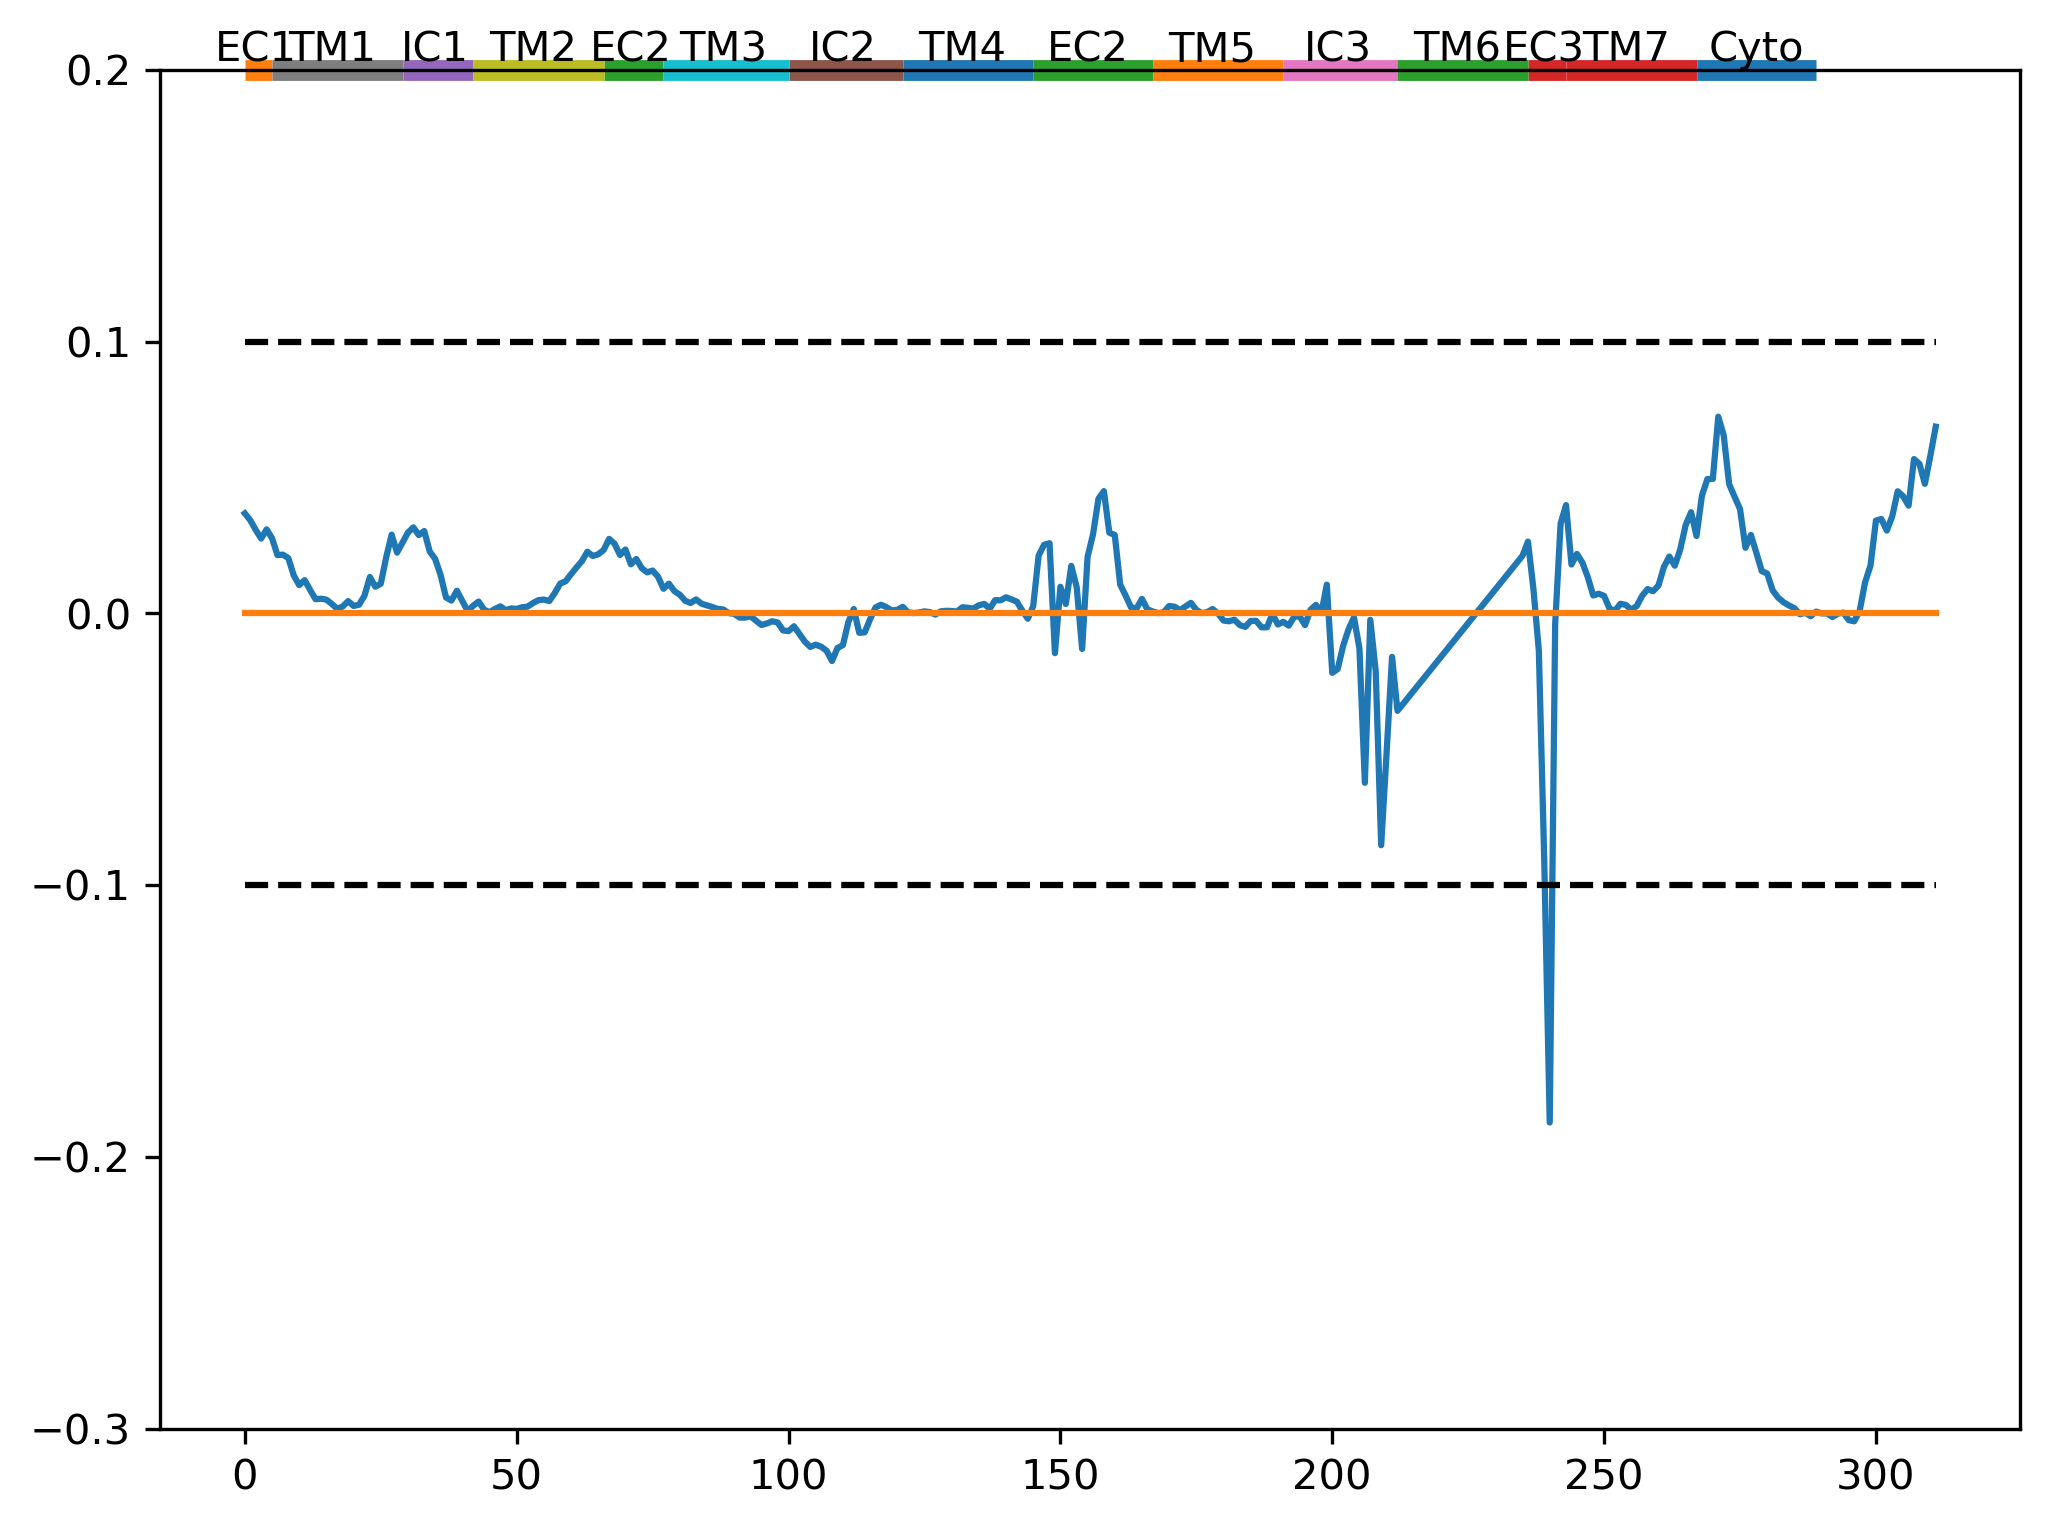

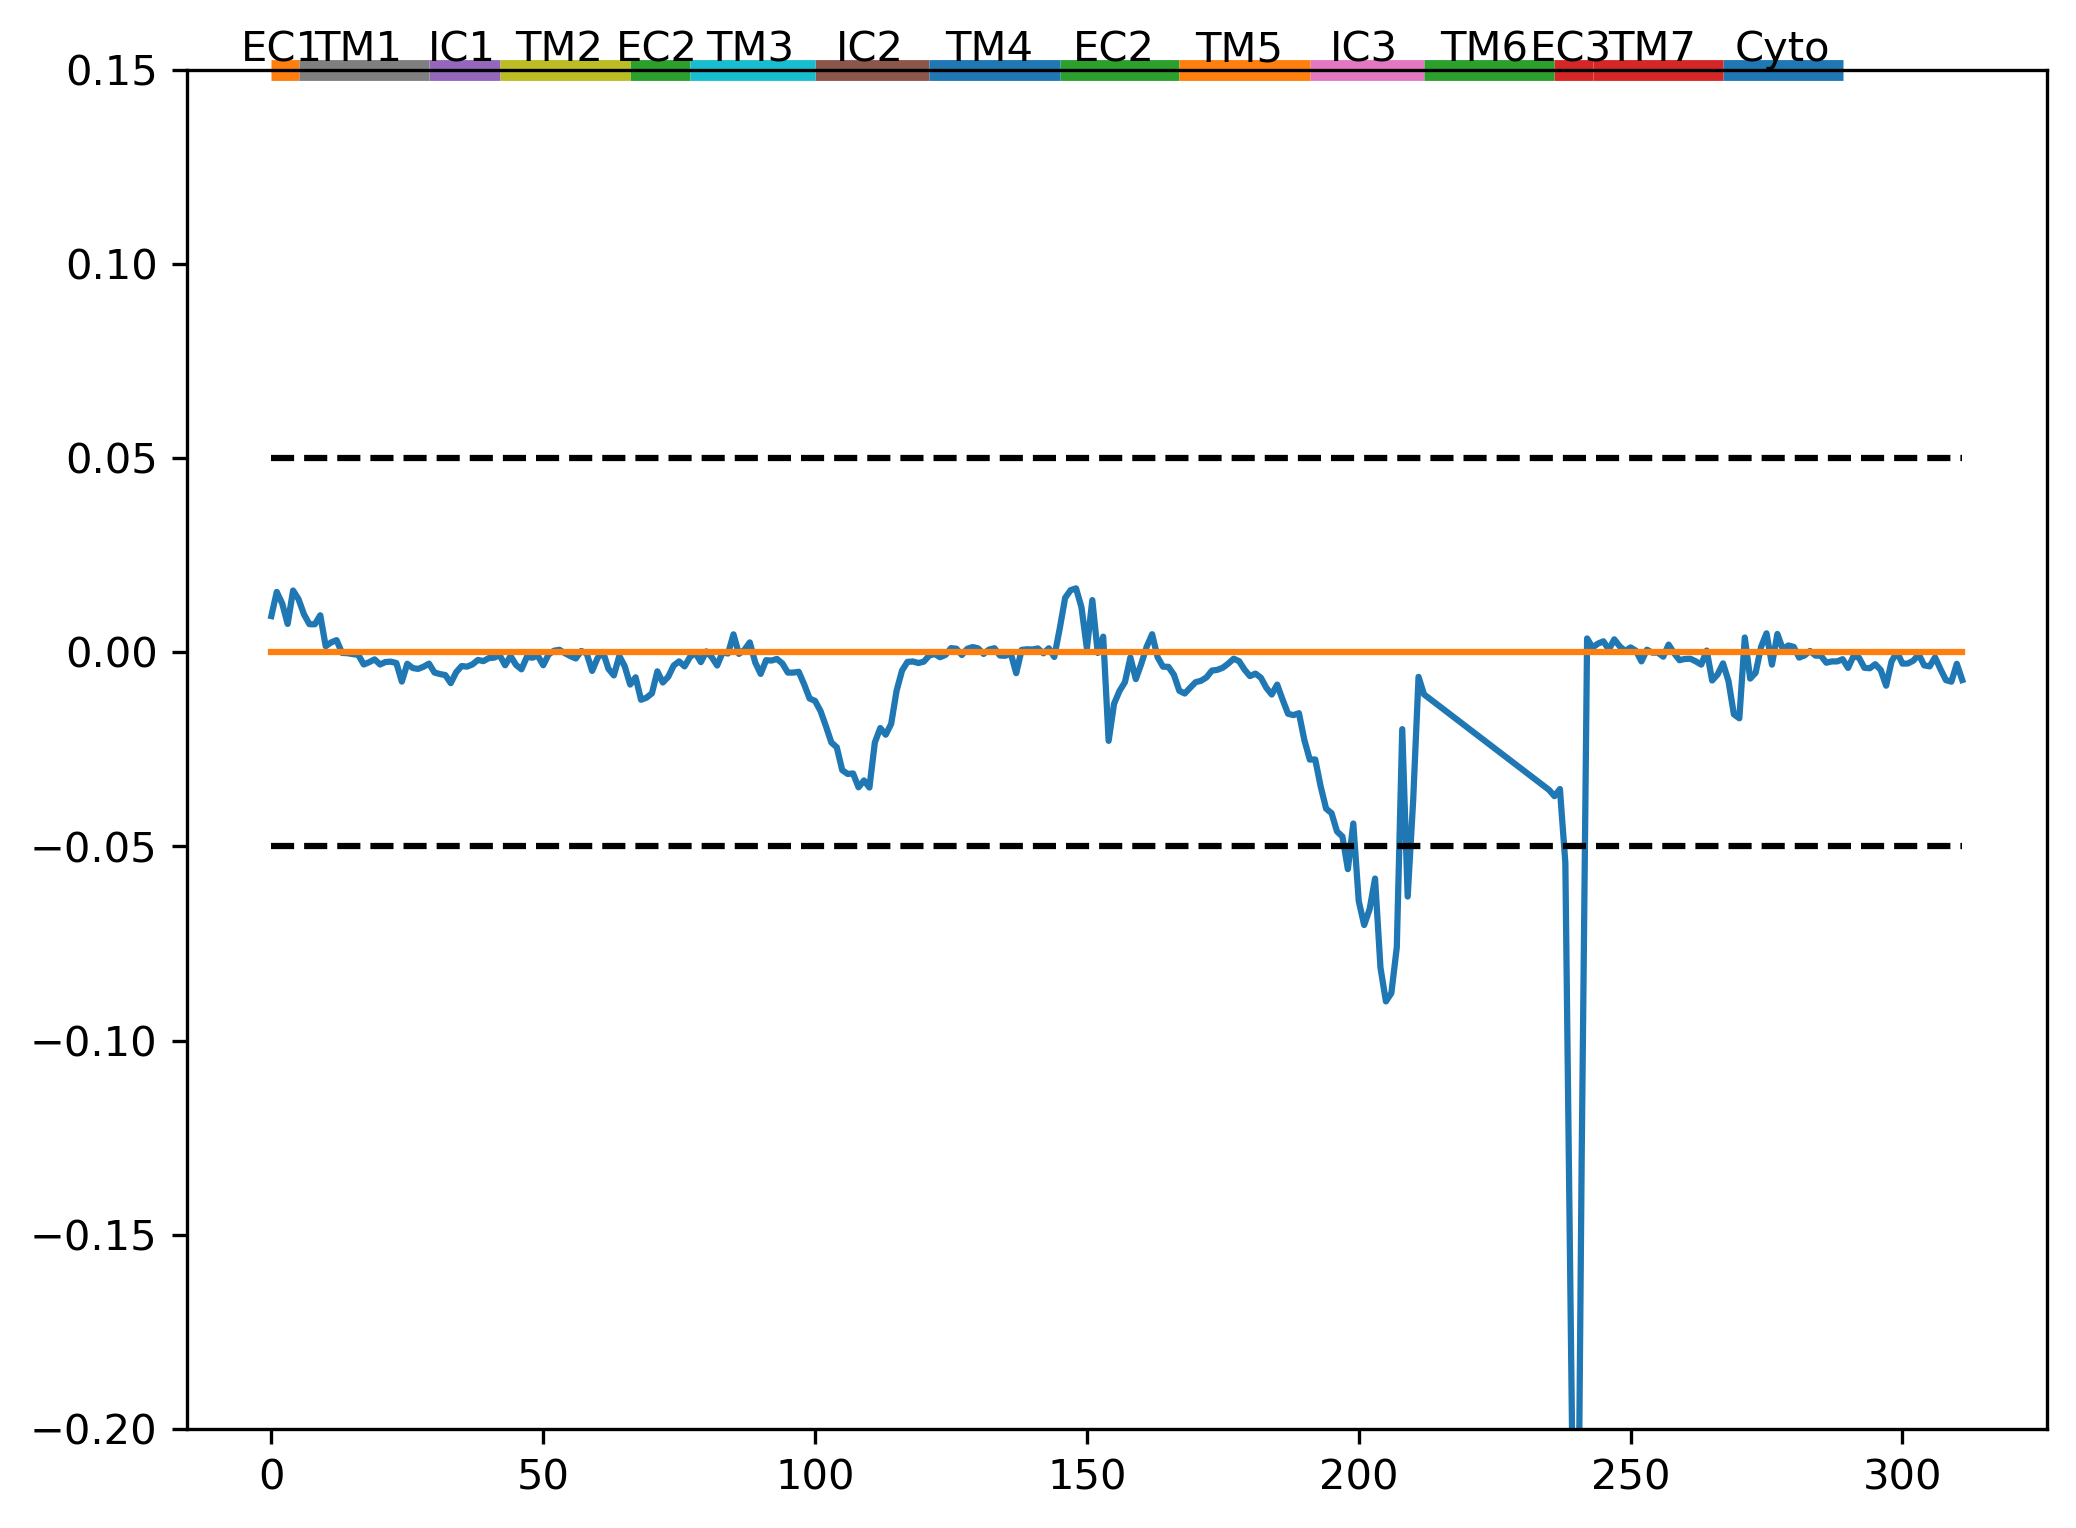

1


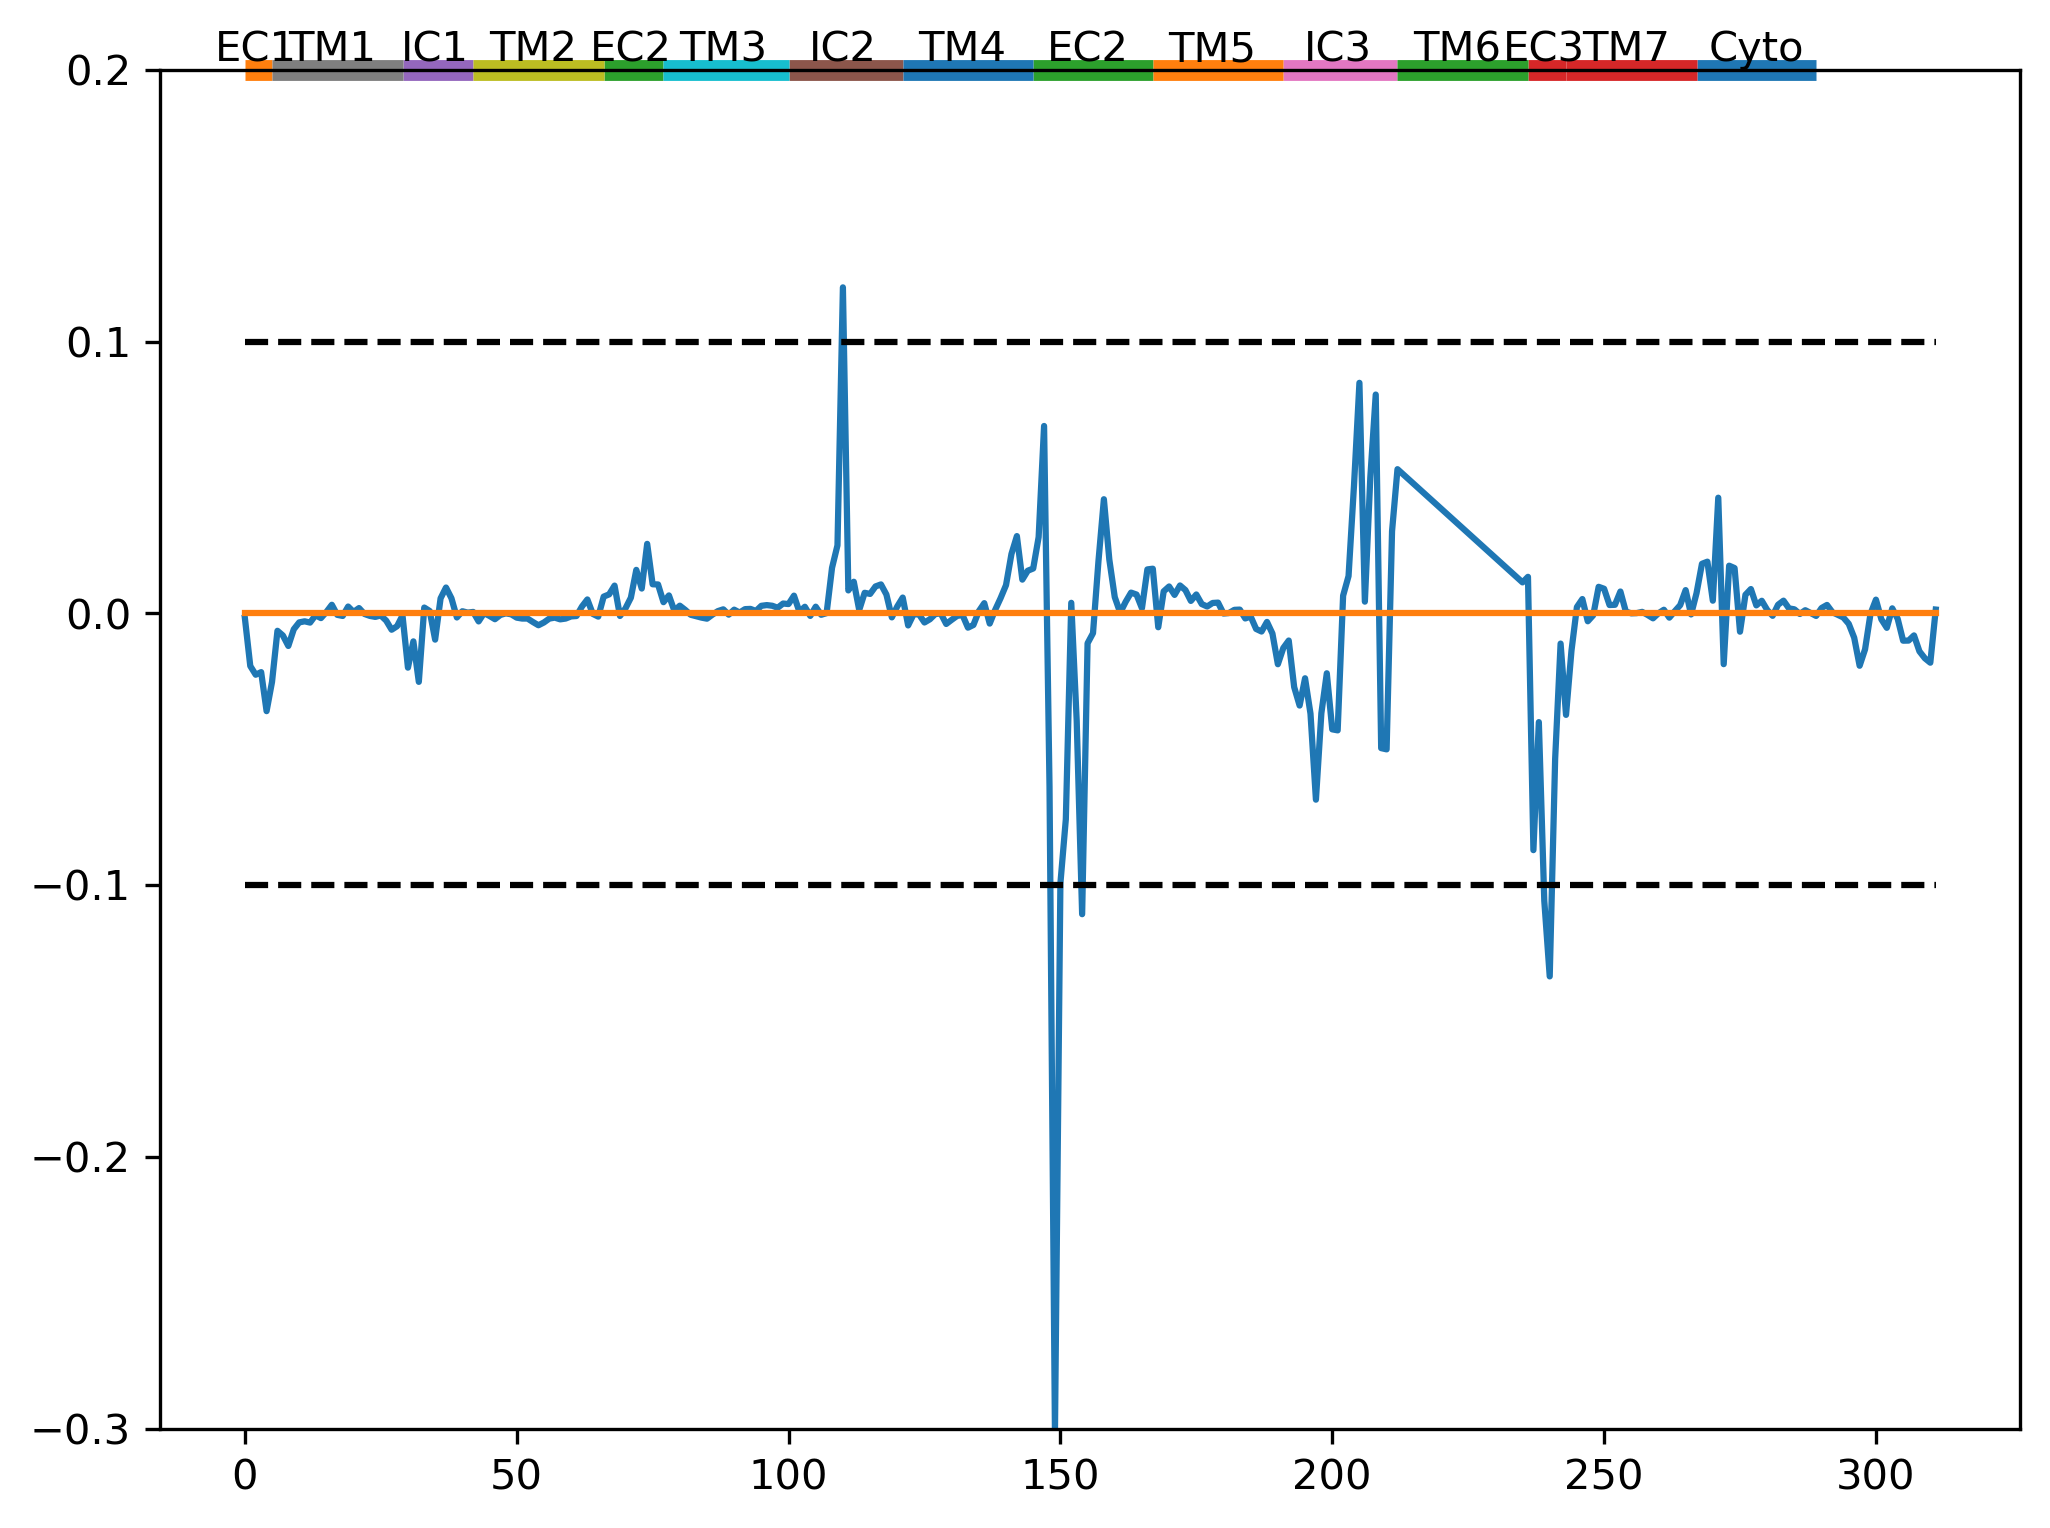

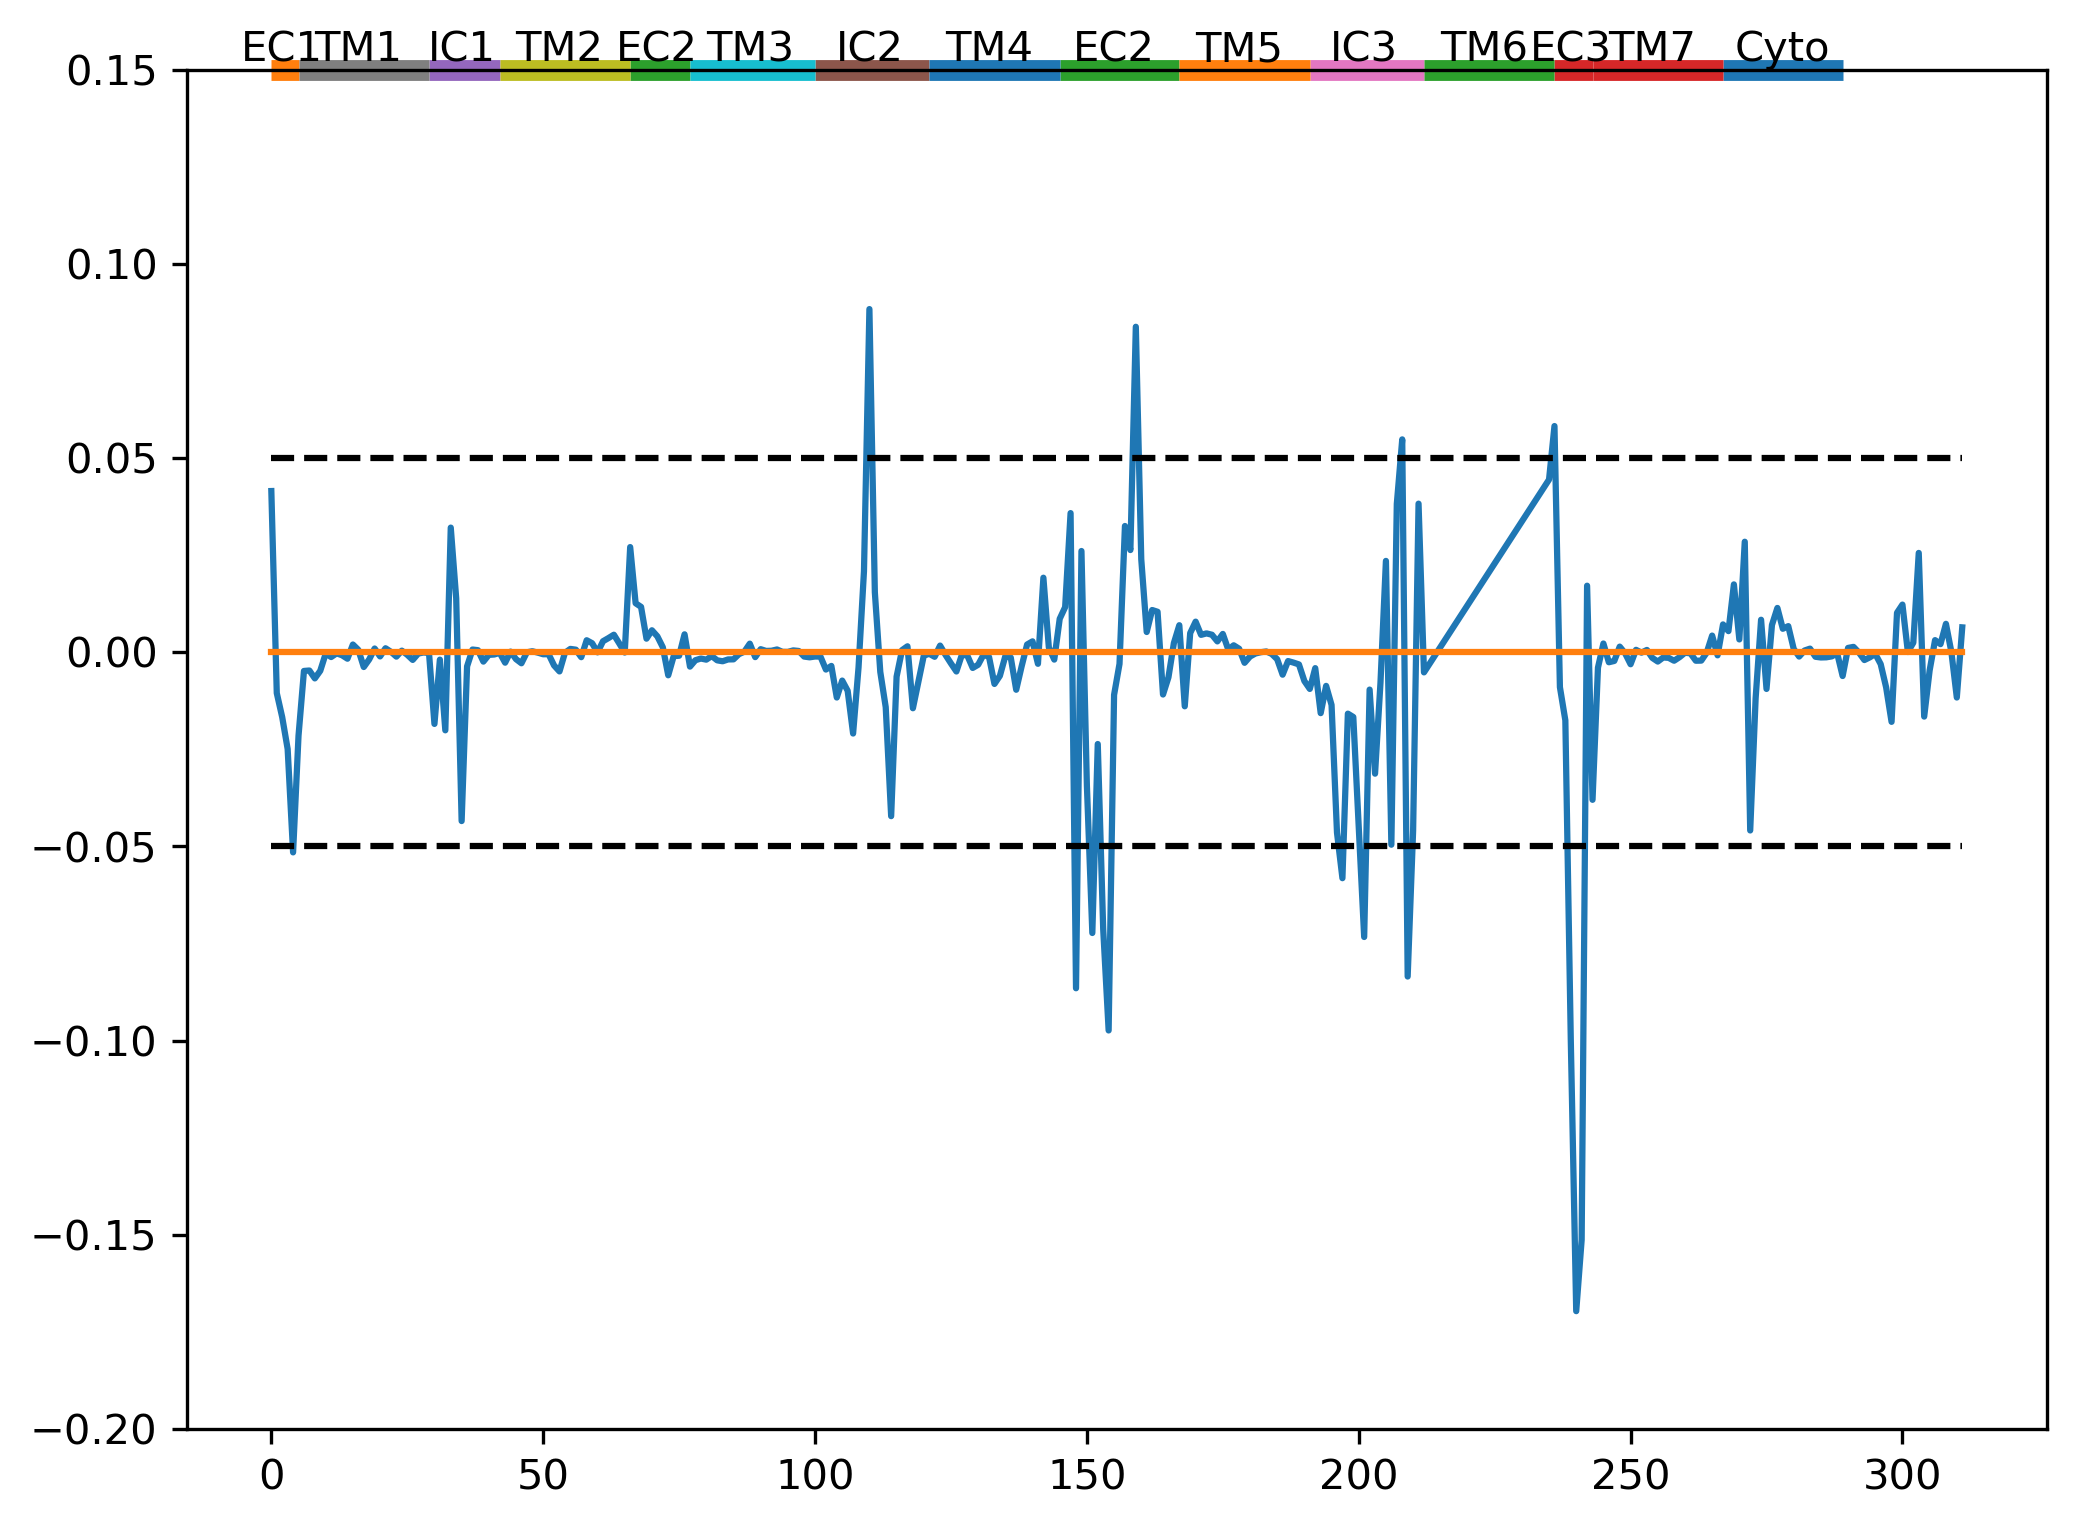

2


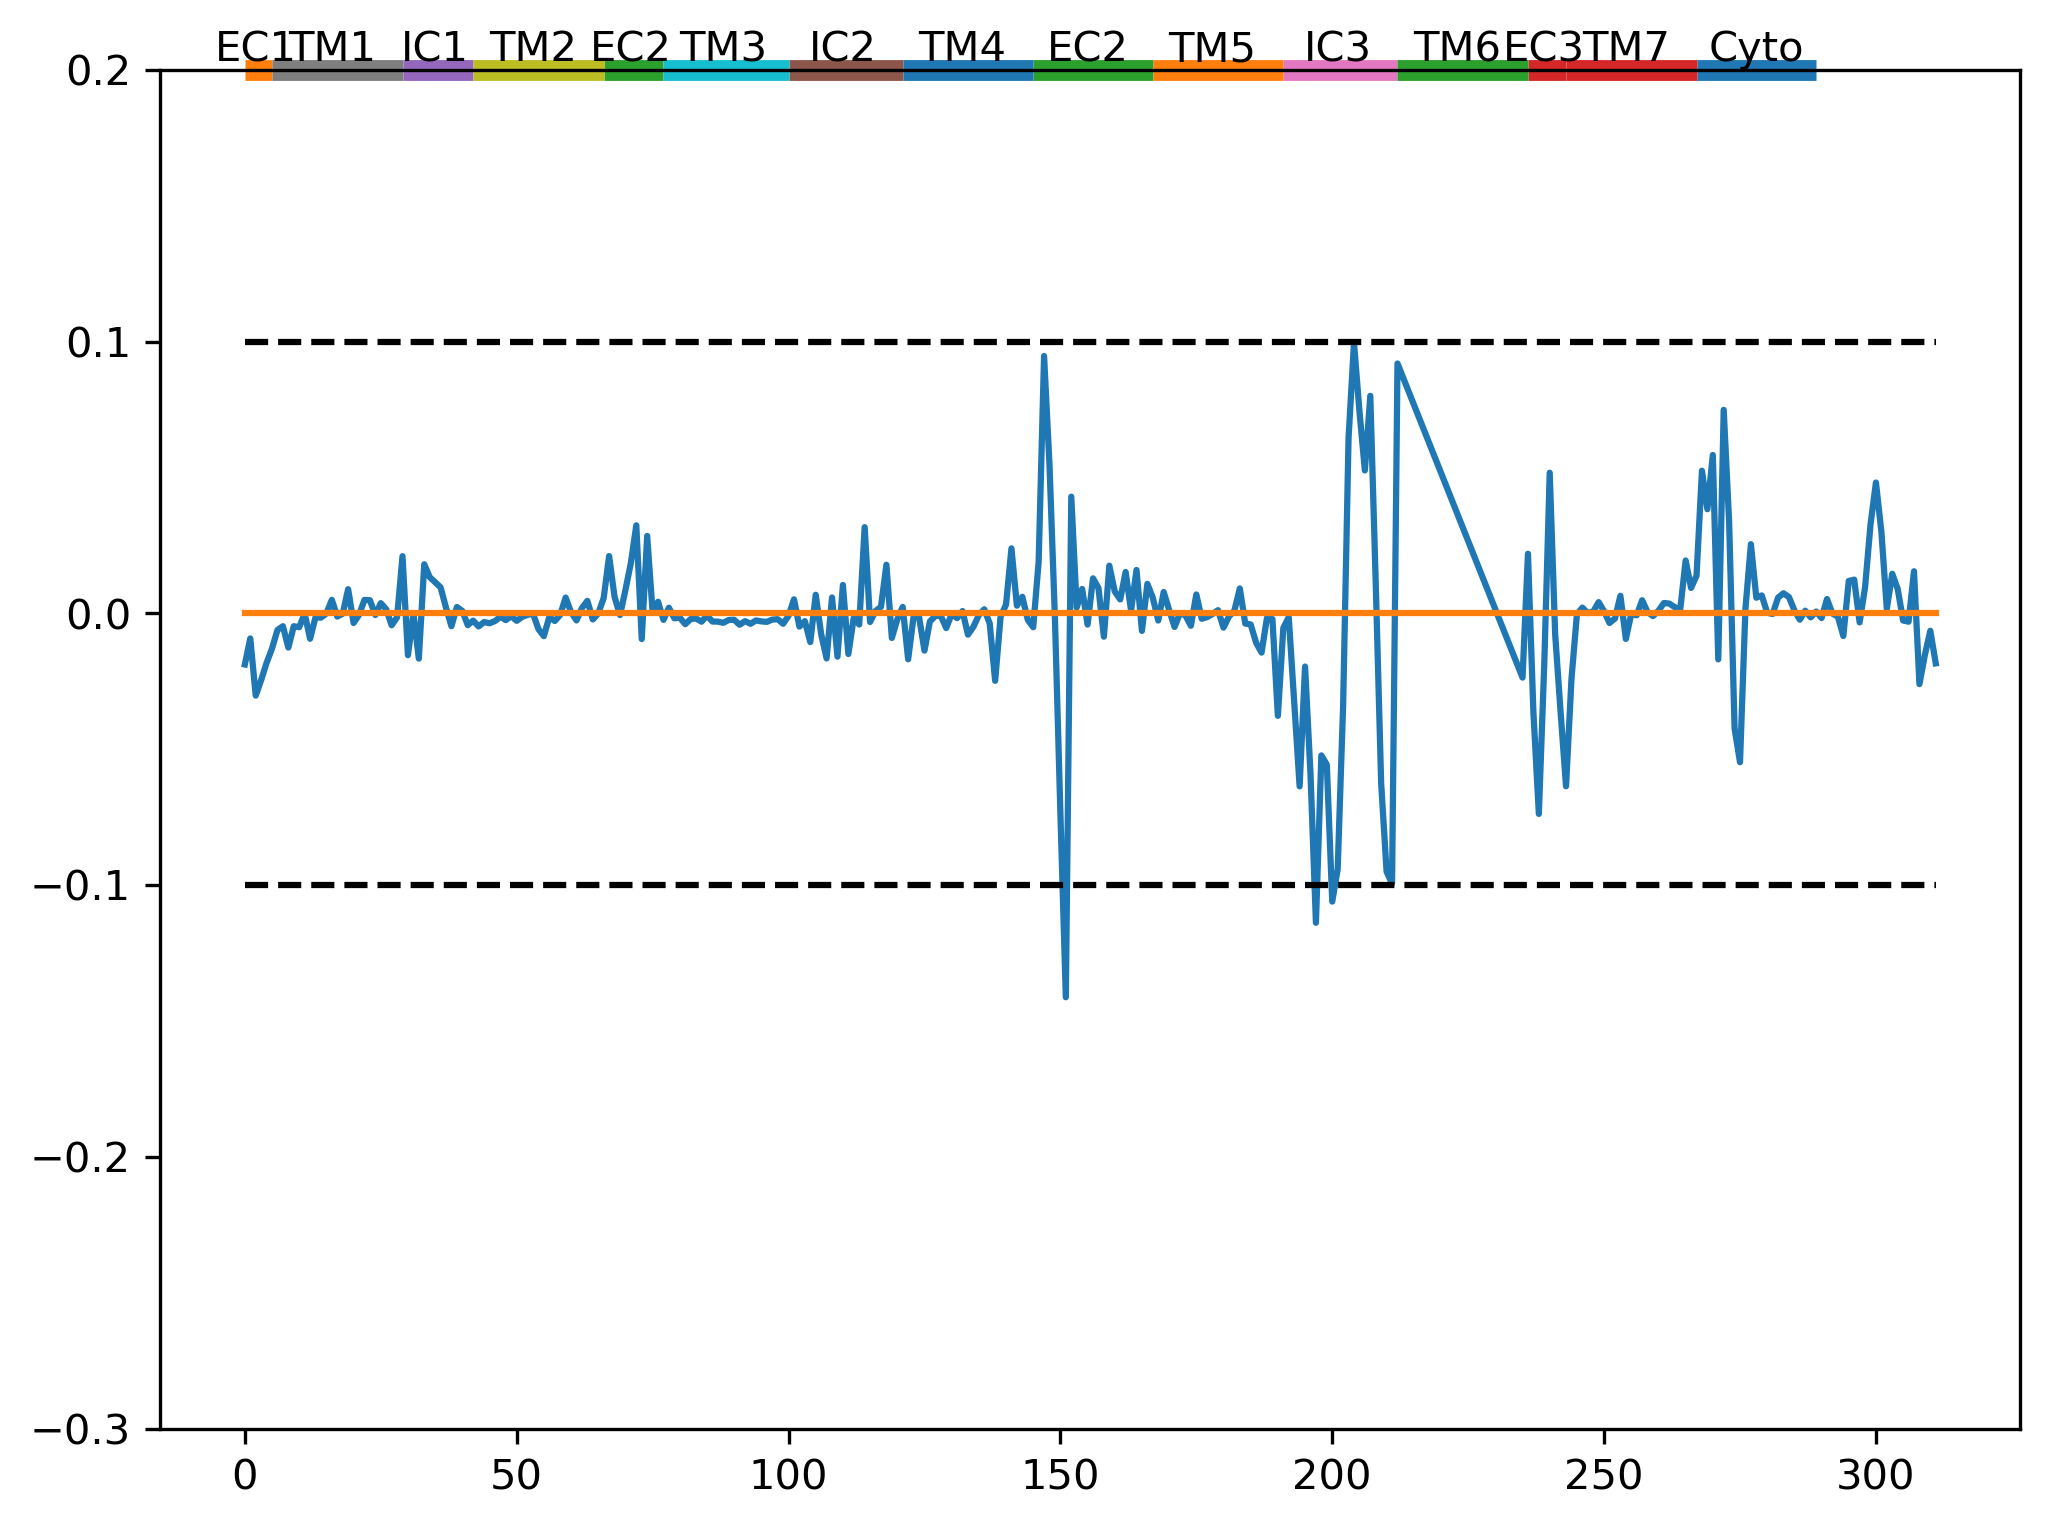

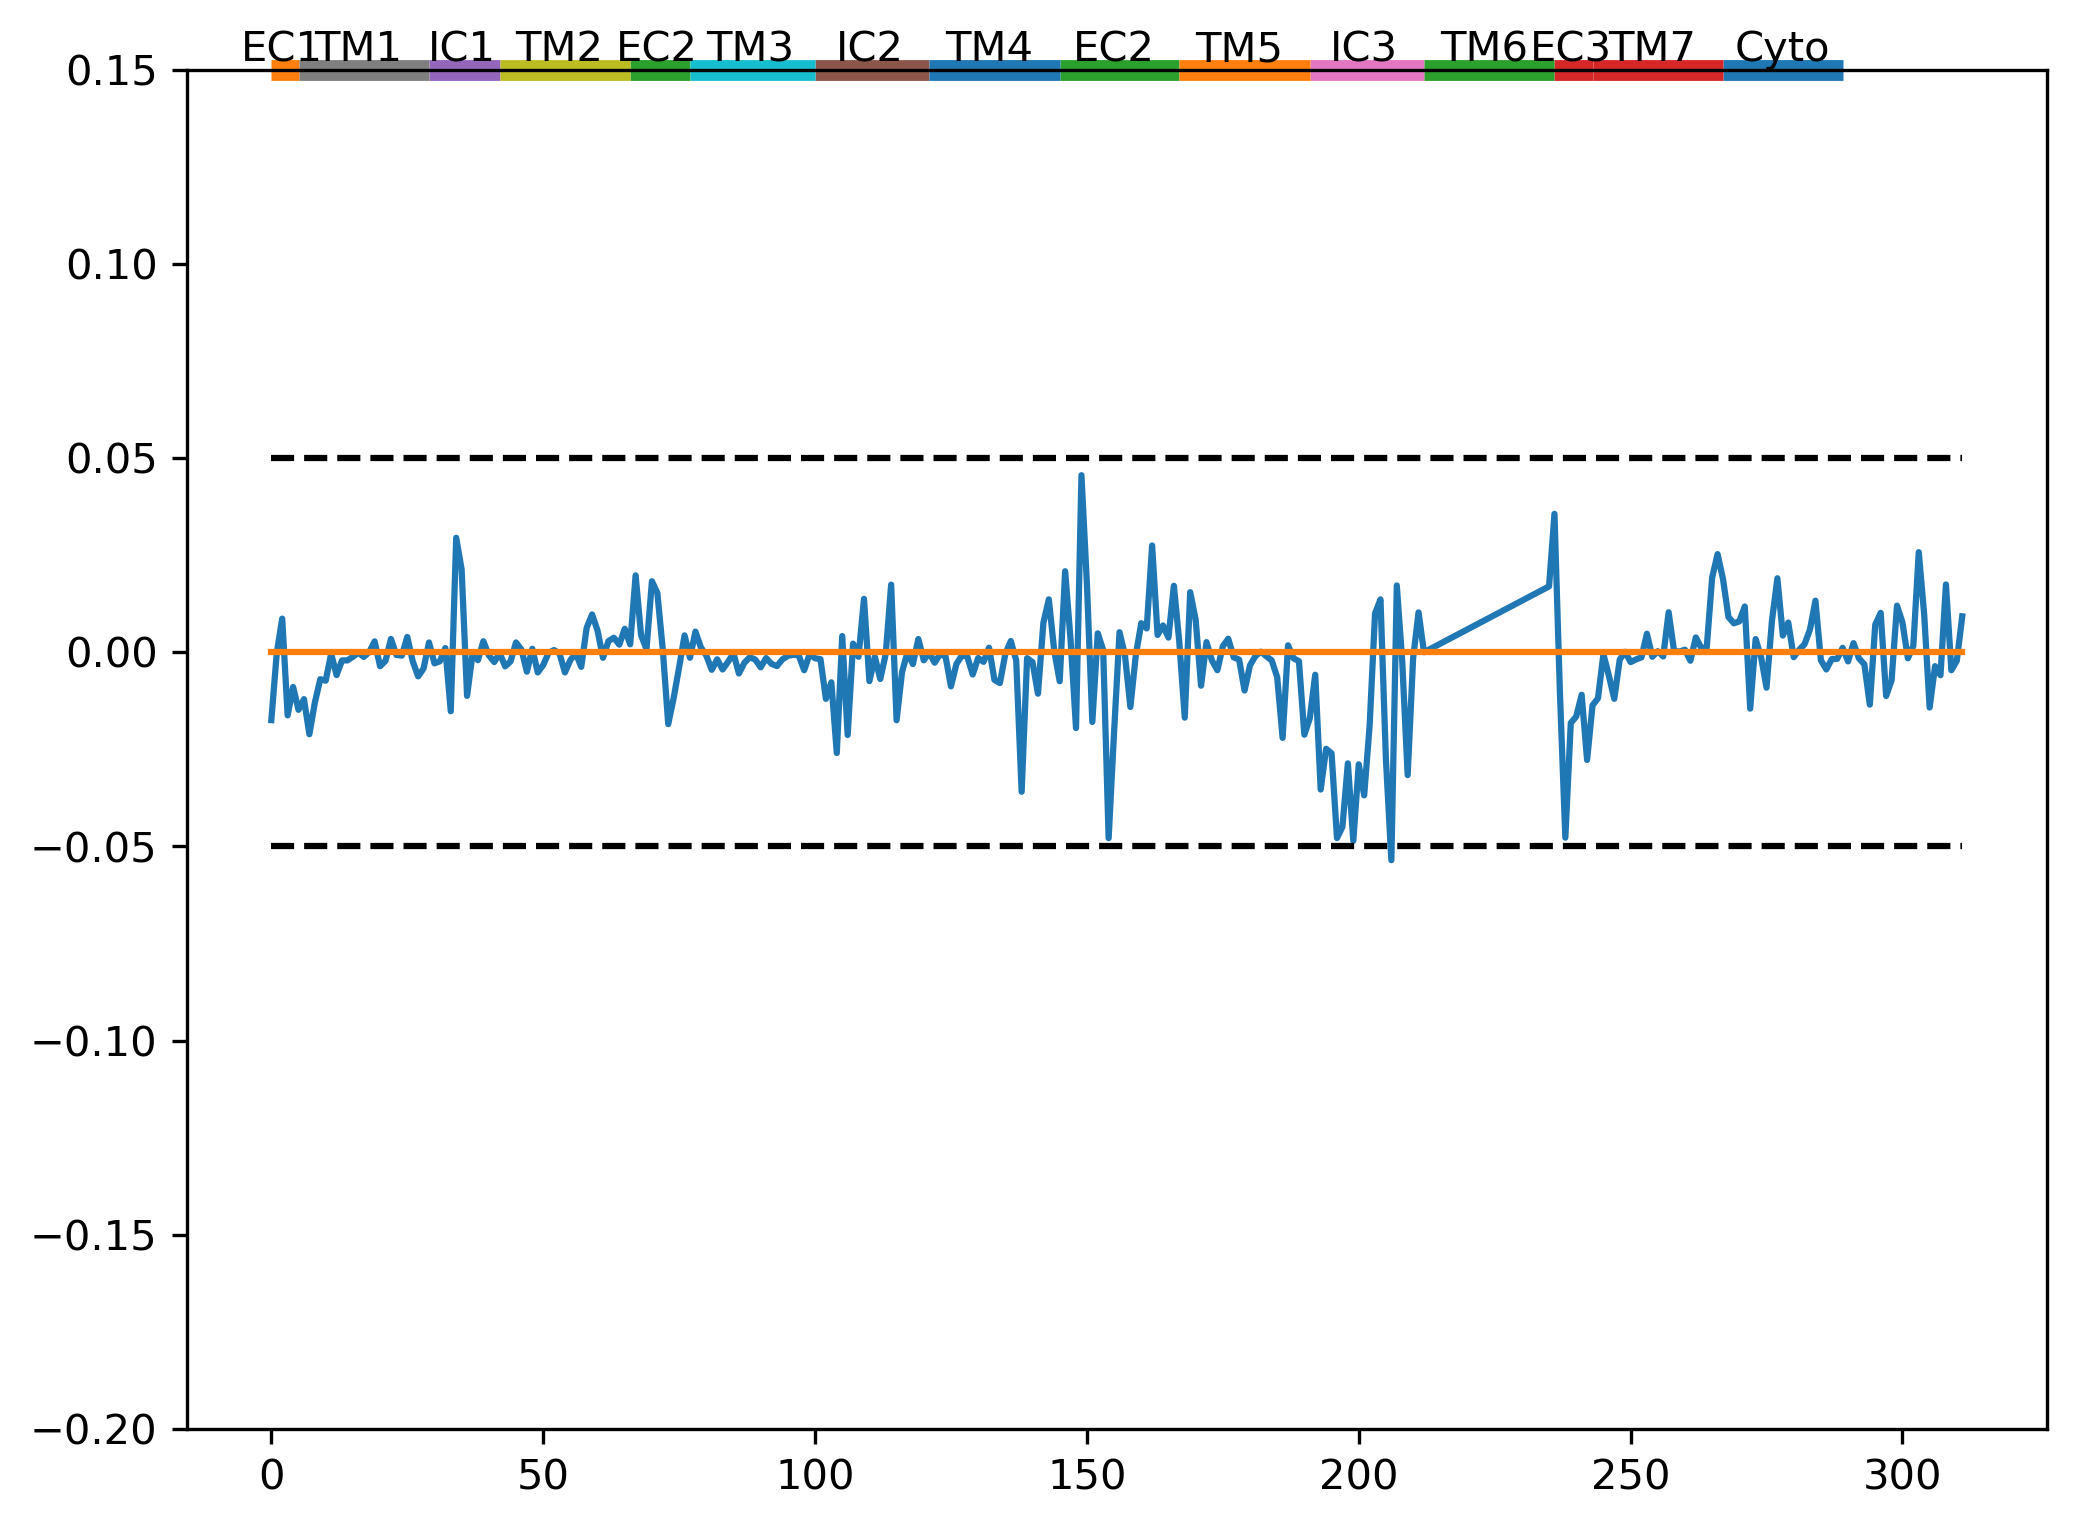

3


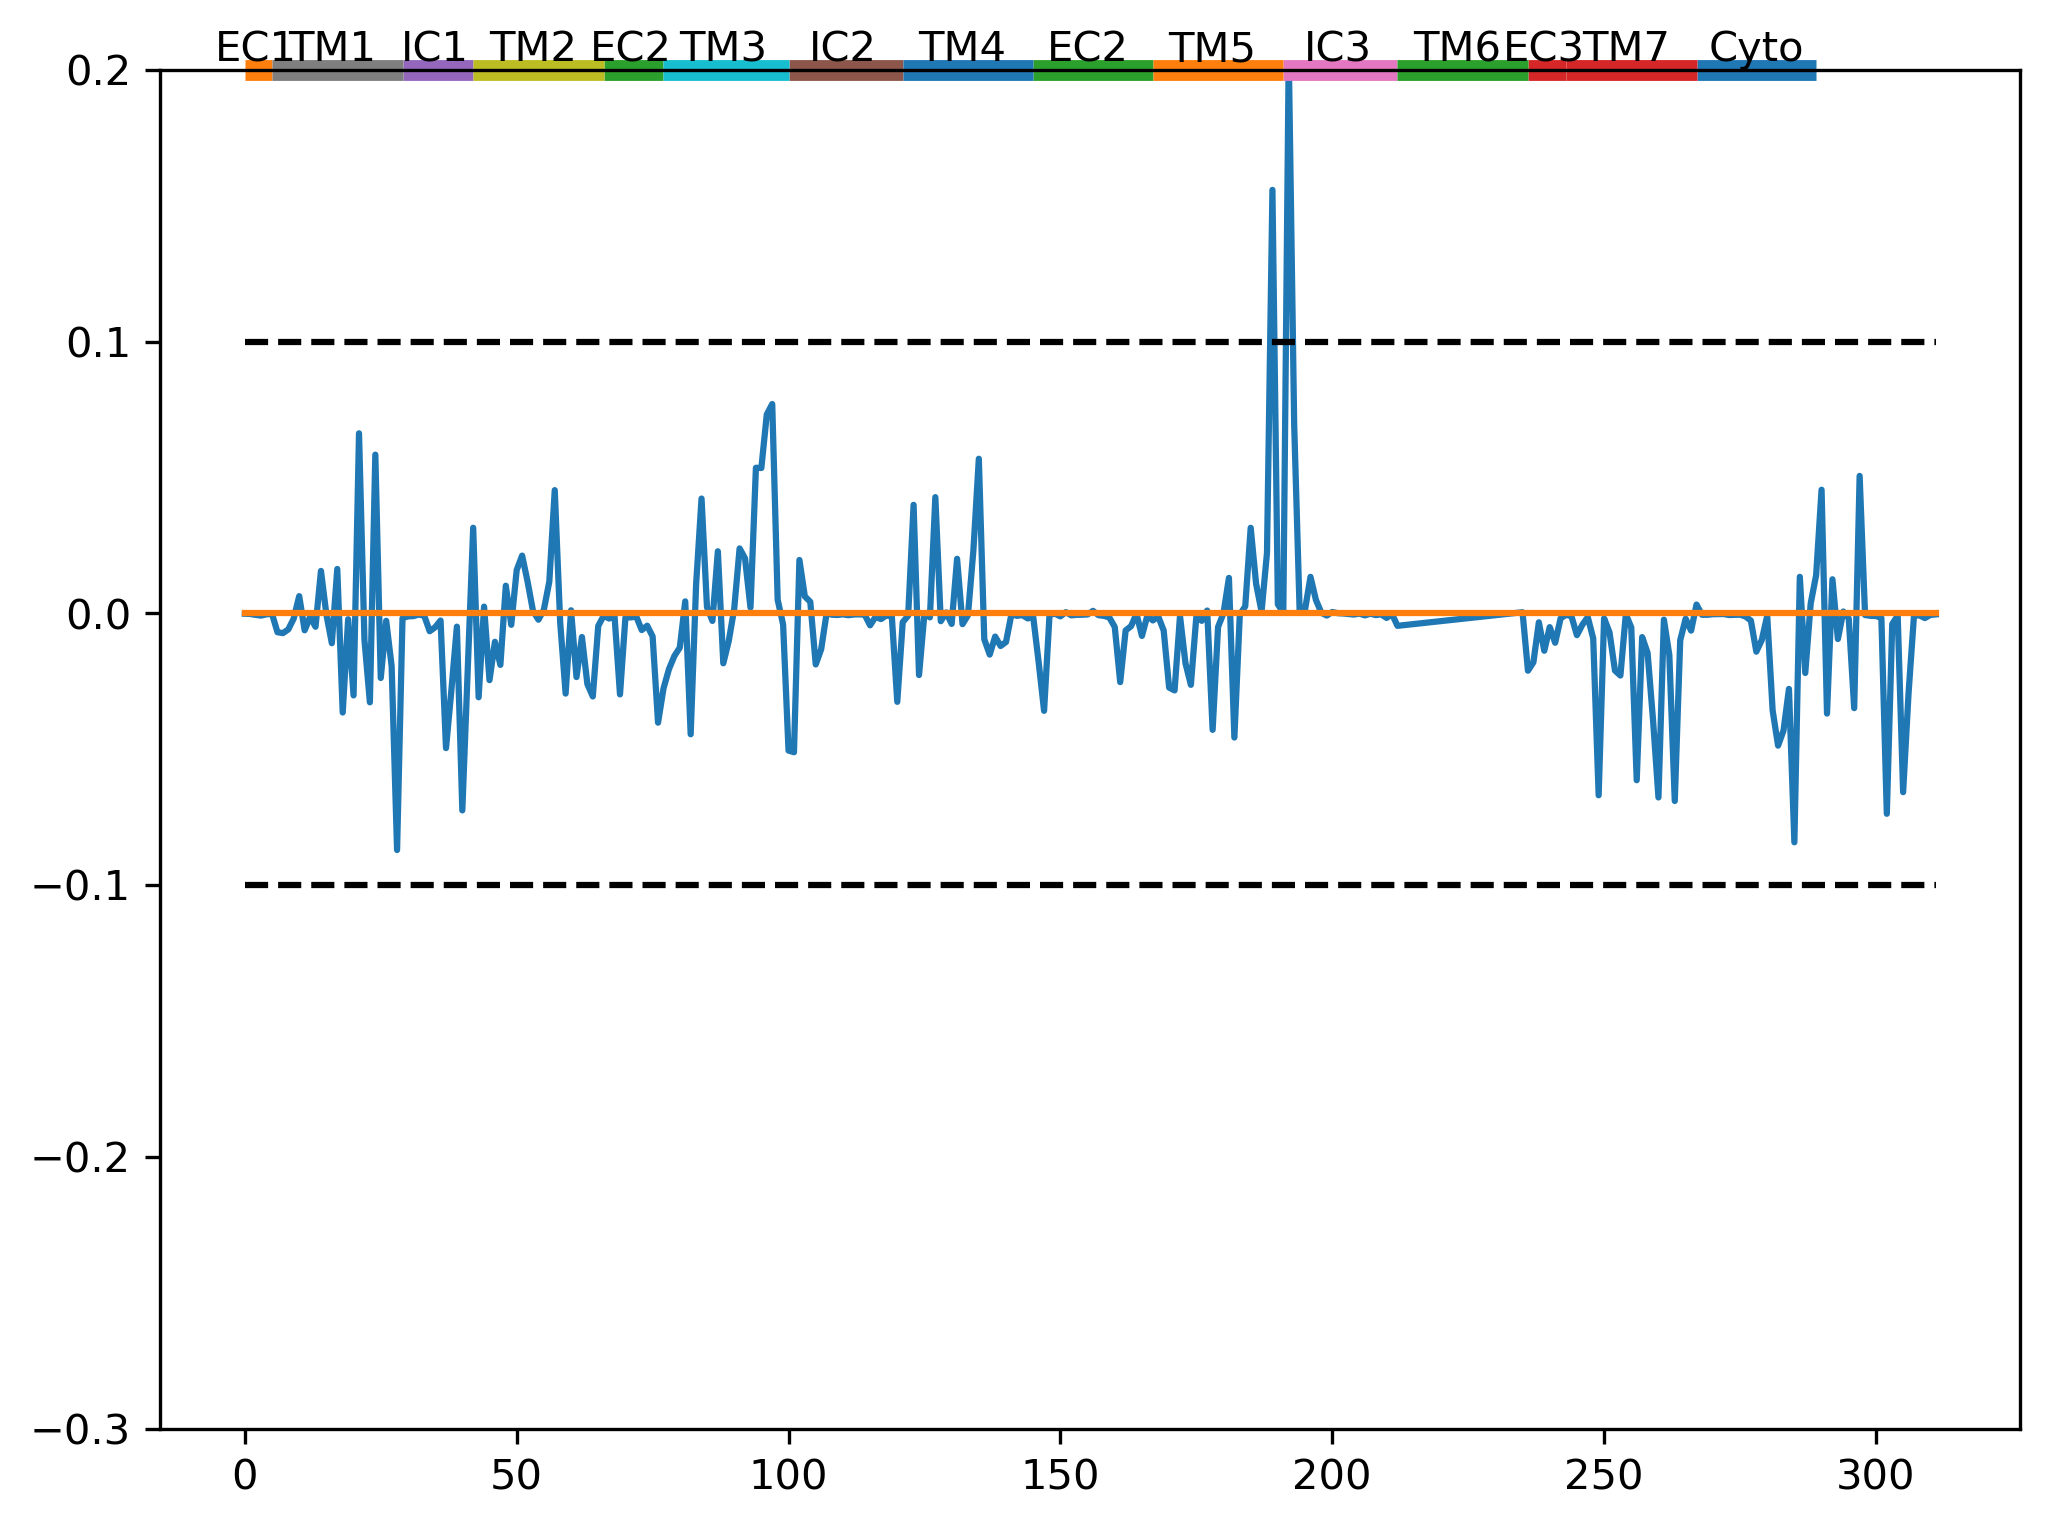

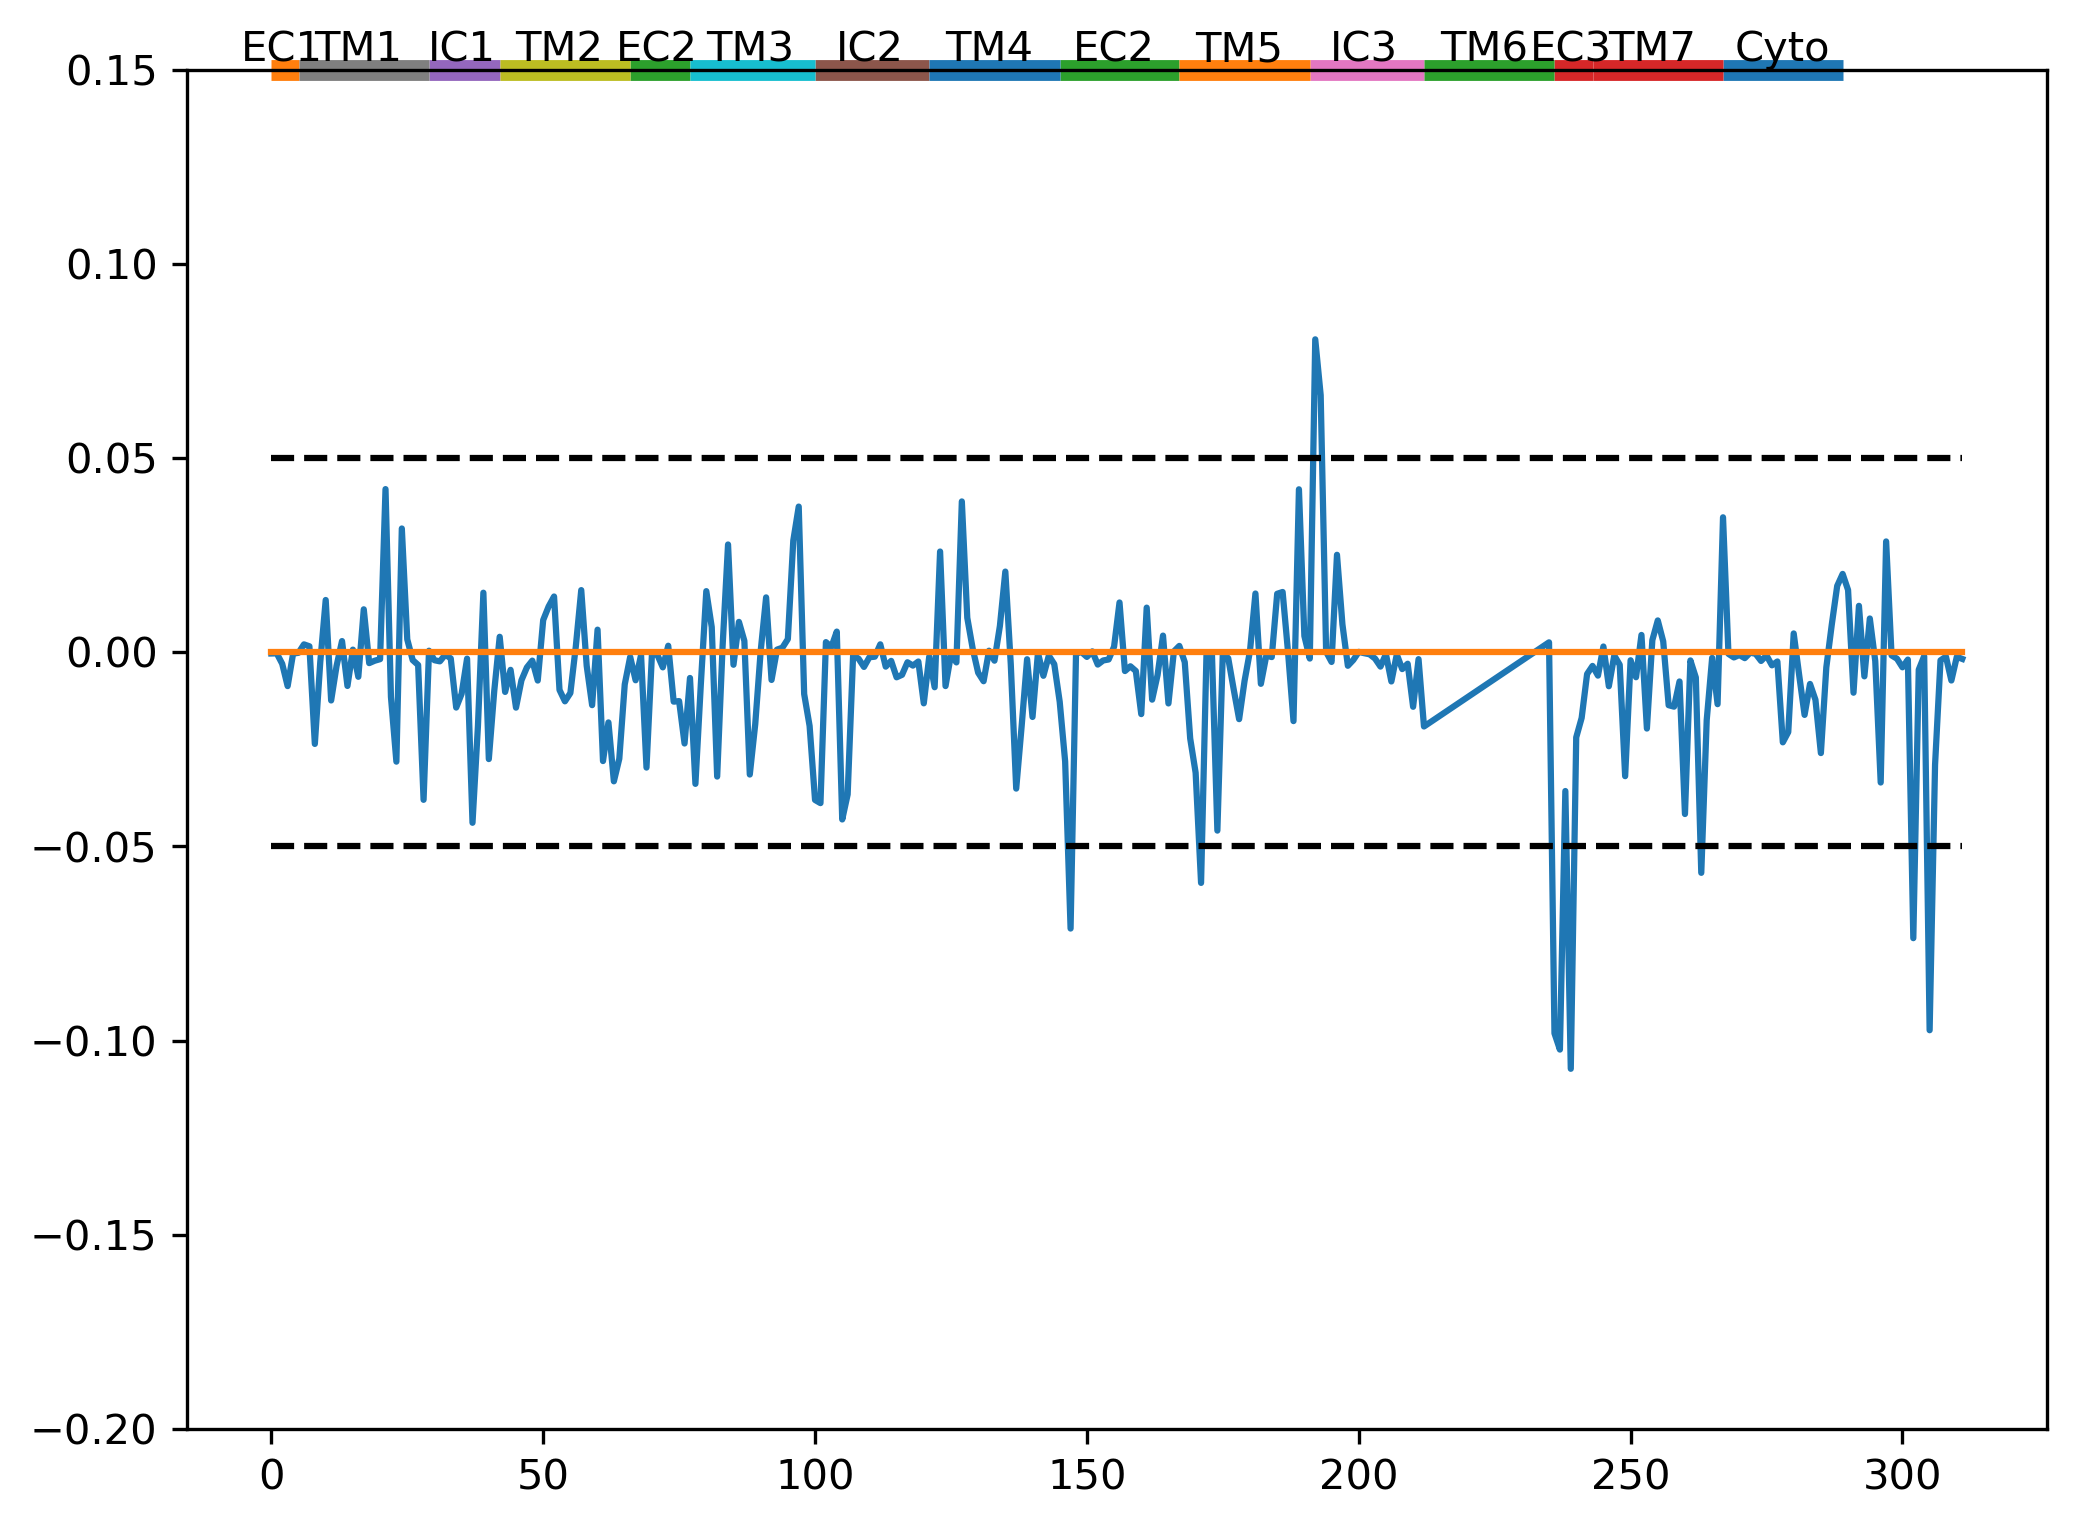

In [52]:
for x in range(4):
    print(x)
    means_a = calcSignatureSqFlucts(gnms_a[:,windows_a[x][0]:windows_a[x][1]]).mean()
    sd_a = calcSignatureSqFlucts(gnms_a[:,windows_a[x][0]:windows_a[x][1]]).std()
    
    means_i = calcSignatureSqFlucts(gnms_i[:,windows_i[x][0]:windows_i[x][1]]).mean()
    sd_i = calcSignatureSqFlucts(gnms_i[:,windows_i[x][0]:windows_i[x][1]]).std()
    
    full_means = []
    full_vars = []
    full_resnums = list(ens_a[0].getAtoms().getResnums())
    for res in ref_active.getResnums():
            if res in full_resnums:
                full_means.append(means_a[full_resnums.index(res)]-means_i[full_resnums.index(res)])
                full_vars.append(sd_a[full_resnums.index(res)]-sd_i[full_resnums.index(res)])
            else:
                full_means.append(0.0)
                full_vars.append(0.0)
                
    zero_line = [0 for x in full_resnums]
    top_mean = [0.1 for x in full_resnums]
    bot_mean = [-0.1 for x in full_resnums]
    top_vars = [0.05 for x in full_resnums]
    bot_vars = [-0.05 for x in full_resnums]
    
    figure(figsize=(8, 6), dpi=300)
    sns.lineplot(x=[x-30 for x in full_resnums],y=full_means)
    plt.plot([x-30 for x in full_resnums],zero_line)
    plt.plot([x-30 for x in full_resnums],top_mean,'k--')
    plt.plot([x-30 for x in full_resnums],bot_mean,'k--')
    plt.ylim(-0.3,0.2)
    showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A-diff-means_profile_modes_' + str(x) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()
    
    figure(figsize=(8, 6), dpi=300)
    sns.lineplot(x=[x-30 for x in full_resnums],y=full_vars)
    plt.plot([x-30 for x in full_resnums],zero_line)
    plt.plot([x-30 for x in full_resnums],top_vars,'k--')
    plt.plot([x-30 for x in full_resnums],bot_vars,'k--')
    plt.ylim(-0.2,0.15)
    showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A-diff-devs_profile_modes_' + str(x) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()
    
    #writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts-diff_means-' + str(x) + '.pdb', ref_active, beta=full_means)
    #writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts-diff_devs-' + str(x) + '.pdb', ref_active, beta=full_vars)

0


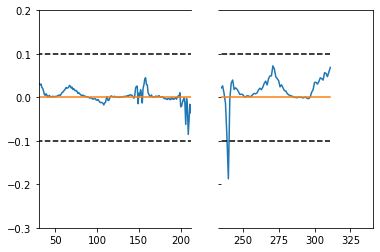

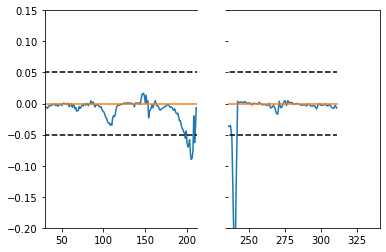

1


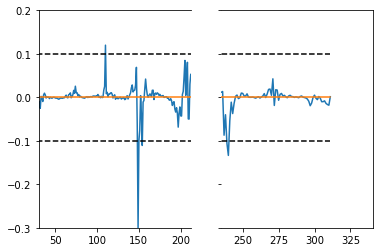

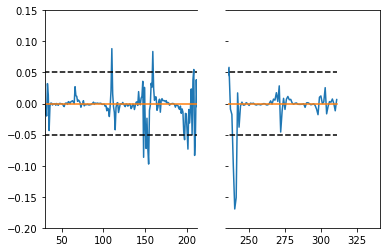

2


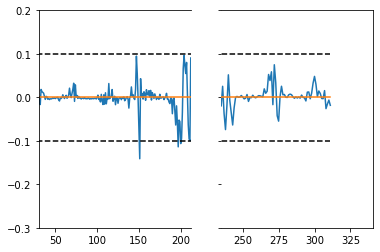

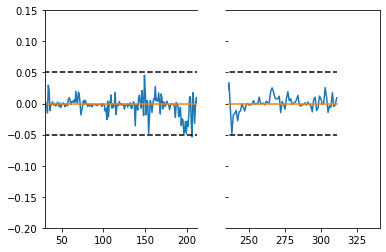

3


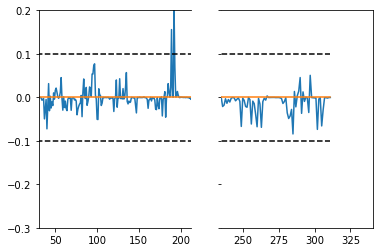

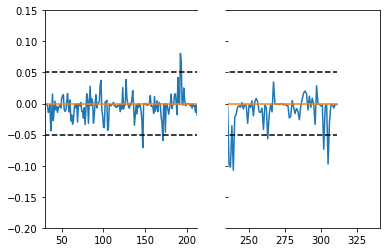

In [57]:
for x in range(4):
    print(x)
    means_a = calcSignatureSqFlucts(gnms_a[:,windows_a[x][0]:windows_a[x][1]]).mean()
    sd_a = calcSignatureSqFlucts(gnms_a[:,windows_a[x][0]:windows_a[x][1]]).std()
    
    means_i = calcSignatureSqFlucts(gnms_i[:,windows_i[x][0]:windows_i[x][1]]).mean()
    sd_i = calcSignatureSqFlucts(gnms_i[:,windows_i[x][0]:windows_i[x][1]]).std()
    
    full_means = []
    full_vars = []
    full_resnums = list(ens_a[0].getAtoms().getResnums())
    for res in ref_active.getResnums():
            if res in full_resnums:
                full_means.append(means_a[full_resnums.index(res)]-means_i[full_resnums.index(res)])
                full_vars.append(sd_a[full_resnums.index(res)]-sd_i[full_resnums.index(res)])
            else:
                full_means.append(0.0)
                full_vars.append(0.0)
                
    zero_line = [0 for x in full_resnums]
    top_mean = [0.1 for x in full_resnums]
    bot_mean = [-0.1 for x in full_resnums]
    top_vars = [0.05 for x in full_resnums]
    bot_vars = [-0.05 for x in full_resnums]
    
    f, (ax, ax2) = plt.subplots(1, 2, sharey=True)
    ax.plot([x-30 for x in full_resnums],full_means)
    ax2.plot([x-30 for x in full_resnums],full_means)
    ax.plot([x-30 for x in full_resnums],zero_line)
    ax.plot([x-30 for x in full_resnums],top_mean,'k--')
    ax.plot([x-30 for x in full_resnums],bot_mean,'k--')
    ax2.plot([x-30 for x in full_resnums],zero_line)
    ax2.plot([x-30 for x in full_resnums],top_mean,'k--')
    ax2.plot([x-30 for x in full_resnums],bot_mean,'k--')
    plt.ylim(-0.3,0.2)
    ax.set_xlim(30,212)
    ax2.set_xlim(235,341)
    
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.xaxis.tick_bottom()
    ax2.xaxis.tick_bottom()
    
    #showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A-diff-means_profile_modes_' + str(x) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()


    f, (ax, ax2) = plt.subplots(1, 2, sharey=True)
    ax.plot([x-30 for x in full_resnums],full_vars)
    ax2.plot([x-30 for x in full_resnums],full_vars)
    ax.plot([x-30 for x in full_resnums],zero_line)
    ax.plot([x-30 for x in full_resnums],top_vars,'k--')
    ax.plot([x-30 for x in full_resnums],bot_vars,'k--')
    ax2.plot([x-30 for x in full_resnums],zero_line)
    ax2.plot([x-30 for x in full_resnums],top_vars,'k--')
    ax2.plot([x-30 for x in full_resnums],bot_vars,'k--')
    plt.ylim(-0.2,0.15)
    ax.set_xlim(30,212)
    ax2.set_xlim(235,341)
    
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.xaxis.tick_bottom()
    ax2.xaxis.tick_bottom()
    
    #showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'New_GPCR-Dali-Class-A-diff-devs_profile_modes_' + str(x) + '.png',dpi=300,transparent=False)
    plt.show()
    plt.close()
 
    
    writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts-diff_means-' + str(x) + '.pdb', ref_active, beta=full_means)
    writePDB(FIG + 'New_GPCR-Dali-Class-A_mode_flucts-diff_devs-' + str(x) + '.pdb', ref_active, beta=full_vars)

## ESSA Calculations

In [ ]:
ag = parsePDB('7dhi', chain='R', compressed=False)

In [ ]:
essa = ESSA()

In [ ]:
essa.setSystem(ag, lig='R 401')

In [ ]:
essa.scanResidues()

In [ ]:
essa.showESSAProfile?

In [ ]:
with style.context({'figure.dpi': 100}):
    essa.showESSAProfile()
    showDomainBar(resdomains,loc=1)
    #plt.savefig(FIG + 'ESSA_7dhi_profile.png',dpi=300)

In [ ]:
essa.getESSAZscores()[:10]

In [ ]:
essa.saveESSAZscores()

In [ ]:
essa.writeESSAZscoresToPDB()

In [ ]:
essa.getESSAEnsemble()

In [ ]:
showSignatureSqFlucts(essa.getESSAEnsemble())

In [ ]:
essa_ensemble = essa.getESSAEnsemble()

In [ ]:
means = calcSignatureSqFlucts(essa_ensemble).mean()
sd = calcSignatureSqFlucts(essa_ensemble).std()
full_means = []
full_vars = []
full_resnums = list(ens[0].getAtoms().getResnums())
for res in ref_structure.getResnums():
        if res in full_resnums:
            full_means.append(means[full_resnums.index(res)])
            full_vars.append(sd[full_resnums.index(res)])
        else:
            full_means.append(0.0)
            full_vars.append(0.0)
writePDB(FIG + 'ESSA_7dhi-means.pdb', ref_structure, beta=full_means)
writePDB(FIG + 'ESSA_7dhi-vars.pdb', ref_structure, beta=full_vars)

In [ ]:
ens_e = essa.getESSAEnsemble()

In [ ]:
ens_e[0]

#### Look at other mode #s

In [ ]:
essa.scanResidues?

In [ ]:
ag = parsePDB('7dhi', chain='R', compressed=False)
essa = ESSA()
essa.setSystem(ag, lig='R 401')

In [ ]:
essa.scanResidues()

In [ ]:
quantile(essa.getESSAZscores(),q=0.75)

In [ ]:
for num in [3,10,20,None]:
    print(num)
    essa.scanResidues(n_modes=num)
    
    quant = quantile(essa.getESSAZscores(),q=0.75)
    print(quant)
    
    with style.context({'figure.dpi': 100}):
        essa.showESSAProfile()
        plt.ylim(-2,5)
        showDomainBar(resdomains,loc=1)
        #plt.savefig(FIG + 'ESSA_7dhi_profile-' + str(num) + '-modes.png',dpi=300)
        plt.show()
        plt.close()
    
        showSignatureSqFlucts(essa.getESSAEnsemble())
        plt.title('')
        plt.ylim(0,0.35)
        showDomainBar(resdomains,loc=1)
        #plt.savefig(FIG + 'ESSA_7dhi_flucts-' + str(num) + '-modes.png',dpi=300)
        plt.show()
        plt.close()
        
        writePDB(FIG + 'ESSA_7dhi_zscores-' + str(num) + '-modes.pdb', ref_structure, beta=essa.getESSAZscores())

### See which residue perturbations have the biggest effect on each residue

In [ ]:
ag = parsePDB('7dhi', chain='R', compressed=False)
essa = ESSA()
essa.setSystem(ag, lig='R 401')
essa.scanResidues()

In [171]:
pdb_pos = '6n48_rec.pdb'
pdb_neg = '6oba_rec.pdb'

In [ ]:
ag = parsePDB(pdb_neg, compressed=False)
essa = ESSA()
essa.setSystem(ag)
essa.scanResidues()

In [ ]:
ref_structure = parsePDB(pdb_neg)
ref_short = parsePDB(pdb_neg, subset='ca')

In [ ]:
zscores_pos = essa.getESSAZscores()

In [ ]:
zscores_neg = essa.getESSAZscores()

#### Compare zscores of positive and negative allosteric modulator bound structures

In [ ]:
with style.context({'figure.dpi': 100}):
    essa.showESSAProfile()
    showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'impacts/shift/6n48/ESSA_6n4b_profile.png',dpi=300)

In [ ]:
with style.context({'figure.dpi': 100}):
    essa.showESSAProfile()
    showDomainBar(resdomains,loc=1)
    plt.savefig(FIG + 'impacts/shift/6oba/ESSA_6oba_profile.png',dpi=300)

In [ ]:
print(len(zscores_pos), len(zscores_neg))

In [ ]:
zscores_pos = list(zscores_pos)
zscores_neg = list(zscores_neg)

In [ ]:
zscores_neg.insert(200, zscores_pos[200])

In [ ]:
ag = parsePDB(pdb_pos, subset='ca', compressed=False)
del zscores_pos[list(ag.getResnums()).index(1231)]

In [ ]:
sns.scatterplot(x=zscores_pos, y=zscores_neg)

In [ ]:
full_zscores = []
full_zscores2 = []
pos_zscores = []
neg_zscores = []

resnums = list(set(ref_pos.getResnums()))

for resnum in ref_pos.getResnums():
    try:
        index = resnums.index(resnum)
        full_zscores.append(zscores_pos[index] - zscores_neg[index])
    except ValueError:
        full_zscores.append(0)
    except IndexError:
        full_zscores.append(0)
        
resnums = list(set(ref_neg.getResnums()))

for resnum in ref_neg.getResnums():
    try:
        index = resnums.index(resnum)
        full_zscores2.append(zscores_neg[index] - zscores_pos[index])
    except ValueError:
        full_zscores2.append(0)
    except IndexError:
        full_zscores2.append(0)

resnums = list(set(ref_pos.getResnums()))

for resnum in ref_pos.getResnums():
    try:
        index = resnums.index(resnum)
        pos_zscores.append(zscores_pos[index])
    except ValueError:
        pos_zscores.append(0)
    except IndexError:
        pos_zscores.append(0)

resnums = list(set(ref_neg.getResnums()))

for resnum in ref_neg.getResnums():
    try:
        index = resnums.index(resnum)
        neg_zscores.append(zscores_neg[index])
    except ValueError:
        neg_zscores.append(0)
    except IndexError:
        neg_zscores.append(0)


In [ ]:
ref_pos = parsePDB(pdb_pos)
ref_neg = parsePDB(pdb_neg)

In [ ]:
writePDB(FIG + 'impacts/shift/6oba/ESSA_zscores_6oba.pdb', ref_neg, beta=neg_zscores)
writePDB(FIG + 'impacts/shift/6oba/ESSA_zscores_diff.pdb', ref_neg, beta=full_zscores2)
writePDB(FIG + 'impacts/shift/6n48/ESSA_zscores_6n48.pdb', ref_pos, beta=pos_zscores)
writePDB(FIG + 'impacts/shift/6n48/ESSA_zscores_diff2.pdb', ref_pos, beta=full_zscores)

In [ ]:
print(min(zscores_pos), max(zscores_pos))
print(min(zscores_neg), max(zscores_neg))
print(min(full_zscores), max(full_zscores))

In [ ]:
ens = essa.getESSAEnsemble()

In [ ]:
ens

In [ ]:
from scipy.stats import zscore
from scipy.stats import logistic
from prody import ModeEnsemble

In [ ]:
def convertToSigmoid(array):
    return np.array([logistic.cdf(x) for x in array])

In [ ]:
def calcImpact(mode_ensemble, **kwargs):
    """
    For each residue, find out the which residue perturbations have the strongest impact. 
    
    :arg mode_ensemble: an ensemble of ENMs 
    :type mode_ensemble: :class: `ModeEnsemble`
    
    :keyword raw: whether to use raw square fluctuations or calculate difference from unperturbed. Default is **False**.
    :type raw: bool
    
    :keyword modes: if you want to calc MSFs from a slice of the modes, give a start and stop value
    :type modes: tuple
    """
    
    if not isinstance(mode_ensemble, ModeEnsemble):
        raise TypeError('mode_ensemble should be an instance of ModeEnsemble')
    
    if not mode_ensemble.isMatched():
        LOGGER.warn('modes in mode_ensemble did not match cross modesets. '
                    'Consider running mode_ensemble.match() prior to using this function')
        
    ifraw = kwargs.pop('raw', False)
    modes = kwargs.pop('modes', None)
    ifscale = kwargs.pop('scale', False)
    ifnorm = kwargs.pop('norm', False)
    
    flucts = []
    # Calculate square fluctuations for each structure (perturbation) in *mode_ensemble*
    for i, modeset in enumerate(mode_ensemble):
        if modes is None:
            sqfs = calcSqFlucts(modeset)
        else:
            if modes[1] != 0:
                sqfs = calcSqFlucts(modeset[modes[0]:modes[1]])
            else:
                sqfs = calcSqFlucts(modeset[modes[0]:])
        flucts.append(sqfs)

        
    if ifraw: # Want calculations based on raw square fluctuations, get rid of row with no perturbations and continue
        flucts = np.vstack(flucts[1:])
        
            
        return flucts
    else: # Want to scale values, (perturbed - base)*100/base
        if ifnorm:
            temp = []
            for row in flucts[1:]:
                #norm = np.array([abs(x) for x in row]).sum()
                norm = row.sum()
                temp.append([row[x]/norm for x in range(len(row))])

            flucts = np.vstack(temp)
            return flucts
        else:
            temp = []
            for row in flucts[1:]:
                temp.append([(row[x] - flucts[0][x])*100/flucts[0][x] for x in range(len(row))])

            flucts = np.vstack(temp)
    
    if ifscale:
        return flucts

    
    else:
        # Convert each value to a z-score based on the entire array, not just within each residue
        Z = np.vstack(zscore(flucts))

        sig = []
        for res in Z: # Want normalized output, converting Z-score values to sigmoid function to make values (0,1)
            sig.append(convertToSigmoid(res))

        return np.vstack(sig)

In [ ]:
test = calcImpact(ens)

In [ ]:
test.shape

In [ ]:
def saveImpactsToPDB(impacts, reference, pdb):
    resnums = ens.getAtoms().getResnums()
    if len(reference.getResnums()) > len(impacts):
        for res in range(len(impacts)):
            betas_full = []
            for resnum in reference.getResnums():
                try:
                    index = list(ens.getAtoms().getResnums()).index(resnum)
                    betas_full.append(impacts[res][index])
                except ValueError:
                    betas_full.append(0.5)
            writePDB(FIG + 'impacts/shift/' + pdb + '/long/ESSA_impact_residue-' + str(resnums[res]) + '-long.pdb', reference, beta=betas_full)
        
    else:
        for res in range(len(impacts)):
            writePDB(FIG + 'impacts/shift/' + pdb + '/ESSA_impact_residue-' + str(resnums[res]) + '.pdb', reference, beta=impacts[res]) #Actual residue #s
            #writePDB(FIG + 'inorder/ESSA_impact_residue-' + str(res) + '.pdb', reference, beta=impacts[res]) #For pymol movie
    
    return

In [ ]:
len(test)

In [ ]:
list(ens.getAtoms().getResnums()).index(47)

In [ ]:
len(ref_structure.getResnums())

In [ ]:
saveImpactsToPDB(test, ref_structure, '6oba')

In [ ]:
ligs = essa.getLigandResidueIndices()['R401']

In [ ]:
ligs

In [ ]:
resnums = ens.getAtoms().getResnums()

In [ ]:
def saveImpactsToPNG(impacts, pdb):
    resnums = ens.getAtoms().getResnums()
    for x in range(len(test[0])):
        sns.lineplot(resnums, impacts[:,x])
        plt.ylim(0,1)
        #showDomainBar(resdomains,loc=1)
        plt.plot(resnums, [0.5 for i in resnums], 'y-')
        plt.plot(resnums[x], impacts[x,x], 'r*')
        #plt.plot(ligs, [impacts[x,j] for j in ligs], 'm*')
        plt.savefig(FIG + 'impacts/shift/' + pdb + '/ESSA_impact_residue-' + str(resnums[x]) + '.png',dpi=300)
        plt.show()
        plt.close()
    return

In [ ]:
sns.lineplot(x=resnums, y=test[1:,235])
plt.plot(resnums[235], test[235+1,235], 'r*')
plt.plot(ligs, [test[j,235+1] for j in ligs], 'm*')

In [ ]:
test[1,79]

In [ ]:
saveImpactsToPNG(test, '6oba')

In [ ]:
test

In [ ]:
test.shape

In [ ]:
test.shape

In [ ]:
test

In [ ]:
len(ens.getAtoms().getResnums())

In [ ]:
sns.lineplot(ens.getAtoms().getResnums(), flucts[1:,235])

In [ ]:
zscores = zscore(flucts[1:,235])

In [ ]:
sns.lineplot(ens.getAtoms().getResnums(), zscores)

In [ ]:
sig = convertToSigmoid(zscores)

In [ ]:
ens.getAtoms().getResnums()[235]

In [ ]:
sns.lineplot(ens.getAtoms().getResnums(), sig)
plt.plot(ens.getAtoms().getResnums(), [0.5 for x in ens.getAtoms().getResnums()])

In [ ]:
len(ens[1][0])

In [ ]:
ens[0][0].getEigval()

In [ ]:
len(ens[0][0].getEigvec())

In [ ]:
len(ens[0][0].getEigvec())

### Try py3Dmol visualization for mode ensemble

In [ ]:
pdb_pos = '6n48_rec.pdb'
pdb_neg = '6oba_rec.pdb'

In [ ]:
lig_pos = 'A 1401 A 1403'
lig_neg = 'A 1203 A 1204'

In [ ]:
ag_pos = parsePDB(pdb_pos, compressed=False)
essa_pos = ESSA()
essa_pos.setSystem(ag_pos, lig=lig_pos)
essa_pos.scanResidues(n_modes=None)

In [ ]:
ag_neg = parsePDB(pdb_neg, compressed=False)
essa_neg = ESSA()
essa_neg.setSystem(ag_neg, lig=lig_neg)
essa_neg.scanResidues(n_modes=None)

In [ ]:
impacts_pos = calcImpact(essa_pos.getESSAEnsemble(),modes=(0,10))
impacts_neg = calcImpact(essa_neg.getESSAEnsemble(),modes=(0,10))

In [ ]:
ind_pos = essa_pos.getLigandResidueIndices()
ind_neg = essa_neg.getLigandResidueIndices()

In [ ]:
ind_pos = [str(x) for x in ind_pos['A1401']] + [str(x) for x in ind_pos['A1403']]
ind_neg = [str(x) for x in ind_neg['A1203']] + [str(x) for x in ind_neg['A1204']]

In [ ]:
#PATH = '/Users/bentley/Dropbox/Pitt/Bahar/GPCRs/figures/ClassA/impacts/shift/long/' # Mac version
PATH_pro = '/home/bentley/Dropbox/Pitt/Bahar/GPCRs/figures/ClassA/impacts/shift/6n48/long/' # Linux version
PATH_neg = '/home/bentley/Dropbox/Pitt/Bahar/GPCRs/figures/ClassA/impacts/shift/6oba/long/'
structures_pro = [x for x in os.listdir(PATH_pro) if x.endswith("pdb") and "impact" in x]
structures_neg = [x for x in os.listdir(PATH_neg) if x.endswith("pdb") and "impact" in x]
resnums_pro = [int(x.split('-')[1]) for x in structures_pro]
resnums_pro.sort()
resnums_neg = [int(x.split('-')[1]) for x in structures_neg]
resnums_neg.sort()



In [ ]:
view.mapAtomProperties?

view.setHoverable({},True,'''function(atom,viewer,event,container) {
               if(!atom.label) {
                atom.label = viewer.addLabel(atom.resn+":"+atom.atom,{position: atom, backgroundColor: 'mintcream', fontColor:'black'});
               }}''',
           '''function(atom,viewer) { 
               if(atom.label) {
                viewer.removeLabel(atom.label);
                delete atom.label;
               }
            }''')

In [ ]:
def invertBFactor(line):
    # py3Dmol doesn't have blue-white-red for some reason, so invert values to get correct coloring
    if line.startswith("ATOM"):
        newval = f"{1.0-float(line[63:67]):04}"
        newline = line[:63] + newval + line[67:]
        return newline
    else:
        return line

In [ ]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
def MolTo3DView(pdb_strs, res_nums, size=(1200, 600)):
    """Draw molecule in 3D
    Modified from: https://birdlet.github.io/2019/10/02/py3dmol_example/
    
    Args:
    ----
        pdb_strs: tuple(str, str), pdb files in strings of structures to show
        res_nums: tuple(int, int), residue numbers to show as spheres
        size: tuple(int, int), canvas size
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    view = py3Dmol.view(data=pdb_strs[0],linked=True,viewergrid=(1,3),width=size[0],height=size[1])
    view.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    view.setStyle({'resi':res_nums[0]},{'sphere':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    #view.setStyle({'resi':ind_pos},{'stick':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    view.setStyle({'resn':['P0G']},{'stick':{'colorscheme':'ssPyMol'}},viewer=(0,1))
    view.setStyle({'resn':['KBY']},{'stick':{'colorscheme':[]}},viewer=(0,1))
    view.removeAllModels(viewer=(0,2))
    view.addModel(pdb_strs[1],'pdb',viewer=(0,2))
    view.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    view.setStyle({'resi':res_nums[1]},{'sphere':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    #view.setStyle({'resi':ind_neg},{'stick':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    view.setStyle({'resn':['JTZ']},{'stick':{'colorscheme':'ssPyMol'}},viewer=(0,2))
    view.setStyle({'resn':['M3J']},{'stick':{'colorscheme':[]}},viewer=(0,2))

    return view

In [ ]:
def impact_viewer(idx):
    if idx > 199:
        res_pro = resnums_pro[idx+1]
    else:
        res_pro = resnums_pro[idx]
    res_neg = resnums_neg[idx]
    with open(PATH_pro + 'ESSA_impact_residue-' + str(res_pro) + '-long.pdb') as ifile:
        system_pro = "".join([invertBFactor(x) for x in ifile])
    with open(PATH_neg + 'ESSA_impact_residue-' + str(res_neg) + '-long.pdb') as ifile:
        system_neg = "".join([invertBFactor(x) for x in ifile if not x.startswith("ANISOU")])
    return MolTo3DView((system_pro,system_neg), (res_pro,res_neg)).show()

In [ ]:
interact(impact_viewer, idx=ipywidgets.IntSlider(value=108,description='Frame:',min=0,max=len(resnums_neg)-1, step=1))





In [ ]:
essa_pos.getLigandResidueIndices()

In [ ]:
essa_neg.getLigandResidueIndices()

In [ ]:
resnums_neg.index(139)

In [ ]:
resnums_pro[108]

In [ ]:
def displayTest(resnum):
    # FOR SOME REASON blue-white-red doesn't work but red-white-blue does
    # KEEP FOR NOW, EVENTUALLY EITHER FIGURE OUT HOW TO USE BWR OR JUST DO 1-b WHILE READING FILE
    res_pro = resnums_pro[resnum]
    res_neg = resnums_neg[resnum]
    with open(PATH_pro + 'ESSA_impact_residue-' + str(res_pro) + '-long.pdb') as ifile:
        system_pro = "".join([invertBFactor(x) for x in ifile])
    with open(PATH_neg + 'ESSA_impact_residue-' + str(res_neg) + '-long.pdb') as ifile:
        system_neg = "".join([invertBFactor(x) for x in ifile if not x.startswith("ANISOU")])
    view = py3Dmol.view(data=system_pro,linked=True,viewergrid=(1,3),width=1200,height=600)
    view.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    view.setStyle({'resi':res_pro},{'sphere':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    #view.setStyle({'resi':ind_pos},{'stick':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
    view.setStyle({'resn':['P0G','KBY']},{'stick':{'colorscheme':'ssPyMol'}},viewer=(0,1))
    view.removeAllModels(viewer=(0,2))
    view.addModel(system_neg,'pdb',viewer=(0,2))
    view.setStyle({'cartoon': {'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    view.setStyle({'resi':res_neg},{'sphere':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    #view.setStyle({'resi':ind_neg},{'stick':{'colorscheme':{'prop':'b','gradient':'rwb','min':0,'max':1}}},viewer=(0,2))
    view.setStyle({'resn':['JTZ','M3J']},{'stick':{'colorscheme':'ssPyMol'}},viewer=(0,2))
    return view

In [ ]:
v = displayTest(98)
v

In [ ]:
betas_pos = []

for x in range(len(resnums_pro)):
    betas_pos.append({'props':{str(x):impacts_pos[:,x].tolist()}})

In [ ]:
betas_pos[:10]

In [ ]:
v.mapAtomProperties(betas_pos);

In [ ]:
v.setStyle({'cartoon': {'colorscheme':{'prop':'0','gradient':'rwb','min':0,'max':1}}},viewer=(0,1))
v

In [ ]:
def showImpact(values, reference, **kwargs):
    """
    Create an interactive py3Dmol session showing impacts projected onto given reference structure.  
    
    :arg values: a list or other 1d arry of values to project onto reference 
    :type values: :class: list
    
    :arg values: a 2d array like output from calcImpact
    :type values: :class: 'array'
    
    :arg reference: a representation of a 3d structure used to generate pdb file
    :type reference: :class: 'AtomGroup'
    
    :keyword residue: if values is a 2d array, **residue** is used to determine which column to show
    :type residue: :class: int
    
    :keyword colors: color scale to use for displaying impact values.
    :type colors: string
    """
    
    if not (isinstance(values, list) or isinstance(values, np.ndarray)):
        raise TypeError('values should be an instance of list or array')
            
    if not isinstance(reference, AtomGroup):
        raise TypeError('reference should be an instance of AtomGroup')
    
    if isinstance(values, list) or len(values.shape) == 1:
        if len(values) != len(reference):
            raise ValueError('values and reference should be the same dimension')
        betas = list(values)
    else:
        residue = kwargs.pop('residue', 0)
        if len(values[:,residue]) != len(reference):
            raise ValueError('values and reference should be the same dimension')
        betas = list(values[:,residue])
    
    colors = kwargs.pop('colors', [])
    
    # Need to write pdb file for py3Dmol to use for input so make temporary file
    writePDB('tempfile.pdb', reference, beta=betas)
    
    with open('tempfile.pdb') as ifile:
        system = "".join([x for x in ifile])
    
    if len(colors) > 0:
        color = colors
    else:
        color = 'spectrum'
    
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
    view.zoomTo()
    view.show()
    
    '''
    while True:
        ans = input("press \'n\' to continue...")
        if ans.lower() == 'n':
            break
    '''
        
    os.system('rm tempfile.pdb')
    
    return

In [ ]:
showImpact(test, ref_short, residue=30)

In [ ]:
print(len(test[:,30]), len(ref_short))

In [ ]:
len(test[:,30].shape)

### Try ensemble of ESSA analysis with small dataset (active Class A)

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali-Active.ens.npz')

In [ ]:
ens

In [ ]:
ens[0].getAtoms().getResnums()

In [ ]:
ens[15]

In [ ]:
ens[0].getAtoms()

In [ ]:
ens[1].getAtoms()

In [ ]:
ens[0].getAtoms() == ens[1].getAtoms()

In [ ]:
ens[0].getAtoms().getResindices()

In [ ]:
print([(len(mappings[x][0]),len(mappings[x][1])) for x in mappings])

In [ ]:
essa_ensemble = {}
essa_zscores = {}

for structure in ens[:5]:
    sep = structure.getLabel().split('_')
    pdb = sep[0]
    
    
    if len(sep) == 2:
        chain = gpcr_df.loc[gpcr_df['PDB'] == pdb].Preferred_chain.values[0][0]
        ag = parsePDB(pdb, chain=chain, compressed=False)
    else:
        chain = sep[2]
        ag = parsePDB(pdb, chain=sep[2], compressed=False)
        
    print(pdb, chain)
    
    essa = ESSA()
    essa.setSystem(structure.getAtoms(), aligned=ag)
    essa.scanResidues()
    
    essa_ensemble[pdb] = essa.getESSAEnsemble()
    essa_zscores[pdb] = essa.getESSAZscores()

In [ ]:
import pickle

In [ ]:
print('modes')
with open('ESSA_ensemble_modes-ClassA.pickle', 'wb') as handle:
    pickle.dump(essa_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('zscores')
with open('ESSA_ensemble_zscores-ClassA.pickle', 'wb') as handle:
    pickle.dump(essa_zscores, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
with open('ESSA_ensemble_modes-ClassA.pickle', 'rb') as handle:
    essa_ensemble = pickle.load(handle)
    
with open('ESSA_ensemble_zscores-ClassA.pickle', 'rb') as handle:
    essa_zscores = pickle.load(handle)

In [ ]:
len(essa_ensemble)

In [ ]:
essa_ensemble

In [ ]:
test = []
for i, modes in enumerate(essa_ensemble['6LI3']):
    test.append(calcSqFlucts(modes))

In [ ]:
len(test[0])

In [ ]:
essa_ensemble['6LI3']

In [ ]:
init = essa_ensemble['6U1N']
for pdb in essa_ensemble:
    if pdb != '6U1N':
        # The other mode ensembles have too many residues, so need to drop the corresponding modes/values
        temp = essa_ensemble[pdb]
        resnums = temp.getAtoms().getResnums()
        todrop = []
        for x in range(len(resnums)):
            if resnums[x] not in mappings_init[pdb][1]:
                # This residue isn't mapped to 6U1N so drop it
                todrop.append(x)
                
        temp.delModeSet(todrop)
        
        
        init.addModeSet(temp)

In [ ]:
init

In [ ]:
min_len = 1000
min_pdb = ''
for pdb in essa_ensemble:
    if len(essa_ensemble[pdb]) < min_len:
        min_len = len(essa_ensemble[pdb])
        min_pdb = pdb

print(min_pdb, min_len)

In [ ]:
dali_init = searchDali('6u1n','R')

In [ ]:
dali_init.fetch()

In [ ]:
mappings = dali_init.getMappings()

In [ ]:
mappings_init = {}
for pdb in mappings:
    if pdb.upper()[:-1] in essa_ensemble.keys():
        mappings_init[pdb.upper()[:-1]] = mappings[pdb]

In [ ]:
mappings_init.keys()

In [ ]:
len(mappings_init.keys())

In [ ]:
mappings_init['6LI3']

In [ ]:
print(len(mappings_init['6LI3'][0]), len(mappings_init['6LI3'][1]))

In [ ]:
essa_ensemble['6LI3'].getAtoms().getResnums()

In [ ]:
init

In [ ]:
with open('ESSA_ensemble_modes-ClassA.pickle', 'rb') as handle:
    essa_ensemble = pickle.load(handle)


In [ ]:
pdb = '6LI3'
temp = essa_ensemble[pdb]
resnums = temp.getAtoms().getResnums()
todrop = []
for x in range(len(resnums)):
    if resnums[x] not in mappings_init[pdb][1]:
        # This residue isn't mapped to 6U1N so drop it
        todrop.append(x)

temp.delModeSet(todrop)

In [ ]:
print(len(essa_ensemble['6U1N']), len(essa_ensemble['6LI3']), len(todrop))

In [ ]:
for modeset in temp:
    for mode in modeset:
        index = mode.getIndex()
        model = mode.getModel()
        vec = mode.getEigvec()
        val = mode.getEigval()
        
        newvec = [vec[i] for i in range(len(vec)) if i not in todrop]

In [ ]:
temp[0][0]

In [ ]:
test = temp[0][0].getIndex()

In [ ]:
test

In [ ]:
temp[0][0].getModel()

In [ ]:
temp[0][0].getEigvec()

In [ ]:
temp[0][0].getEigval()

In [ ]:
mode = temp[0][0]

In [ ]:
index = mode.getIndex()
model = mode.getModel()
vec = mode.getEigvec()
val = mode.getEigval()

newvec = [vec[i] for i in range(len(vec)) if i not in todrop]

In [ ]:
print(len(vec), len(newvec))

In [ ]:
ref_active = parsePDB('7dhi', subset='ca', chain='R')
ref_inactive = parsePDB('7dhi', subset='ca', chain='R')

In [ ]:
for state in ['Active']:
    print(state)
    pdbs = parsePDB(*classA_states[state], subset='ca')
    if state == 'Active':
        dali_ens = buildPDBEnsemble(pdbs, ref=ref_active, mapping=mappings, seqid=20)
    else:
        dali_ens = buildPDBEnsemble(pdbs, ref=ref_inactive, mapping=mappings, seqid=20)
    saveEnsemble(dali_ens,'New_GPCR_ens-dali-' + state + '-full')
    #gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce')
    #saveModeEnsemble(gnms, 'New_GPCR_gnms-dali-' + state + '-full', atoms=True)

In [ ]:
ens = loadEnsemble('New_GPCR_ens-dali-Active-full.ens.npz')

In [ ]:
ens.getLabels()

In [ ]:
ens[0].getAtoms().getResnums()

In [ ]:
parsePDB?

In [ ]:
selection_string = 'resnum '
for val in ens[0].getAtoms().getResnums():
    selection_string += str(val) + ' '
selection_string = selection_string[:-1]

In [ ]:
ag = parsePDB('6oij', chain='R')

In [ ]:
ag.select('calpha or resindex 0')

In [ ]:
ag.select('ca').getResindices()

In [ ]:
len(set(list(ag.getResnums())))

In [ ]:
ag = ag.select(selection_string)

In [ ]:
print(len(ens[0].getAtoms().getResnums()), len(set(list(ag.getResnums()))))

In [ ]:
essa = ESSA()
essa.setSystem(ag)
essa.scanResidues()

In [ ]:
essa._heavy.select('calpha or resindex 0')

In [ ]:
essa._heavy.select('calpha')

In [ ]:
ag.select('resnum 30')

In [ ]:
test = ag.select('calpha or resindex 0')

In [ ]:
test_enm = GNM('womp')

In [ ]:
test_enm.buildKirchhoff(test, cutoff=10.0)

In [ ]:
test_enm_red, _ = reduceModel(test_enm, test, ens[0].getAtoms().select('calpha'))

In [ ]:
test_enm_red.calcModes(n_modes=10)

In [ ]:
test_enm_red

## Do PRS analysis and calculate DFI for comparison

In [ ]:
def calcDFI(perturbed):
    norm = np.absolute(perturbed).sum()
    
    dfi = []
    
    # Rows are effects
    for j in range(perturbed.shape[0]):
        temp = 0
        # Columns are sensitivity
        for i in range(perturbed.shape[0]):
            temp += abs(perturbed[i,j])
        dfi.append(temp/norm)
       
    return dfi

In [ ]:
pos_ca = parsePDB(pdb_pos, chain='A', subset='ca', compressed=False)
neg_ca = parsePDB(pdb_neg, chain='A', subset='ca', compressed=False)

In [ ]:
anm_pos = ANM('ANM 6n48')
anm_pos.buildHessian(pos_ca)
anm_pos.calcModes('all')

In [ ]:
anm_neg = ANM('ANM 6oba')
anm_neg.buildHessian(neg_ca)
anm_neg.calcModes('all')

In [ ]:
showPerturbResponse(anm_pos, atoms=pos_ca);
showDomainBar(resdomains,loc=1);
showDomainBar(resdomains,loc=0,axis='y',text_loc='below');

In [ ]:
showPerturbResponse(anm_neg, atoms=neg_ca);
showDomainBar(resdomains,loc=1);
showDomainBar(resdomains,loc=0,axis='y',text_loc='below');

In [ ]:
prs_pos,_,_ = calcPerturbResponse(anm_pos)
prs_neg,_,_ = calcPerturbResponse(anm_neg)

In [ ]:
dfi_pos = calcDFI(prs_pos)
dfi_neg = calcDFI(prs_neg)

In [ ]:
sns.scatterplot(x=pos_ca.getResnums(), y=dfi_pos);

In [ ]:
sns.scatterplot(x=neg_ca.getResnums(), y=dfi_neg);

In [ ]:
resnums = list(ag_pos.select('calpha').getResnums())
    
betas_full = []
for resnum in ag_pos.getResnums():
    try:
        index = resnums.index(resnum)
        betas_full.append(100*dfi_pos[index])
    except ValueError:
        betas_full.append(0)

writePDB(FIG + 'DFI_6n48-impact-high.pdb', ag_pos, beta=betas_full)

In [ ]:
resnums = list(ag_neg.select('calpha').getResnums())
    
betas_full = []
for resnum in ag_neg.getResnums():
    try:
        index = resnums.index(resnum)
        betas_full.append(100*dfi_neg[index])
    except ValueError:
        betas_full.append(0)

writePDB(FIG + 'DFI_6oba-impact-high.pdb', ag_neg, beta=betas_full)

In [ ]:
dfi_diffs = []

resnums1 = list(ag_pos.select('calpha').getResnums())
resnums2 = list(ag_neg.select('calpha').getResnums())


temp = []

for x in range(len(resnums2)):
    if x < 200:
        diff = dfi_neg[x] - dfi_pos[x]
        dfi_diffs.append([x,diff])
        temp.append(diff*100)
    else:
        diff = dfi_neg[x] - dfi_pos[x-1]
        dfi_diffs.append([x,diff])
        temp.append(diff*100)

betas_full = []
for resnum in ag_neg.getResnums():
    try:
        index = resnums2.index(resnum)
        betas_full.append(100*temp[index])
    except ValueError:
        betas_full.append(0)
#writePDB(FIG + 'DFI-diff-impact-high.pdb', ag_neg, beta=betas_full)
        


In [ ]:
print(len(resnums1), len(resnums2))

In [ ]:
sns.scatterplot(x=resnums2, y=temp);

In [ ]:
impacts_pos = calcImpact(essa_pos.getESSAEnsemble(), norm=True)#,scale=True)#, modes=(-10,0))
impacts_neg = calcImpact(essa_neg.getESSAEnsemble(), norm=True)#,scale=True)#, modes=(-10,0))

In [ ]:
dfi_pos = calcDFI(impacts_pos)
dfi_neg = calcDFI(impacts_neg)

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=pos_ca.getResnums(), y=dfi_pos);
#plt.ylim(0,0.08);
#showDomainBar(resdomains,loc=1);
#plt.savefig(FIG + 'DFI-6n48-impact-low.png',dpi=300)

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=neg_ca.getResnums(), y=dfi_neg);
#plt.ylim(0,0.08);
#showDomainBar(resdomains,loc=1);
#plt.savefig(FIG + 'DFI-6oba-impact-low.png',dpi=300)

## Normal dynamics analysis of B2AR structures

In [ ]:
gnm_pos = GNM('B2AR 6n48')
gnm_neg = GNM('B2AR 6oba')

In [ ]:
gnm_pos.buildKirchhoff(ag_pos.select('calpha'))
gnm_neg.buildKirchhoff(ag_neg.select('calpha'))

In [ ]:
gnm_pos.calcModes()
gnm_neg.calcModes()

In [ ]:
figure(figsize=(8, 6), dpi=100)
showSqFlucts(gnm_pos[:10]);
plt.ylim(0,0.175);
plt.title('')
showDomainBar(resdomains,loc=1);

In [ ]:
figure(figsize=(8, 6), dpi=100)
showSqFlucts(gnm_neg[:10]);
plt.ylim(0,0.175);
plt.title('')
showDomainBar(resdomains,loc=1);

In [ ]:
figure(figsize=(8, 6), dpi=100)
showCrossCorr(gnm_pos[:10]);
plt.title('')
showDomainBar(resdomains[:len(gnm_pos[0])],loc=1);

In [ ]:
figure(figsize=(8, 6), dpi=100)
showCrossCorr(gnm_neg[:10]);
plt.title('')
showDomainBar(resdomains[:len(gnm_neg[0])],loc=1);

## Do dynamic coupling analysis (DCI) with PRS/impact

In [ ]:
def calcDCI(perturbed, functional):
    
    dci = []
    
    # Rows are effects
    for j in range(perturbed.shape[0]):
        norm = np.absolute(perturbed[:,j]).sum(axis=0)/perturbed.shape[0]
        temp = 0
        # Columns are sensitivity
        for i in functional:
            temp += abs(perturbed[i,j])
        temp = temp / len(functional)
        dci.append(temp/norm)
       
    return dci

In [ ]:
essa_pos.getLigandResidueIndices()

In [ ]:
essa_neg.getLigandResidueIndices()

In [ ]:
dci_pos1 = calcDCI(prs_pos, essa_pos.getLigandResidueIndices()['A1401'])
dci_pos2 = calcDCI(prs_pos, essa_pos.getLigandResidueIndices()['A1403'])

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums1, y=dci_pos1);
sns.scatterplot(x=resnums1, y=dci_pos2);
plt.ylim(0,25)
plt.savefig(FIG + 'DCI-6n48-PRS.png',dpi=300)

In [ ]:
dci_neg1 = calcDCI(prs_neg, essa_neg.getLigandResidueIndices()['A1203'])
dci_neg2 = calcDCI(prs_neg, essa_neg.getLigandResidueIndices()['A1204'])

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums2, y=dci_neg1);
sns.scatterplot(x=resnums2, y=dci_neg2);
plt.ylim(0,25)
plt.savefig(FIG + 'DCI-6oba-PRS.png',dpi=300)

In [ ]:
pos_coupled = []
for x in range(len(dci_pos2)):
    if dci_pos2[x] > 0.2:
        pos_coupled.append(True)
    else:
        pos_coupled.append(False)
pos_coupled = np.array(pos_coupled)

In [ ]:
pos_coupled

In [ ]:
dci_pos2

In [ ]:
pos_coupled_vals = np.array(dci_pos2)[pos_coupled]

In [ ]:
pos_coupled_indicies = [dci_pos2.index(x) for x in pos_coupled_vals]
pos_coupled_indicies

In [ ]:
pos_coupled_resnums = [resnums1[x] for x in pos_coupled_indicies]
pos_coupled_resnums

In [ ]:
essa_pos.getLigandResidueIndices()['A1403']

In [ ]:
essa_pos.getESSAEnsemble()

In [ ]:
essa_neg.getESSAEnsemble()

### Try with impact insead of PRS as input now

In [ ]:
impacts_pos = calcImpact(essa_pos.getESSAEnsemble(), norm=True)#,scale=True)#, modes=(-10,0))
impacts_neg = calcImpact(essa_neg.getESSAEnsemble(), norm=True)#,scale=True)#, modes=(-10,0))

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums1, y=impacts_pos[:,94]);

In [ ]:
dci_pos1 = calcDCI(impacts_pos, essa_pos.getLigandResidueIndices()['A1401'])
dci_pos2 = calcDCI(impacts_pos, essa_pos.getLigandResidueIndices()['A1403'])

dci_neg1 = calcDCI(impacts_neg, essa_neg.getLigandResidueIndices()['A1203'])
dci_neg2 = calcDCI(impacts_neg, essa_neg.getLigandResidueIndices()['A1204'])

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums1, y=dci_pos1);
sns.scatterplot(x=resnums1, y=dci_pos2);
#plt.ylim(0,25)
#plt.savefig(FIG + 'DCI-6n48-impact.png',dpi=300)

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums2, y=dci_neg1);
sns.scatterplot(x=resnums2, y=dci_neg2);
#plt.ylim(0,25)
#showDomainBar(resdomains,loc=1);
#plt.savefig(FIG + 'DCI-6oba-impact.png',dpi=300)

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums2, y=dci_pos1[:200] + dci_pos1[201:]);
sns.scatterplot(x=resnums2, y=dci_neg1);
#plt.ylim(0,25)
#showDomainBar(resdomains,loc=1);
#plt.savefig(FIG + 'DCI-orthosteric-impact.png',dpi=300)

In [ ]:
figure(figsize=(8, 6), dpi=100)
sns.scatterplot(x=resnums2, y=dci_pos2[:200] + dci_pos2[201:]);
sns.scatterplot(x=resnums2, y=dci_neg2);
#plt.ylim(0,25)
#showDomainBar(resdomains,loc=1);
#plt.savefig(FIG + 'DCI-allosteric-impact.png',dpi=300)

In [ ]:
resnums = list(ag_pos.select('calpha').getResnums())
    
betas_full = []
for resnum in ag_pos.getResnums():
    try:
        index = resnums.index(resnum)
        betas_full.append(10*dci_pos1[index])
    except ValueError:
        betas_full.append(0)

writePDB(FIG + 'DCI_6n48-impacts-orthosteric-high.pdb', ag_pos, beta=betas_full)

In [ ]:
resnums = list(ag_neg.select('calpha').getResnums())
    
betas_full = []
for resnum in ag_neg.getResnums():
    try:
        index = resnums.index(resnum)
        betas_full.append(10*dci_neg1[index])
    except ValueError:
        betas_full.append(0)

writePDB(FIG + 'DCI_6oba-impacts-orthosteric-high.pdb', ag_neg, beta=betas_full)

In [ ]:
figure(figsize=(8, 6), dpi=100)
showSignatureCrossCorr(essa_pos.getESSAEnsemble());
plt.title('')

In [ ]:
figure(figsize=(8, 6), dpi=100)
showSignatureCrossCorr(essa_neg.getESSAEnsemble());
plt.title('')
showDomainBar(resdomains,loc=1);

### Get sequence data for each ensemble member for MSA

In [89]:
ens_pdbs = [x.split('_')[0][:-1] for x in ens.getLabels()]
ens_chains = [x.split('_')[0][-1] for x in ens.getLabels()]

In [90]:
ens_pdbs[:10]

['7dhi',
 '6oij',
 '4mqs',
 '4mqt',
 '6oik',
 '5zk8',
 '6pt0',
 '4u15',
 '6kpf',
 '6d9h']

In [91]:
ens_chains[:10]

['R', 'R', 'A', 'A', 'R', 'A', 'R', 'A', 'R', 'R']

In [ ]:
outfile = open('GPCR_ensemble_sequences.fasta', 'w')
for i in range(len(ens_pdbs)):
    pdb = parsePDB(ens_pdbs[i], chain=ens_chains[i], subset='ca')
    print(ens_pdbs[i])
    seq = pdb.getSequence()
    outfile.write('>' + ens_pdbs[i] + '|' + ens_chains[i] + '\n')
    for j in range(len(seq)):
        outfile.write(seq[j])
        if (j+1)%60 == 0:
            outfile.write('\n')
    outfile.write('\n')
outfile.close()

In [ ]:
#outfile = open('GPCR_ensemble_sequences.fasta', 'w')
for i in range(len(ens_pdbs)):
    pdb = parsePDB(ens_pdbs[i], chain=ens_chains[i], subset='ca')
    print(ens_pdbs[i], pdb.getTitle())
    #seq = pdb.getSequence()
    '''
    outfile.write('>' + ens_pdbs[i] + '|' + ens_chains[i] + '\n')
    for j in range(len(seq)):
        outfile.write(seq[j])
        if (j+1)%60 == 0:
            outfile.write('\n')
    outfile.write('\n')
    '''
    
#outfile.close()

array(['CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA',
       'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'CA', 'C